<a href="https://colab.research.google.com/github/heesukjang/W266_NLP_With_DeepLearning/blob/main/Final_Project/ELL_Regression_withBERT_4_9_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Update the version of tensorflow to 2.11.0**

In [115]:
!pip uninstall tensorflow              # uninstall the current version of tf that Colab automatically installs
!pip install tensorflow==2.11.0        # install 2.11.0 version, which the model worked at that point with a GPU

# Check the version of tensorflow

In [116]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.11.0
2.11.0


# Install New Libraries

In [117]:
!pip install nltk
!pip install wordcloud
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Importing Libraries**

In [118]:
import random

#NLP related libraries
import transformers
print(f'transformers version: {transformers.__version__}')
from transformers import logging as hf_logging
from transformers import BertTokenizer, TFBertModel
hf_logging.set_verbosity_error()
import nltk
from nltk.tokenize import sent_tokenize
import spacy      
from spacy import displacy
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator
from sklearn.model_selection import train_test_split
nltk.download('punkt')

# Other required libraries
import os
import pandas as pd
pd.set_option('display.width', 180)    # increase pandas display output in Colab
import numpy as np
import re
import copy
import sys
import datetime
import time
from keras.utils.layer_utils import count_params
import locale
locale.getpreferredencoding = lambda: "UTF-8"
import warnings
warnings.filterwarnings("ignore")

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Tensorflow libraries
import tensorflow as tf
# tf.keras.backend.set_floatx('float16')
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import mae
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from keras.models import load_model

from google.colab import drive
drive.mount('/content/gdrive')

transformers version: 4.27.4


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **General Functions**

## **Set Config Parameters**

In [119]:
def set_config_param(seed = 99):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.backend.clear_session()
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_columns', None)
    
    
set_config_param(20230214)

## **Adding Feature Columns**

In [121]:
def add_feature(df):

    # Cleaning up full_text : Removing tabl and carriage return characters
    df['full_text'] = df["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

    # Adding word count, sentence count, total score and full text length
    df['word_count'] = df['full_text'].apply(lambda x: len(x.split()))
    df['sentence_count'] = df['full_text'].apply(lambda x: len(sent_tokenize(x)))
    df['total_score'] = df['cohesion'] + df_train['syntax'] + df['vocabulary'] + df['phraseology'] + df['grammar'] + df['conventions']
    df['full_text_len'] = df['full_text'].apply(lambda x: len(x))

    # Adding mean, median score per label and indicator column 
    # whether the label value is below or above mean or median value
    for label in label_cols:
        df[label + '_avg_score'] = np.mean(df[label])
        df[label + '_above_or_below_avg_flag'] = np.where(df[label] > np.mean(df[label]), 1, 0)  
        df[label + '_median_score'] = np.median(df[label])
        df[label + '_above_or_below_median_flag'] = np.where(df[label] > np.median(df[label]), 1, 0)  
        df[label + '_rounded_val'] = np.round(df[label])  
    
    return df

## **Label Processing**

In [127]:
def get_cat_label_cols(col_list):
    return ['cat_' + col for col in col_list]

In [128]:
def apply_label_map(df, label_map, col_list):
  for col in col_list:
      df[col + '_map'] = df[col].map(label_map)
  return df

In [129]:
def get_label_values(df, col_list):
    return [np.array(df[col]) for col in col_list]

In [130]:
def get_label_dict(df, col_list_1, col_list_2):
    return dict(zip(col_list_2, get_label_values(df, col_list_1)))

##**[MCRMSE (Mean Column-wise Root Mean Squared Error)](https://www.kaggle.com/competitions/feedback-prize-english-language-learning/overview/evaluation)**<br>
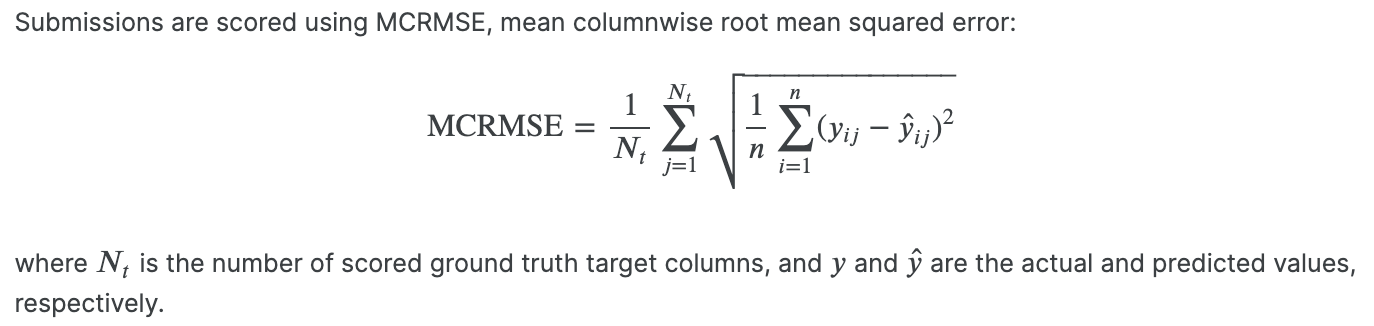

In [131]:
def MCRMSE(y_true, y_pred):
  colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
  return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1, keepdims=True)

# **Load Input Files**

In [132]:
train_path = '/content/gdrive/MyDrive/Kaggle/train.csv'
test_path = '/content/gdrive/MyDrive/Kaggle/test.csv'

input_train_df = pd.read_csv(train_path)
input_test_df = pd.read_csv(test_path)

float_labels, int_map_labels = np.arange(1, 5.5, 0.5), np.arange(9)
label_map = dict(zip(float_labels, int_map_labels))

float_scaled_labels, int_scaled_labels = np.arange(1, 6, 1), np.arange(6)
label_scaled_map = dict(zip(float_scaled_labels, int_scaled_labels))

orig_train_df = copy.deepcopy(input_train_df)
orig_train_df.head()

text_id                                          full_text  cohesion  syntax  vocabulary  phraseology  grammar  conventions
0  0016926B079C  I think that students would benefit from learn...       3.5     3.5         3.0          3.0      4.0          3.0
1  0022683E9EA5  When a problem is a change you have to let it ...       2.5     2.5         3.0          2.0      2.0          2.5
2  00299B378633  Dear, Principal\n\nIf u change the school poli...       3.0     3.5         3.0          3.0      3.0          2.5
3  003885A45F42  The best time in life is when you become yours...       4.5     4.5         4.5          4.5      4.0          5.0
4  0049B1DF5CCC  Small act of kindness can impact in other peop...       2.5     3.0         3.0          3.0      2.5          2.5

"Map" columns are basically scaled columns of the original metric values. There are total 9 levels in map columns. Original mretric columns range from 1 to 5. Through map columns, they range from 0 to 8.

"Scaled" columns map numbers .5, 1.5, 2.5, 3.5 and 4.5 to nearset integers. Thus it will have range from 1 to 5.

# **Split Data** into **3 Dataframes**
- df_train
- df_val
- df_test

Original test data is very limited, there are only 3 records and it does not have labels to test. So we decided to repurpose the given train data to split into train, test and validation sets.

In [133]:
shuffle = np.random.permutation(np.arange(orig_train_df.shape[0]))
orig_train_df = orig_train_df.iloc[shuffle]
split=(0.8,0.1,0.1)
splits = np.multiply(len(orig_train_df), split).astype(int)
df_train, df_val, df_test = np.split(orig_train_df, [splits[0], splits[0] + splits[1]])
df_train.head()

text_id                                          full_text  cohesion  syntax  vocabulary  phraseology  grammar  conventions
134   0A8B8F282E45  Winston Churchill once said "success consists ...       3.0     2.0         2.5          2.5      2.5          2.5
1470  71BA665B1B31  I think that imagination is not more important...       3.0     4.0         3.0          3.5      3.5          3.0
1216  5EA71157D48F  I supported that people make their own decisio...       2.5     2.5         2.5          2.5      3.0          3.5
3705  F7B5DF87EA1D  If we didn't take a action, What should we do?...       2.5     2.5         3.0          3.0      3.5          3.5
2121  9EBCC1131B13  As we have two different people, we have two t...       4.5     3.0         4.0          3.5      3.0          3.5

In [134]:
label_cols = df_train.columns[2:]
print(label_cols)
label_rounded_cols = [col + '_rounded_val' for col in label_cols]
label_map_cols = [col + '_map' for col in label_cols]
cat_label_cols = get_cat_label_cols(label_cols)

df_train = apply_label_map(df_train, label_map, label_cols)
df_test = apply_label_map(df_test, label_map, label_cols)
df_val = apply_label_map(df_val, label_map, label_cols)

Index(['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'], dtype='object')


In [135]:
label_cols, label_rounded_cols, label_map_cols, cat_label_cols

(Index(['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'], dtype='object'),
 ['cohesion_rounded_val',
  'syntax_rounded_val',
  'vocabulary_rounded_val',
  'phraseology_rounded_val',
  'grammar_rounded_val',
  'conventions_rounded_val'],
 ['cohesion_map',
  'syntax_map',
  'vocabulary_map',
  'phraseology_map',
  'grammar_map',
  'conventions_map'],
 ['cat_cohesion',
  'cat_syntax',
  'cat_vocabulary',
  'cat_phraseology',
  'cat_grammar',
  'cat_conventions'])

# **Addiung Other Feature Columns**

In [136]:
df_train = add_feature(df_train)
df_test = add_feature(df_test)
df_val = add_feature(df_val)

# **EDA**

In [137]:
df_train.head()

text_id                                          full_text  cohesion  syntax  vocabulary  phraseology  grammar  conventions  cohesion_map  syntax_map  vocabulary_map  \
134   0A8B8F282E45  Winston Churchill once said "success consists ...       3.0     2.0         2.5          2.5      2.5          2.5             4           2               3   
1470  71BA665B1B31  I think that imagination is not more important...       3.0     4.0         3.0          3.5      3.5          3.0             4           6               4   
1216  5EA71157D48F  I supported that people make their own decisio...       2.5     2.5         2.5          2.5      3.0          3.5             3           3               3   
3705  F7B5DF87EA1D  If we didn't take a action, What should we do?...       2.5     2.5         3.0          3.0      3.5          3.5             3           3               4   
2121  9EBCC1131B13  As we have two different people, we have two t...       4.5     3.0         4.0          3.5      3.0          3.5             7           4               6   

      phraseology_map  grammar_map  conventions_map  word_count  sentence_count  total_score  full_text_len  cohesion_avg_score  cohesion_above_or_below_avg_flag  \
134                 3            3                3         446              15         15.0           2373            3.128676                                 0   
1470                5            5                4         226              14         20.0           1216            3.128676                                 0   
1216                3            4                5         164               7         16.5            841            3.128676                                 0   
3705                4            5                5         347              25         18.0           1876            3.128676                                 0   
2121                5            4                5         573              19         21.5           3176            3.128676                                 1   

      cohesion_median_score  cohesion_above_or_below_median_flag  cohesion_rounded_val  syntax_avg_score  syntax_above_or_below_avg_flag  syntax_median_score  \
134                     3.0                                    0                   3.0           3.03133                               0                  3.0   
1470                    3.0                                    0                   3.0           3.03133                               1                  3.0   
1216                    3.0                                    0                   2.0           3.03133                               0                  3.0   
3705                    3.0                                    0                   2.0           3.03133                               0                  3.0   
2121                    3.0                                    1                   4.0           3.03133                               0                  3.0   

      syntax_above_or_below_median_flag  syntax_rounded_val  vocabulary_avg_score  vocabulary_above_or_below_avg_flag  vocabulary_median_score  \
134                                   0                 2.0              3.235134                                   0                      3.0   
1470                                  1                 4.0              3.235134                                   0                      3.0   
1216                                  0                 2.0              3.235134                                   0                      3.0   
3705                                  0                 2.0              3.235134                                   0                      3.0   
2121                                  0                 3.0              3.235134                                   1                      3.0   

      vocabulary_above_or_below_median_flag  vocabulary_rounded_val  phraseology_avg_score  phr

In [138]:
for col in label_cols:
    print(df_train[col + '_rounded_val'].unique())

[3. 2. 4. 1. 5.]
[2. 4. 3. 1. 5.]
[2. 3. 4. 1. 5.]
[2. 4. 3. 5. 1.]
[2. 4. 3. 1. 5.]
[2. 3. 4. 1. 5.]


In [139]:
df_train.iloc[0]

text_id                                                                        0A8B8F282E45
full_text                                 Winston Churchill once said "success consists ...
cohesion                                                                                3.0
syntax                                                                                  2.0
vocabulary                                                                              2.5
phraseology                                                                             2.5
grammar                                                                                 2.5
conventions                                                                             2.5
cohesion_map                                                                              4
syntax_map                                                                                2
vocabulary_map                                                                  

In [140]:
df_test.head()

text_id                                          full_text  cohesion  syntax  vocabulary  phraseology  grammar  conventions  cohesion_map  syntax_map  vocabulary_map  \
3317  E587CBD5D1E4  How we know the first impression is important ...       3.5     2.5         3.5          3.5      2.5          3.0             5           3               5   
3172  DF149975C610  I agree with emerson's statement. I will grow ...       3.0     3.0         3.0          3.5      2.5          3.0             4           4               4   
2999  D7301CAAFAB0  When are parents gave us advice we are able to...       2.5     2.0         2.5          2.0      2.0          3.0             3           2               3   
2824  CDDCA13DB734  The determination make us to do something and ...       3.5     3.0         3.0          2.5      2.5          3.5             5           4               4   
310   16B9EB49892E  The should be people make their own decision, ...       2.5     2.5         2.5          2.0      2.5          2.0             3           3               3   

      phraseology_map  grammar_map  conventions_map  word_count  sentence_count  total_score  full_text_len  cohesion_avg_score  cohesion_above_or_below_avg_flag  \
3317                5            3                4         265               8          NaN           1350            3.105867                                 1   
3172                5            3                4         502              39          NaN           2534            3.105867                                 0   
2999                2            2                4         496              27          NaN           2449            3.105867                                 0   
2824                3            3                5         309              14          NaN           1567            3.105867                                 1   
310                 2            3                2         169               9          NaN            926            3.105867                                 0   

      cohesion_median_score  cohesion_above_or_below_median_flag  cohesion_rounded_val  syntax_avg_score  syntax_above_or_below_avg_flag  syntax_median_score  \
3317                    3.0                                    1                   4.0          3.010204                               0                  3.0   
3172                    3.0                                    0                   3.0          3.010204                               0                  3.0   
2999                    3.0                                    0                   2.0          3.010204                               0                  3.0   
2824                    3.0                                    1                   4.0          3.010204                               0                  3.0   
310                     3.0                                    0                   2.0          3.010204                               0                  3.0   

      syntax_above_or_below_median_flag  syntax_rounded_val  vocabulary_avg_score  vocabulary_above_or_below_avg_flag  vocabulary_median_score  \
3317                                  0                 2.0              3.242347                                   1                      3.0   
3172                                  0                 3.0              3.242347                                   0                      3.0   
2999                                  0                 2.0              3.242347                                   0                      3.0   
2824                                  0                 3.0              3.242347                                   0                      3.0   
310                                   0                 2.0              3.242347                                   0                      3.0   

      vocabulary_above_or_below_median_flag  vocabulary_rounded_val  phraseology_avg_score  phr

In [141]:
df_val.head()

text_id                                          full_text  cohesion  syntax  vocabulary  phraseology  grammar  conventions  cohesion_map  syntax_map  vocabulary_map  \
299   16005A45A20A  There's 90% of people in the world that wants ...       4.0     3.0         3.0          3.0      3.5          3.5             6           4               4   
1371  698A3F2B43B9  Have you ever thought about staring your futur...       4.0     3.0         4.0          3.5      3.5          3.0             6           4               6   
3087  DB34A89420F2  I understand why you want to add an hour and t...       2.5     3.0         3.0          2.5      3.5          3.0             3           4               4   
1047  4FE6EABBFC00  One topic that is frequently debated is if peo...       5.0     4.5         4.0          4.5      4.0          4.5             8           7               6   
1453  6FEF6D46714D  Has it ever crossed your mind that people toda...       2.5     3.5         3.5          3.5      3.5          2.5             3           5               5   

      phraseology_map  grammar_map  conventions_map  word_count  sentence_count  total_score  full_text_len  cohesion_avg_score  cohesion_above_or_below_avg_flag  \
299                 4            5                5        1072              47          NaN           5449             3.13555                                 1   
1371                5            5                4         650              29          NaN           3372             3.13555                                 1   
3087                3            5                4         486              13          NaN           2508             3.13555                                 0   
1047                7            6                7         194              10          NaN           1128             3.13555                                 1   
1453                5            5                3         597              27          NaN           3239             3.13555                                 0   

      cohesion_median_score  cohesion_above_or_below_median_flag  cohesion_rounded_val  syntax_avg_score  syntax_above_or_below_avg_flag  syntax_median_score  \
299                     3.0                                    1                   4.0          3.021739                               0                  3.0   
1371                    3.0                                    1                   4.0          3.021739                               0                  3.0   
3087                    3.0                                    0                   2.0          3.021739                               0                  3.0   
1047                    3.0                                    1                   5.0          3.021739                               1                  3.0   
1453                    3.0                                    0                   2.0          3.021739                               1                  3.0   

      syntax_above_or_below_median_flag  syntax_rounded_val  vocabulary_avg_score  vocabulary_above_or_below_avg_flag  vocabulary_median_score  \
299                                   0                 3.0              3.234015                                   0                      3.0   
1371                                  0                 3.0              3.234015                                   1                      3.0   
3087                                  0                 3.0              3.234015                                   0                      3.0   
1047                                  1                 4.0              3.234015                                   1                      3.0   
1453                                  1                 4.0              3.234015                                   1                      3.0   

      vocabulary_above_or_below_median_flag  vocabulary_rounded_val  phraseology_avg_score  phr

In [142]:
df_train.shape, df_test.shape, df_val.shape

((3128, 48), (392, 48), (391, 48))

In [143]:
df_train.describe()

cohesion       syntax   vocabulary  phraseology      grammar  conventions  cohesion_map   syntax_map  vocabulary_map  phraseology_map  grammar_map  conventions_map  \
count  3128.000000  3128.000000  3128.000000  3128.000000  3128.000000  3128.000000   3128.000000  3128.000000     3128.000000      3128.000000  3128.000000      3128.000000   
mean      3.128676     3.031330     3.235134     3.123242     3.029252     3.081841      4.257353     4.062660        4.470269         4.246483     4.058504         4.163683   
std       0.660566     0.642023     0.582582     0.656872     0.697791     0.670081      1.321132     1.284046        1.165164         1.313744     1.395581         1.340161   
min       1.000000     1.000000     1.000000     1.000000     1.000000     1.000000      0.000000     0.000000        0.000000         0.000000     0.000000         0.000000   
25%       2.500000     2.500000     3.000000     2.500000     2.500000     2.500000      3.000000     3.000000        4.000000         3.000000     3.000000         3.000000   
50%       3.000000     3.000000     3.000000     3.000000     3.000000     3.000000      4.000000     4.000000        4.000000         4.000000     4.000000         4.000000   
75%       3.500000     3.500000     3.500000     3.500000     3.500000     3.500000      5.000000     5.000000        5.000000         5.000000     5.000000         5.000000   
max       5.000000     5.000000     5.000000     5.000000     5.000000     5.000000      8.000000     8.000000        8.000000         8.000000     8.000000         8.000000   

        word_count  sentence_count  total_score  full_text_len  cohesion_avg_score  cohesion_above_or_below_avg_flag  cohesion_median_score  cohesion_above_or_below_median_flag  \
count  3128.000000     3128.000000  3128.000000    3128.000000         3128.000000                       3128.000000                 3128.0                          3128.000000   
mean    431.981458       18.186061    18.629476    2341.242327            3.128676                          0.429348                    3.0                             0.429348   
std     191.928298       10.180678     3.355094    1029.872033            0.000000                          0.495062                    0.0                             0.495062   
min      51.000000        1.000000     6.000000     269.000000            3.128676                          0.000000                    3.0                             0.000000   
25%     294.750000       10.000000    16.000000    1601.000000            3.128676                          0.000000                    3.0                             0.000000   
50%     401.000000       17.000000    18.500000    2174.000000            3.128676                          0.000000                    3.0                             0.000000   
75%     530.000000       24.000000    21.000000    2869.250000            3.128676                          1.000000                    3.0                             1.000000   
max    1260.000000       99.000000    30.000000    6044.000000            3.128676                          1.000000                    3.0                             1.000000   

       cohesion_rounded_val  syntax_avg_score  syntax_above_or_below_avg_flag  syntax_median_score  syntax_above_or_below_median_flag  syntax_rounded_val  vocabulary_avg_score  \
count           3128.000000        3128.00000                     3128.000000               3128.0                        3128.000000         3128.000000          3.128000e+03   
mean               3.143542           3.03133                        0.351662                  3.0                           0.351662            3.023338          3.235134e+00   
std                0.853247           0.00000                        0.477566                  0.0                           0.477566            0.838645          4.441602e-16   
min                1.000000           3.03133                        0.000000  

# **Visualization**

## **Corelation Matrix of the Label Columns**

In [155]:
# corr = df_train[label_cols].corr()

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype = bool))

# sns.set(rc = {"figure.figsize": (10, 8)})

# sns.heatmap(corr, 
#             annot = True, 
#             cmap = "coolwarm", 
#             mask = mask,
#             fmt  = ".5f")
# plt.show()

## **Essay Length, Word Count, Total Score, Sentence Count Distribution**

Essay length, word count and sentence count diostributions have normal shape, though left skewed. Total score distribution looks bi-modal.

In [156]:
# plt.figure(figsize=(20,5))

# plt.subplot(1,4,1)
# sns.histplot(data=df_train, x='word_count', kde=True)
# plt.axvline(x=df_train['word_count'].mean(),color='red')
# plt.axvline(x=df_train['word_count'].median(),color='black')
# plt.xlabel('Word Count Distribution',fontsize=12)
# plt.title('Word Count Distribution',fontsize=16)

# plt.subplot(1,4,2)
# sns.histplot(data=df_train, x='full_text_len', kde=True)
# plt.axvline(x=df_train['full_text_len'].mean(),color='red')
# plt.axvline(x=df_train['full_text_len'].median(),color='black')
# plt.xlabel('Full Text Length Distribution',fontsize=12)
# plt.title('Full Text Length Distribution',fontsize=16)

# plt.subplot(1,4,3)
# sns.histplot(data=df_train, x='total_score', kde=True)
# plt.axvline(x=df_train['total_score'].mean(),color='red')
# plt.axvline(x=df_train['total_score'].median(),color='black')
# plt.xlabel('Total Score Distribution',fontsize=12)
# plt.title('Total Score Distribution',fontsize=16)

# plt.subplot(1,4,4)
# sns.histplot(data=df_train, x='sentence_count', kde=True)
# plt.axvline(x=df_train['sentence_count'].mean(),color='red')
# plt.axvline(x=df_train['sentence_count'].median(),color='black')
# plt.xlabel('Sentence Count Distribution',fontsize=12)
# plt.title('Sentence Count Distribution',fontsize=16)

## **Word Count Vs Individual Label Scores**

In [157]:
# get_histogram_for_col(df_train, label_cols, 'word_count')

## **Word Count Vs Individual Rounded Label Scores**

In [158]:
# get_histogram_for_col(df_train, label_rounded_cols, 'word_count')

## **Sentence Count Vs Individual Label Scores**

In [159]:
# get_histogram_for_col(df_train, label_cols, 'sentence_count')

## **Sentence Count Vs Individual Rounded Label Scores**

In [160]:
# get_histogram_for_col(df_train, label_rounded_cols, 'sentence_count')

## **Distribution of Labels Above and Below Average in the Respective Category**

In [161]:
# get_count_plot_for_ind_col(df_train, '_above_or_below_avg_flag', label_cols)

## **Distribution of Labels Above and Below Median in the Respective Category**

In [162]:
# get_count_plot_for_ind_col(df_train, '_above_or_below_median_flag', label_cols)

For all the labels we see that most of the label values are below average and median values.

## **Distribution of Labels**

In [163]:
# fig, ax = plt.subplots(1, len(label_cols), figsize=(40,10))

# for idx, label in enumerate(label_cols):
#     sns.distplot(x = df_train[label],
#                  ax = ax[idx]
#                 )
#     ax[idx].set_title(label)
#     #plt.show(block = False)

## **Average Score Per Label**

In [164]:
# get_barplot_for_each_label(df_train, label_cols, '_avg_score')

## **Median Score Per Label**

In [165]:
# get_barplot_for_each_label(df_train, label_cols, '_median_score')

## **Most Frequent Words**

In [166]:
# text = df_train[df_train[label_cols].sum(axis=1)==30]['full_text'].values[0]
# word_cloud = WordCloud(stopwords=STOPWORDS, colormap='Pastel1', collocations=False, width=1200, height=700, background_color = "black").generate(text)
# plt.figure(figsize=(20,8))
# plt.imshow(word_cloud)
# plt.axis("off")
# plt.show()
     

# **Regression** Model with **BERT**
[Regression with Text Input Using BERT and Transformers](https://lajavaness.medium.com/regression-with-text-input-using-bert-and-transformers-71c155034b13)


## Model Checkpoint and **Tokenization** from Pre-trained BERT

In [167]:
from transformers import BertTokenizer, TFBertModel

#make it easier to use a variety of BERT subword models
model_checkpoint = 'bert-base-cased'   # case sensitive (care about upper and lower case)
bert_model = TFBertModel.from_pretrained(model_checkpoint)  
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

In [168]:
bert_model.config

BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

## **Split Data** into **X and Y**


In [170]:
X_train, X_val, X_test = df_train['full_text'], df_val['full_text'], df_test['full_text']
y_train, y_val, y_test = np.array(df_train[label_cols]), np.array(df_val[label_cols]), np.array(df_test[label_cols])

## **Generate Input Embeddings** - Train/Validation/Test Set

In [171]:
MAX_LENGTH = 512

In [172]:
train_encodings = bert_tokenizer(X_train.tolist(), dtype="int32", truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
val_encodings = bert_tokenizer(X_val.tolist(), dtype="int32", truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
test_encodings = bert_tokenizer(X_test.tolist(), dtype="int32", truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')

## **Run Experiments**

In [173]:
def run_regression_experiment(num_train_layers=0,
                              num_hidden_layer=1,
                              num_hidden_units=256,
                              dropout=0.3,
                              learning_rate=0.00005,
                              batch_size=8,
                              csv_filename='perf_summary_regression_w_BERT.csv',
                              activation = 'relu',                                    # 'relu', 'leaky_relu', 'gelu'
                              optimizer='adam',                                       # 'adam', 'sgd'
                              epochs=10):

  df_perf_summary = pd.DataFrame()
  for layer in num_train_layers:  
    print('\n******************************************************')
    print(f'Regression with BERT: Number of Unfrozen Layers = {layer}')
    print('******************************************************\n')


    # build a regression model
    regression_with_bert, num_trainable_params, num_non_trainable_params = regression_model_with_bert(num_classes = 9,                          # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
                                                                                                      num_train_layers = layer,
                                                                                                      num_hidden_layer = num_hidden_layer,
                                                                                                      num_hidden_units = num_hidden_units,
                                                                                                      dropout = dropout,
                                                                                                      learning_rate = learning_rate,
                                                                                                      activation = activation,
                                                                                                      optimizer=optimizer)
    
    # model summary and plot model structure
    display(regression_with_bert.summary())
    display(keras.utils.plot_model(regression_with_bert, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90))

    # train model
    df_regression_model_history = train_regression(regression_with_bert, batch_size, epochs)
    print("\nPlotting loss and MCRMSE...")
    plot_loss_mcrmse(df_regression_model_history, 'MCRMSE')  

    # Evaluate test set
    score_regression = evaluate_test_labels(regression_with_bert)

    # Predict test set
    df_pred = predict_test_labels(regression_with_bert)
    df_pred_scaled = scaled_pred(df_pred)

    # ========== Performace metrics summary ===================================
    perf_metrics = pd.DataFrame({'NLP Model':"bert-base-cased",
                                'Num_Trainable_layers': layer,
                                'Epochs':epochs,                                                              
                                'Test_MCRMSE':round(score_regression[1], 4), 
                                'Test_Loss':round(score_regression[0], 4), 
                                'Train_MCRMSE':round(df_regression_model_history.iloc[-1][1], 4), 
                                'Train_Loss':round(df_regression_model_history.iloc[-1][0], 4), 
                                'Val_MCRMSE':round(df_regression_model_history.iloc[-1][3], 4), 
                                'Val_Loss':round(df_regression_model_history.iloc[-1][2], 4),  
                                'Optimizer': optimizer, 
                                'Activation': activation,  
                                'Learning_Rate':learning_rate,                               
                                'Num_Hidden_Layers':num_hidden_layer, 
                                'Num_hidden_Units':num_hidden_units,                                 
                                'Dropout': dropout, 
                                'Batch_Size': batch_size}, index=[0])
    df_perf_summary = df_perf_summary.append(perf_metrics)
  df_perf_summary.to_csv(csv_filename, index=False)
  display(df_perf_summary.reset_index(drop=True))


In [174]:
def run_regression_experiment_1(num_train_layers=0,
                              num_hidden_layer=1,
                              num_hidden_units=256,
                              dropout=0.3,
                              learning_rate=0.00005,
                              batch_size=8,
                              csv_filename='perf_summary_regression_w_BERT.csv',
                              activation = 'relu',                                    # 'relu', 'leaky_relu', 'gelu'
                              optimizer='adam',                                       # 'adam', 'sgd'
                              epochs=10):

  # df_perf_summary = pd.DataFrame()
  # for layer in num_train_layers:  
  print('\n******************************************************')
  print(f'Regression with BERT: Number of Unfrozen Layers = {num_train_layers}')
  print('******************************************************\n')


  # build a regression model
  regression_with_bert, num_trainable_params, num_non_trainable_params = regression_model_with_bert(num_classes = 9,                          # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
                                                                                                    num_train_layers = num_train_layers,
                                                                                                    num_hidden_layer = num_hidden_layer,
                                                                                                    num_hidden_units = num_hidden_units,
                                                                                                    dropout = dropout,
                                                                                                    learning_rate = learning_rate,
                                                                                                    activation = activation,
                                                                                                    optimizer=optimizer)
  
  # model summary and plot model structure
  display(regression_with_bert.summary())
  display(keras.utils.plot_model(regression_with_bert, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90))

  # train model
  df_regression_model_history = train_regression(regression_with_bert, batch_size, epochs)
  print("\nPlotting loss and MCRMSE...")
  plot_loss_mcrmse(df_regression_model_history, 'MCRMSE')  

  # Evaluate test set
  score_regression = evaluate_test_labels(regression_with_bert)

  # Predict test set
  df_pred = predict_test_labels(regression_with_bert)
  df_pred_scaled = scaled_pred(df_pred)
  df_pred.to_csv('df_pred.csv', index=False)
  
  # Create a final table with y_true, y_pred_raw, and y_pred_scaled
  df_final = generate_final_table(df_pred)
  display(generate_final_table(df_pred))
  df_final.to_csv('df_final.csv', index=False)

  # ========== Performace metrics summary ===================================
  perf_metrics = pd.DataFrame({'NLP Model':"bert-base-cased",
                              'Num_Trainable_layers': num_train_layers,
                              'Epochs':epochs,                                                              
                              'Test_MCRMSE':round(score_regression[1], 4), 
                              'Test_Loss':round(score_regression[0], 4), 
                              'Train_MCRMSE':round(df_regression_model_history.iloc[-1][1], 4), 
                              'Train_Loss':round(df_regression_model_history.iloc[-1][0], 4), 
                              'Val_MCRMSE':round(df_regression_model_history.iloc[-1][3], 4), 
                              'Val_Loss':round(df_regression_model_history.iloc[-1][2], 4),  
                              'Optimizer': optimizer, 
                              'Activation': activation,  
                              'Learning_Rate':learning_rate,                               
                              'Num_Hidden_Layers':num_hidden_layer, 
                              'Num_hidden_Units':num_hidden_units,                                 
                              'Dropout': dropout, 
                              'Batch_Size': batch_size}, index=[0])
  perf_metrics.to_csv(csv_filename, index=False)
  display(perf_metrics.reset_index(drop=True))

## **Build Regression Model with BERT**

In [175]:
def regression_model_with_bert(num_classes=9,                  # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
                               num_train_layers=0,
                               num_hidden_layer=1,
                               num_hidden_units=256,
                               dropout=0.3,
                               learning_rate=0.00005,
                               activation = 'relu',
                               optimizer='adam'):
    """
    Build a simple regression model with BERT. Use the CLS Output for regression purposes.
    """
    # =========== BEGIN generate "input features" using pre-trained model tokenizer ==================================
    if num_train_layers == 0:
        bert_model.trainable = False                 # Freeze all layers of pre-trained BERT model

    elif num_train_layers == 12:         
        bert_model.trainable = True                  # Train all layers of the BERT model

    else:                                            # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []
        for retrain_layer_number in range(num_train_layers):
            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code) 

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                w._trainable = False
    
    # Input Layer
    input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH), dtype=tf.int32, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_LENGTH), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                  'attention_mask': attention_mask
                  }
                      
    # Bert output: being used as an input feature in the classification model below
    bert_out = bert_model(bert_inputs)        # full features as an input to the following classification model
    cls_token = bert_out[0][:, 0, :]          # give us a raw CLS tokens


    layer_list = []
    for hidden_layer_number in range(num_hidden_layer):
        if hidden_layer_number == 0:
            hidden_layer = tf.keras.layers.Dense(units = num_hidden_units
                                        , activation = activation
                                        , name = 'hidden_layer_' + str(hidden_layer_number + 1)
                                        )(cls_token)
        else:
            hidden_layer = tf.keras.layers.Dense(units = num_hidden_units
                                        , activation = activation
                                        , name = 'hidden_layer_' + str(hidden_layer_number + 1)
                                        )(layer_list[-1])
        layer_list.append(hidden_layer)
        dropout_layer = tf.keras.layers.Dropout(dropout, name = 'dropout_layer_' + str(hidden_layer_number + 1))(hidden_layer) 
        layer_list.append(dropout_layer)

    output = tf.keras.layers.Dense(6,)(layer_list[-1])
    regression_model = tf.keras.Model(inputs = [input_ids, attention_mask], outputs = output)    

    def selected_optimizer(optimizer):
      if optimizer.lower() == 'sgd':
        return SGD(learning_rate=learning_rate)           
      elif optimizer.lower() == 'adam':
        return Adam(learning_rate=learning_rate)          

    regression_model.compile(optimizer = selected_optimizer(optimizer),
                             loss=MCRMSE,
                             metrics=MCRMSE) 

    return regression_model, count_params(regression_model.trainable_weights), count_params(regression_model.non_trainable_weights)

## Set up a TensorBoard

In [176]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard

In [177]:
# # Clear any logs from previous runs
# !rm -rf ./logs/

In [178]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Train the Regression Model with:
- **Early Stopping callback** - Stop training when start overfitting
- **Model Checkpoint callback** - Save the model output in the temp folder (Model_Checkpoint) created in Google Drive. Whenever you re-run your model, the existing logs will be replaced with the output of new run.
- **Tensorboard callback** - Display the loss and MCRMSE evolution

We want to run until val_loss started increasing and over passing the training loss (overfitting). That's where the right number of epochs we need to have to run the model. To control this, we set up the Early Stopping callback.

In [179]:
# batch_size = random.choice([8,16])
def train_regression(model, batch_size, epochs):  
  checkpoint_filepath = '/content/gdrive/MyDrive/Kaggle/Model_Checkpoint'         #  Create a new directory, Model_Checkpoint, in my Google Drive first and navigate the path here
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                  save_weights_only=True,
                                                                  monitor='val_loss',
                                                                  mode='min',
                                                                  save_best_only=True)  
  # The following parameters say: "If there hasn't been at least an improvement of 0.001 in the validation loss over the previous 3 epochs, then stop the training and keep the best model you found."
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                              min_delta=0.001, # minimium amount of change to count as an improvement
                                              patience=3,      # how many epochs to wait before stopping
                                              restore_best_weights=True)

  print('Training Regression with BERT.....\n====================================='  )
  regression_model_history = model.fit([train_encodings.input_ids, 
                                        train_encodings.attention_mask
                                        ], 
                                        y_train,   
                                        validation_data =([val_encodings.input_ids, 
                                                            val_encodings.attention_mask], 
                                                          y_val
                                                          ),    
                                        batch_size = batch_size, 
                                        callbacks=[early_stopping_callback, model_checkpoint_callback],
                                        epochs = epochs 
                                        )    
  df_regression_model_history = pd.DataFrame(regression_model_history.history)
  display(df_regression_model_history.T)     
  return df_regression_model_history                                       

In [180]:
def plot_loss_mcrmse(df, eval_metric):
    x_arr = np.arange(len(df['loss'])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, df['loss'], '-o', label = 'Train Loss')
    ax.plot(x_arr, df['val_loss'], '--<', label = 'Validation Loss')
    ax.legend(fontsize = 12)
    ax.set_xlabel('Epoch', size = 12)
    ax.set_ylabel('Loss', size = 12)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, df[eval_metric], '-o', label = 'Train ' + eval_metric)
    ax.plot(x_arr, df['val_' + eval_metric], '--<', label = 'Validation ' + eval_metric)
    ax.legend(fontsize = 12)
    ax.set_xlabel('Epoch', size = 12)
    ax.set_ylabel('MCRMSE', size = 12)
    plt.show()

## Evaluate Test Set

In [181]:
def evaluate_test_labels(model):
  score_regression = model.evaluate([test_encodings.input_ids, 
                                          test_encodings.attention_mask
                                          ], 
                                          y_test
                                          ) 
  print('\nEvaluate Test Metrics:\n=================================')
  print('\nTest loss: {:.4f}'.format(score_regression[0]))
  print('\nTest MCRMSE score: {:.4f}'.format(score_regression[1]),'\n')
  return score_regression

## Predict Scores for 6 Metrics in Test Set

In [182]:
def predict_test_labels(model):
  predictions = model.predict([test_encodings.input_ids, test_encodings.attention_mask])    # -1 in reshape function is used when you don't know or want to explicitly tell the dimension of that axis.
  df_pred = pd.DataFrame(predictions, columns=['pred_'+ col for col in label_cols])
  return df_pred

## Final Output Table:
- True Scores of Test Set
- Raw Predicted Scores of Test Set 
- Scaled Predicted Scores of Test Set 

In [183]:
def scaled_pred(df):
  pred_scaled = []
  for col in df:
    df[col + '_scaled'] = df[col].apply(lambda val: round(val/0.5) * 0.5)
    pred_scaled.append(df[col + '_scaled'])
  return pd.DataFrame(pred_scaled).T

In [184]:
def generate_final_table(df_pred):
  print('\nFinal Table: y_true vs. y_pred_raw vs. y_pred_scaled\n======================================================')
  df_final = pd.concat([df_test[['full_text']].reset_index(drop=True), df_test[label_cols].reset_index(drop=True), df_pred], axis=1)
  display(df_final)
  return df_final

## **Experiment** - Regression with BERT


******************************************************
Regression with BERT: Number of Unfrozen Layers = 0
******************************************************

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                             

None

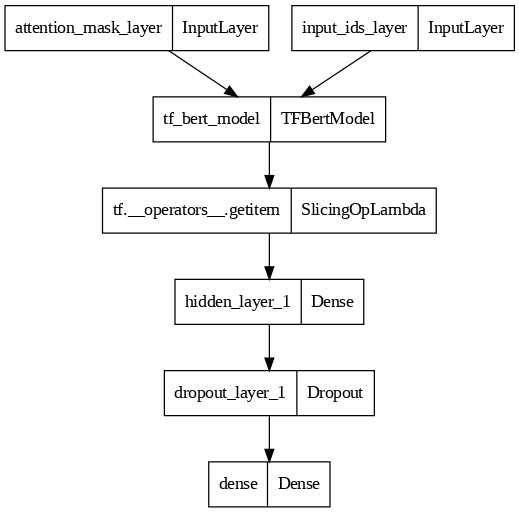

Training Regression with BERT.....
Epoch 1/10
391/391 [==============================] - 174s 420ms/step - loss: 0.9839 - MCRMSE: 0.9839 - val_loss: 0.5564 - val_MCRMSE: 0.5563
Epoch 2/10
391/391 [==============================] - 157s 403ms/step - loss: 0.6986 - MCRMSE: 0.6986 - val_loss: 0.5018 - val_MCRMSE: 0.5018
Epoch 3/10
391/391 [==============================] - 161s 412ms/step - loss: 0.6382 - MCRMSE: 0.6382 - val_loss: 0.4963 - val_MCRMSE: 0.4961
Epoch 4/10
391/391 [==============================] - 161s 411ms/step - loss: 0.6280 - MCRMSE: 0.6280 - val_loss: 0.4743 - val_MCRMSE: 0.4742
Epoch 5/10
391/391 [==============================] - 157s 401ms/step - loss: 0.6152 - MCRMSE: 0.6152 - val_loss: 0.4678 - val_MCRMSE: 0.4678
Epoch 6/10
391/391 [==============================] - 159s 407ms/step - loss: 0.6040 - MCRMSE: 0.6040 - val_loss: 0.4736 - val_MCRMSE: 0.4736
Epoch 7/10
391/391 [==============================] - 157s 401ms/step - loss: 0.5900 - MCRMSE: 0.5900 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        0.983941  0.698648  0.638181  0.628006  0.615215  0.603968  0.590027  0.583883  0.578687  0.574314
MCRMSE      0.983941  0.698648  0.638181  0.628006  0.615215  0.603968  0.590027  0.583883  0.578687  0.574314
val_loss    0.556385  0.501832  0.496285  0.474287  0.467800  0.473630  0.462185  0.461875  0.467112  0.454649
val_MCRMSE  0.556338  0.501808  0.496147  0.474212  0.467758  0.473583  0.462167  0.461867  0.467080  0.454655


Plotting loss and MCRMSE...


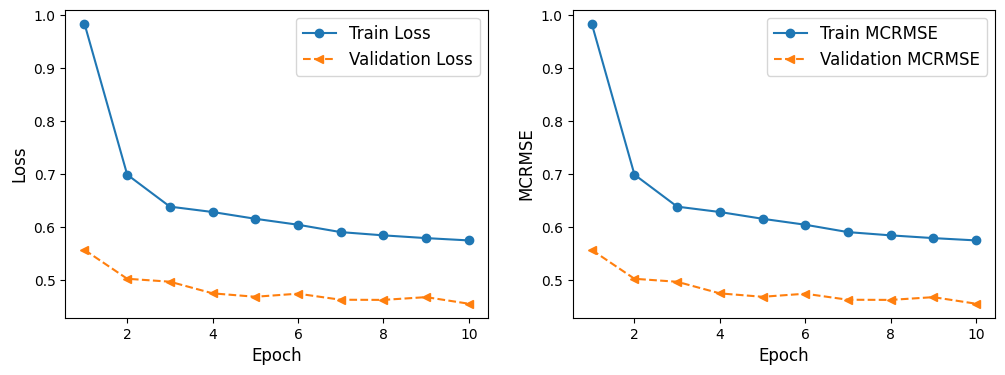

13/13 [==============================] - 16s 1s/step - loss: 0.4826 - MCRMSE: 0.4764

Evaluate Test Metrics:

Test loss: 0.4826

Test MCRMSE score: 0.4764 

13/13 [==============================] - 20s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 6
******************************************************

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

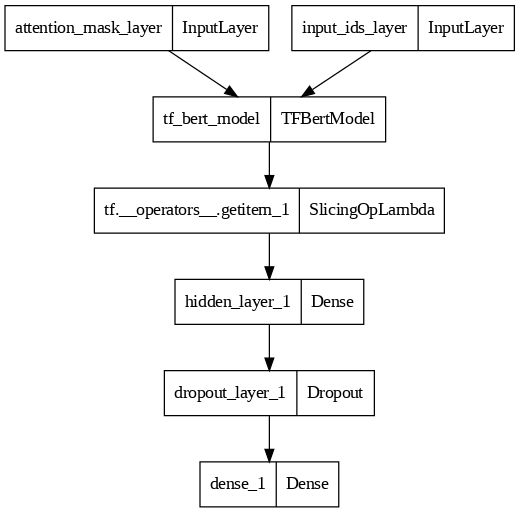

Training Regression with BERT.....
Epoch 1/10
391/391 [==============================] - 171s 423ms/step - loss: 1.1127 - MCRMSE: 1.1127 - val_loss: 0.5690 - val_MCRMSE: 0.5690
Epoch 2/10
391/391 [==============================] - 162s 413ms/step - loss: 0.7412 - MCRMSE: 0.7412 - val_loss: 0.5130 - val_MCRMSE: 0.5129
Epoch 3/10
391/391 [==============================] - 159s 407ms/step - loss: 0.6847 - MCRMSE: 0.6847 - val_loss: 0.5138 - val_MCRMSE: 0.5137
Epoch 4/10
391/391 [==============================] - 161s 411ms/step - loss: 0.6536 - MCRMSE: 0.6536 - val_loss: 0.4743 - val_MCRMSE: 0.4743
Epoch 5/10
391/391 [==============================] - 161s 412ms/step - loss: 0.6352 - MCRMSE: 0.6352 - val_loss: 0.4707 - val_MCRMSE: 0.4707
Epoch 6/10
391/391 [==============================] - 159s 407ms/step - loss: 0.6300 - MCRMSE: 0.6300 - val_loss: 0.4762 - val_MCRMSE: 0.4762
Epoch 7/10
391/391 [==============================] - 161s 411ms/step - loss: 0.6068 - MCRMSE: 0.6068 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        1.112710  0.741183  0.684658  0.653625  0.635188  0.630003  0.606769  0.597749  0.592456  0.586959
MCRMSE      1.112710  0.741183  0.684658  0.653625  0.635188  0.630003  0.606769  0.597749  0.592456  0.586959
val_loss    0.568986  0.512967  0.513786  0.474332  0.470683  0.476249  0.468342  0.472794  0.467645  0.457986
val_MCRMSE  0.568962  0.512942  0.513653  0.474299  0.470678  0.476217  0.468341  0.472777  0.467641  0.458024


Plotting loss and MCRMSE...


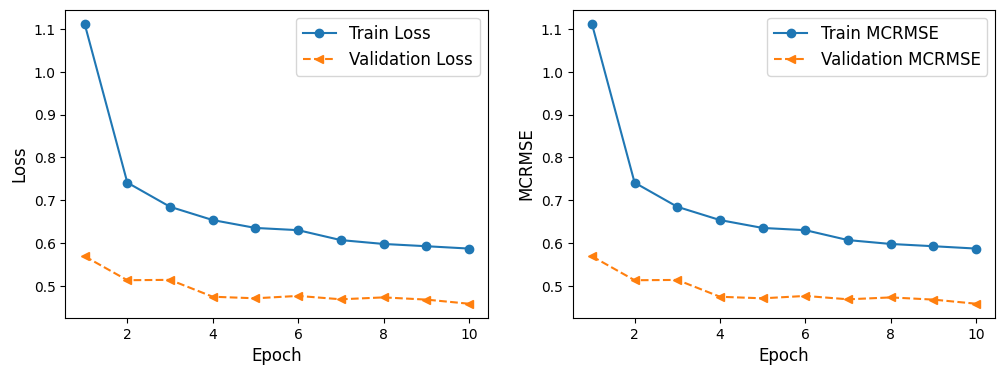

13/13 [==============================] - 16s 1s/step - loss: 0.4845 - MCRMSE: 0.4787

Evaluate Test Metrics:

Test loss: 0.4845

Test MCRMSE score: 0.4787 

13/13 [==============================] - 19s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 12
******************************************************

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
              

None

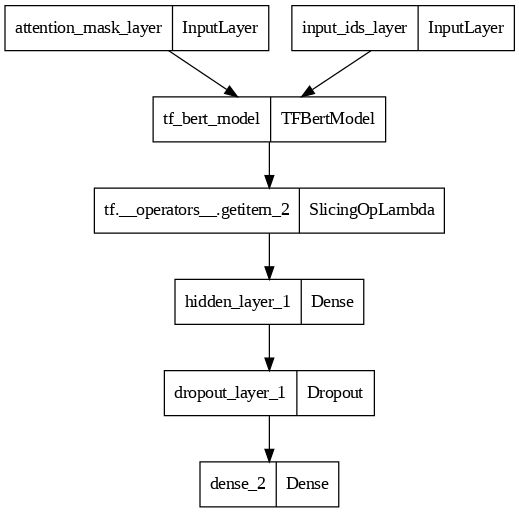

Training Regression with BERT.....
Epoch 1/10


391/391 [==============================] - 305s 722ms/step - loss: 0.7962 - MCRMSE: 0.7962 - val_loss: 0.4718 - val_MCRMSE: 0.4719
Epoch 2/10
391/391 [==============================] - 278s 712ms/step - loss: 0.6794 - MCRMSE: 0.6794 - val_loss: 0.4545 - val_MCRMSE: 0.4545
Epoch 3/10
391/391 [==============================] - 279s 713ms/step - loss: 0.6532 - MCRMSE: 0.6532 - val_loss: 0.4532 - val_MCRMSE: 0.4533
Epoch 4/10
391/391 [==============================] - 272s 696ms/step - loss: 0.6152 - MCRMSE: 0.6152 - val_loss: 0.4584 - val_MCRMSE: 0.4584
Epoch 5/10
391/391 [==============================] - 267s 684ms/step - loss: 0.5925 - MCRMSE: 0.5925 - val_loss: 0.4588 - val_MCRMSE: 0.4588
Epoch 6/10
391/391 [==============================] - 272s 695ms/step - loss: 0.5734 - MCRMSE: 0.5734 - val_loss: 0.4800 - val_MCRMSE: 0.4802
Epoch 7/10
391/391 [==============================] - 267s 683ms/step - loss: 0.5477 - MCRMSE: 0.5477 - val_loss: 0.4985 - val_MCRMSE: 0.4983
Epoch 8/10
391/39

0         1         2         3         4         5         6         7         8         9
loss        0.796240  0.679424  0.653207  0.615197  0.592527  0.573405  0.547665  0.538007  0.520453  0.505778
MCRMSE      0.796240  0.679424  0.653207  0.615197  0.592527  0.573405  0.547665  0.538007  0.520453  0.505778
val_loss    0.471809  0.454518  0.453220  0.458424  0.458767  0.480012  0.498452  0.450406  0.458841  0.448243
val_MCRMSE  0.471890  0.454511  0.453271  0.458443  0.458800  0.480152  0.498275  0.450420  0.458909  0.448163


Plotting loss and MCRMSE...


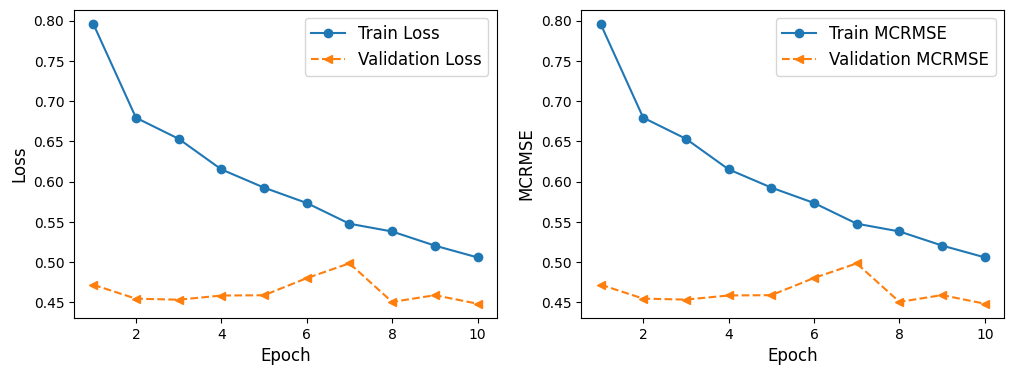

13/13 [==============================] - 16s 1s/step - loss: 0.4701 - MCRMSE: 0.4688

Evaluate Test Metrics:

Test loss: 0.4701

Test MCRMSE score: 0.4688 

13/13 [==============================] - 20s 1s/step


NLP Model  Num_Trainable_layers Trainable_Params Non-Trainable_Params  Epochs  Test_MCRMSE  Test_Loss  Train_MCRMSE  Train_Loss  Val_MCRMSE  Val_Loss  Learning_Rate  \
0  bert-base-cased                     0          198,406          108,310,272      10       0.4764     0.4826        0.5743      0.5743      0.4547    0.4546        0.00005   
1  bert-base-cased                     6          198,406          108,310,272      10       0.4787     0.4845        0.5870      0.5870      0.4580    0.4580        0.00005   
2  bert-base-cased                    12      108,508,678                    0      10       0.4688     0.4701        0.5058      0.5058      0.4482    0.4482        0.00005   

   Num_Hidden_Layers  Num_hidden_Units  Dropout  Batch_Size  
0                  1               256      0.3           8  
1                  1               256      0.3           8  
2                  1               256      0.3           8

In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,13,6),
                          activation='relu',
                          optimizer='adam',                          
                          csv_filename='perf_summary_regression_w_BERT_1.csv')


******************************************************
Regression with BERT: Number of Unfrozen Layers = 0
******************************************************

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                           

None

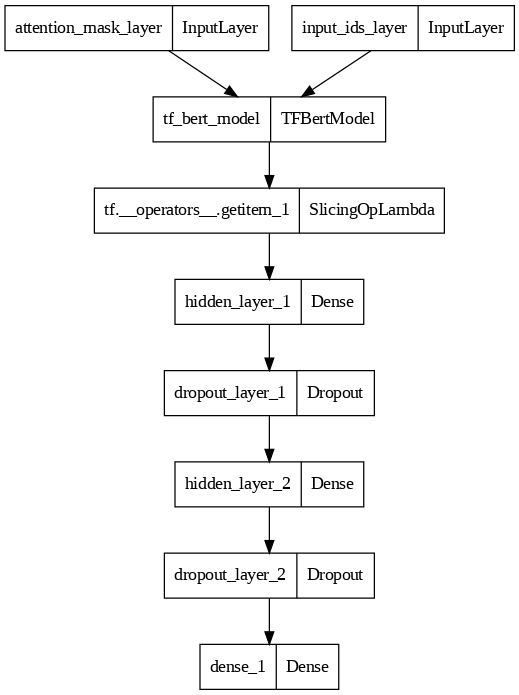

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 171s 818ms/step - loss: 2.9349 - MCRMSE: 2.9333 - val_loss: 2.7013 - val_MCRMSE: 2.7085
Epoch 2/10
196/196 [==============================] - 162s 826ms/step - loss: 2.5432 - MCRMSE: 2.5423 - val_loss: 2.2715 - val_MCRMSE: 2.2787
Epoch 3/10
196/196 [==============================] - 162s 828ms/step - loss: 2.0878 - MCRMSE: 2.0862 - val_loss: 1.6953 - val_MCRMSE: 1.7025
Epoch 4/10
196/196 [==============================] - 161s 824ms/step - loss: 1.5196 - MCRMSE: 1.5181 - val_loss: 1.0366 - val_MCRMSE: 1.0430
Epoch 5/10
196/196 [==============================] - 161s 824ms/step - loss: 1.1112 - MCRMSE: 1.1110 - val_loss: 0.6971 - val_MCRMSE: 0.7020
Epoch 6/10
196/196 [==============================] - 162s 825ms/step - loss: 0.9864 - MCRMSE: 0.9864 - val_loss: 0.6269 - val_MCRMSE: 0.6306
Epoch 7/10
196/196 [==============================] - 161s 823ms/step - loss: 0.9473 - MCRMSE: 0.9469 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        2.934896  2.543187  2.087789  1.519601  1.111196  0.986449  0.947293  0.920763  0.903362  0.896338
MCRMSE      2.933272  2.542295  2.086241  1.518090  1.111009  0.986384  0.946899  0.920293  0.903466  0.895929
val_loss    2.701277  2.271490  1.695254  1.036643  0.697137  0.626895  0.608230  0.599677  0.593473  0.588326
val_MCRMSE  2.708540  2.278693  1.702465  1.042957  0.702009  0.630642  0.611425  0.602432  0.596159  0.591028


Plotting loss and MCRMSE...


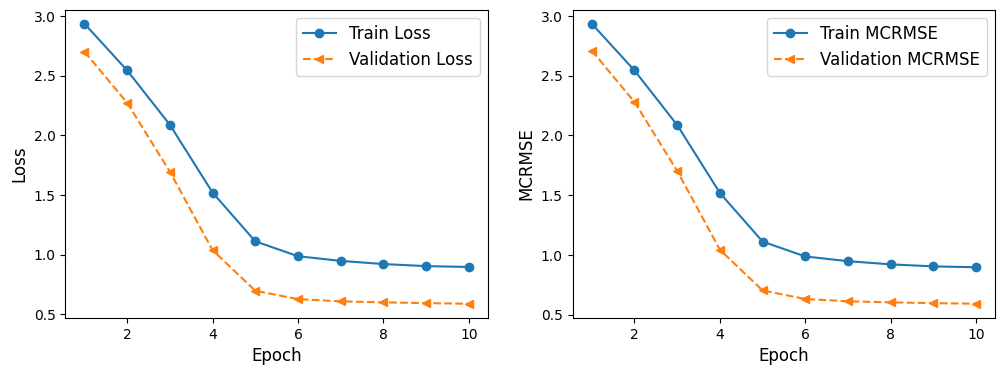

13/13 [==============================] - 15s 1s/step - loss: 0.6026 - MCRMSE: 0.6000

Evaluate Test Metrics:

Test loss: 0.6026

Test MCRMSE score: 0.6000 

13/13 [==============================] - 20s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 2
******************************************************

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

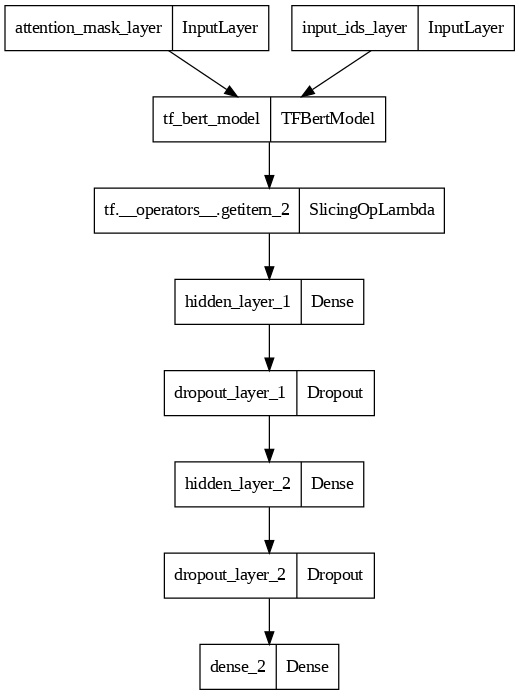

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 174s 844ms/step - loss: 3.3054 - MCRMSE: 3.3039 - val_loss: 3.0712 - val_MCRMSE: 3.0791
Epoch 2/10
196/196 [==============================] - 157s 800ms/step - loss: 2.8885 - MCRMSE: 2.8873 - val_loss: 2.5831 - val_MCRMSE: 2.5910
Epoch 3/10
196/196 [==============================] - 161s 824ms/step - loss: 2.3333 - MCRMSE: 2.3319 - val_loss: 1.8882 - val_MCRMSE: 1.8959
Epoch 4/10
196/196 [==============================] - 161s 824ms/step - loss: 1.6755 - MCRMSE: 1.6746 - val_loss: 1.1475 - val_MCRMSE: 1.1544
Epoch 5/10
196/196 [==============================] - 162s 825ms/step - loss: 1.1374 - MCRMSE: 1.1373 - val_loss: 0.7002 - val_MCRMSE: 0.7052
Epoch 6/10
196/196 [==============================] - 162s 826ms/step - loss: 0.9693 - MCRMSE: 0.9697 - val_loss: 0.6173 - val_MCRMSE: 0.6204
Epoch 7/10
196/196 [==============================] - 162s 825ms/step - loss: 0.9334 - MCRMSE: 0.9333 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        3.305440  2.888457  2.333335  1.675512  1.137419  0.969293  0.933405  0.920202  0.914304  0.898849
MCRMSE      3.303855  2.887313  2.331937  1.674564  1.137272  0.969744  0.933293  0.919728  0.914576  0.898332
val_loss    3.071232  2.583113  1.888204  1.147539  0.700242  0.617308  0.603697  0.594824  0.588670  0.581733
val_MCRMSE  3.079124  2.590951  1.895901  1.154415  0.705174  0.620381  0.606240  0.597057  0.590903  0.584119


Plotting loss and MCRMSE...


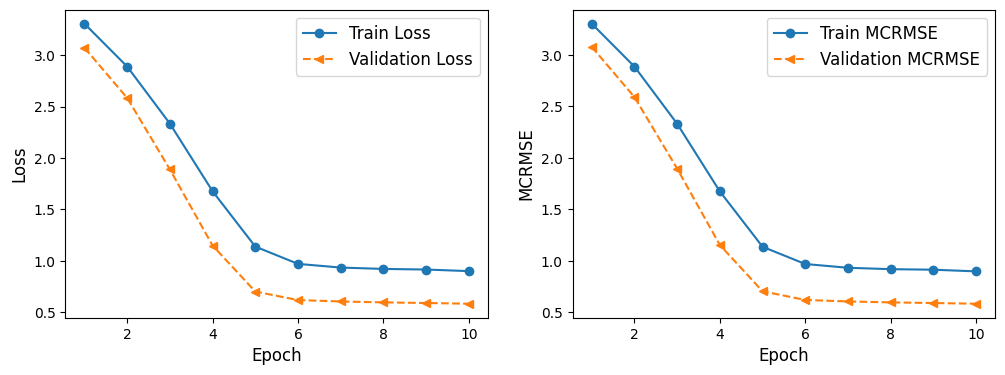

13/13 [==============================] - 15s 1s/step - loss: 0.5977 - MCRMSE: 0.5958

Evaluate Test Metrics:

Test loss: 0.5977

Test MCRMSE score: 0.5958 

13/13 [==============================] - 18s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 4
******************************************************

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

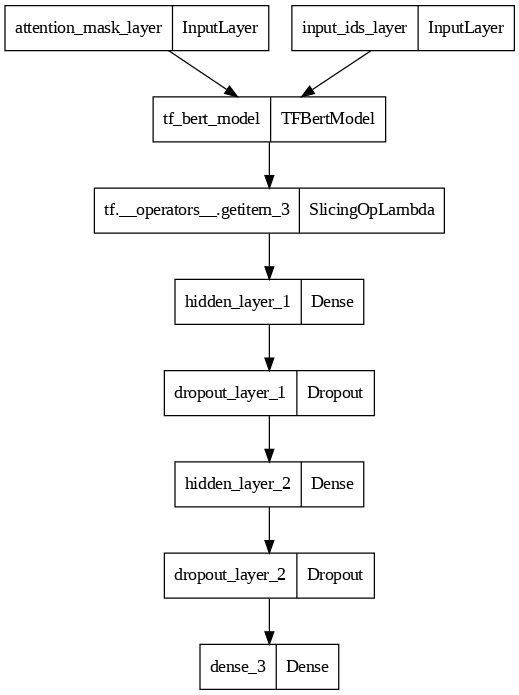

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 171s 830ms/step - loss: 2.9649 - MCRMSE: 2.9630 - val_loss: 2.6726 - val_MCRMSE: 2.6798
Epoch 2/10
196/196 [==============================] - 161s 822ms/step - loss: 2.5223 - MCRMSE: 2.5213 - val_loss: 2.2083 - val_MCRMSE: 2.2153
Epoch 3/10
196/196 [==============================] - 156s 798ms/step - loss: 2.0065 - MCRMSE: 2.0052 - val_loss: 1.5458 - val_MCRMSE: 1.5525
Epoch 4/10
196/196 [==============================] - 162s 825ms/step - loss: 1.4453 - MCRMSE: 1.4442 - val_loss: 0.9940 - val_MCRMSE: 0.9997
Epoch 5/10
196/196 [==============================] - 161s 823ms/step - loss: 1.1086 - MCRMSE: 1.1078 - val_loss: 0.6971 - val_MCRMSE: 0.7012
Epoch 6/10
196/196 [==============================] - 156s 797ms/step - loss: 0.9700 - MCRMSE: 0.9705 - val_loss: 0.6243 - val_MCRMSE: 0.6273
Epoch 7/10
196/196 [==============================] - 161s 823ms/step - loss: 0.9449 - MCRMSE: 0.9447 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        2.964889  2.522344  2.006521  1.445330  1.108551  0.970049  0.944899  0.918638  0.901881  0.894021
MCRMSE      2.963046  2.521271  2.005236  1.444160  1.107832  0.970471  0.944749  0.918228  0.901607  0.894033
val_loss    2.672610  2.208261  1.545826  0.994008  0.697078  0.624326  0.606530  0.596905  0.588881  0.582713
val_MCRMSE  2.679756  2.215309  1.552520  0.999694  0.701232  0.627348  0.609128  0.599117  0.590989  0.584820


Plotting loss and MCRMSE...


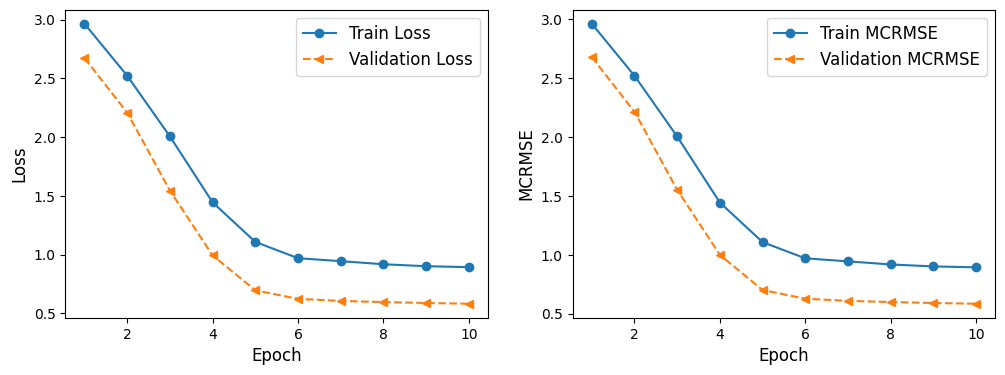

13/13 [==============================] - 15s 1s/step - loss: 0.6057 - MCRMSE: 0.6012

Evaluate Test Metrics:

Test loss: 0.6057

Test MCRMSE score: 0.6012 

13/13 [==============================] - 18s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 6
******************************************************

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

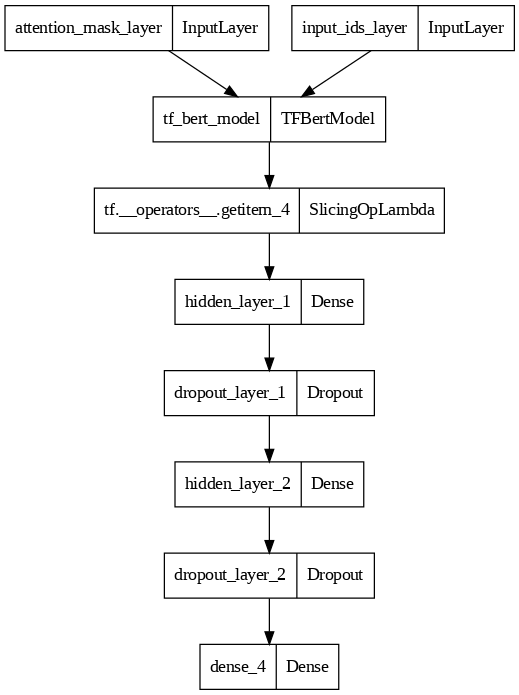

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 174s 843ms/step - loss: 2.6128 - MCRMSE: 2.6109 - val_loss: 2.2479 - val_MCRMSE: 2.2550
Epoch 2/10
196/196 [==============================] - 161s 822ms/step - loss: 1.8606 - MCRMSE: 1.8588 - val_loss: 1.3649 - val_MCRMSE: 1.3711
Epoch 3/10
196/196 [==============================] - 161s 822ms/step - loss: 1.1955 - MCRMSE: 1.1944 - val_loss: 0.7966 - val_MCRMSE: 0.8014
Epoch 4/10
196/196 [==============================] - 156s 794ms/step - loss: 0.9239 - MCRMSE: 0.9233 - val_loss: 0.6192 - val_MCRMSE: 0.6223
Epoch 5/10
196/196 [==============================] - 161s 822ms/step - loss: 0.8613 - MCRMSE: 0.8612 - val_loss: 0.5959 - val_MCRMSE: 0.5983
Epoch 6/10
196/196 [==============================] - 157s 801ms/step - loss: 0.8448 - MCRMSE: 0.8452 - val_loss: 0.5860 - val_MCRMSE: 0.5881
Epoch 7/10
196/196 [==============================] - 162s 824ms/step - loss: 0.8392 - MCRMSE: 0.8389 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        2.612775  1.860612  1.195475  0.923932  0.861267  0.844847  0.839157  0.813334  0.813864  0.804352
MCRMSE      2.610868  1.858789  1.194394  0.923255  0.861221  0.845235  0.838885  0.813199  0.814208  0.804408
val_loss    2.247867  1.364929  0.796637  0.619172  0.595866  0.586016  0.578426  0.569917  0.563357  0.555485
val_MCRMSE  2.254976  1.371145  0.801387  0.622265  0.598335  0.588138  0.580562  0.571717  0.564952  0.557087


Plotting loss and MCRMSE...


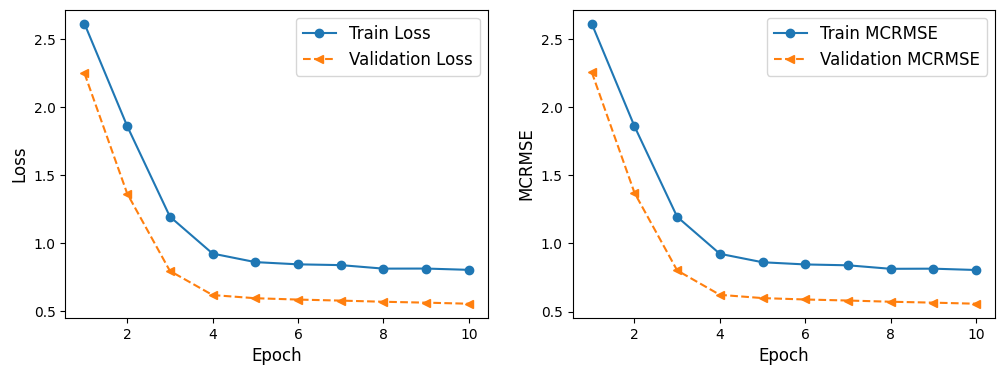

13/13 [==============================] - 15s 1s/step - loss: 0.5733 - MCRMSE: 0.5700

Evaluate Test Metrics:

Test loss: 0.5733

Test MCRMSE score: 0.5700 

13/13 [==============================] - 18s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 8
******************************************************

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

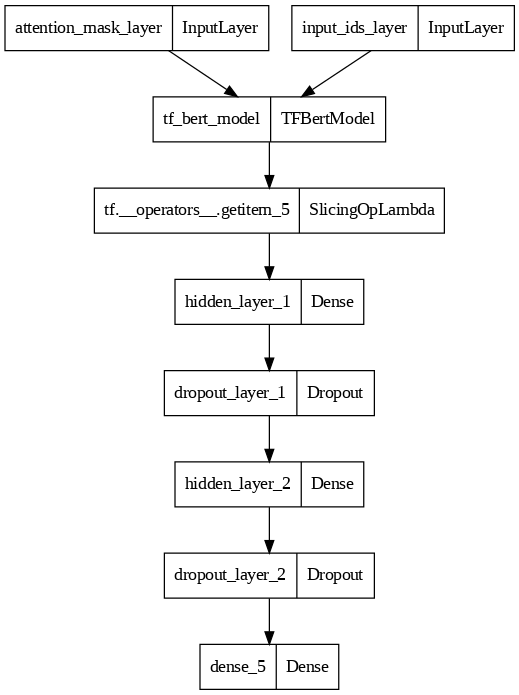

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 171s 828ms/step - loss: 3.1349 - MCRMSE: 3.1334 - val_loss: 2.9609 - val_MCRMSE: 2.9682
Epoch 2/10
196/196 [==============================] - 162s 825ms/step - loss: 2.8515 - MCRMSE: 2.8505 - val_loss: 2.6704 - val_MCRMSE: 2.6779
Epoch 3/10
196/196 [==============================] - 162s 826ms/step - loss: 2.5138 - MCRMSE: 2.5124 - val_loss: 2.2423 - val_MCRMSE: 2.2499
Epoch 4/10
196/196 [==============================] - 162s 825ms/step - loss: 2.0951 - MCRMSE: 2.0939 - val_loss: 1.7621 - val_MCRMSE: 1.7691
Epoch 5/10
196/196 [==============================] - 161s 824ms/step - loss: 1.6331 - MCRMSE: 1.6324 - val_loss: 1.2317 - val_MCRMSE: 1.2381
Epoch 6/10
196/196 [==============================] - 161s 824ms/step - loss: 1.2682 - MCRMSE: 1.2684 - val_loss: 0.8582 - val_MCRMSE: 0.8639
Epoch 7/10
196/196 [==============================] - 156s 798ms/step - loss: 1.0929 - MCRMSE: 1.0924 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        3.134858  2.851472  2.513797  2.095077  1.633149  1.268163  1.092941  1.020358  0.987379  0.981766
MCRMSE      3.133396  2.850497  2.512417  2.093857  1.632448  1.268394  1.092442  1.020167  0.987731  0.981554
val_loss    2.960899  2.670393  2.242331  1.762053  1.231715  0.858226  0.690279  0.636742  0.618446  0.613444
val_MCRMSE  2.968226  2.677921  2.249866  1.769109  1.238069  0.863922  0.695015  0.640643  0.621953  0.617041


Plotting loss and MCRMSE...


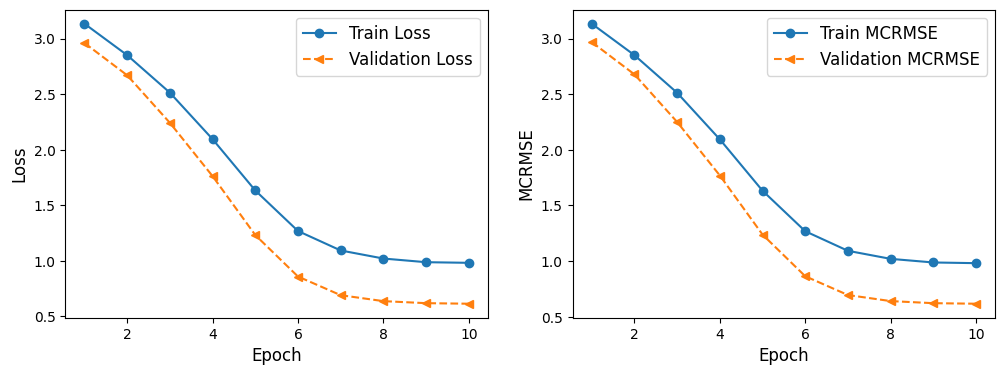

13/13 [==============================] - 15s 1s/step - loss: 0.6307 - MCRMSE: 0.6248

Evaluate Test Metrics:

Test loss: 0.6307

Test MCRMSE score: 0.6248 

13/13 [==============================] - 18s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 10
******************************************************

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
              

None

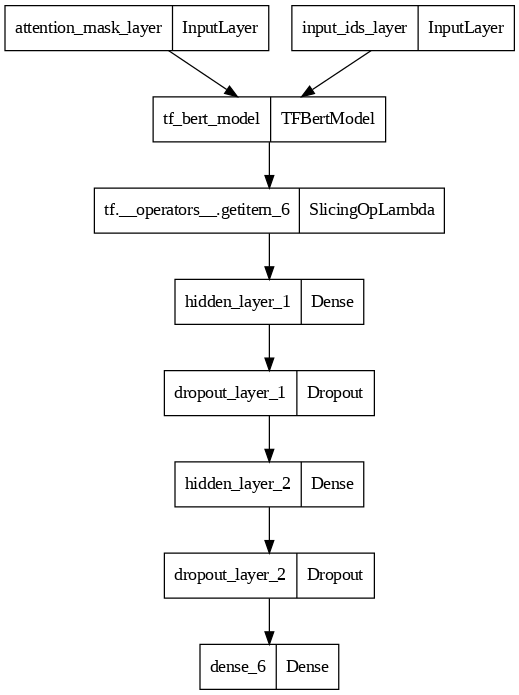

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 170s 817ms/step - loss: 2.9088 - MCRMSE: 2.9075 - val_loss: 2.6484 - val_MCRMSE: 2.6559
Epoch 2/10
196/196 [==============================] - 161s 824ms/step - loss: 2.3888 - MCRMSE: 2.3877 - val_loss: 1.9422 - val_MCRMSE: 1.9495
Epoch 3/10
196/196 [==============================] - 162s 826ms/step - loss: 1.6932 - MCRMSE: 1.6921 - val_loss: 1.1801 - val_MCRMSE: 1.1868
Epoch 4/10
196/196 [==============================] - 161s 823ms/step - loss: 1.1750 - MCRMSE: 1.1741 - val_loss: 0.7232 - val_MCRMSE: 0.7287
Epoch 5/10
196/196 [==============================] - 161s 823ms/step - loss: 1.0065 - MCRMSE: 1.0062 - val_loss: 0.6200 - val_MCRMSE: 0.6242
Epoch 6/10
196/196 [==============================] - 161s 822ms/step - loss: 0.9596 - MCRMSE: 0.9596 - val_loss: 0.6019 - val_MCRMSE: 0.6057
Epoch 7/10
196/196 [==============================] - 161s 823ms/step - loss: 0.9444 - MCRMSE: 0.9444 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        2.908845  2.388798  1.693218  1.175044  1.006473  0.959553  0.944352  0.921811  0.903077  0.893381
MCRMSE      2.907514  2.387726  1.692132  1.174090  1.006213  0.959623  0.944358  0.921699  0.902980  0.893114
val_loss    2.648366  1.942178  1.180070  0.723185  0.619995  0.601950  0.593247  0.583640  0.575800  0.569062
val_MCRMSE  2.655859  1.949514  1.186776  0.728743  0.624196  0.605683  0.596821  0.586850  0.578725  0.571971


Plotting loss and MCRMSE...


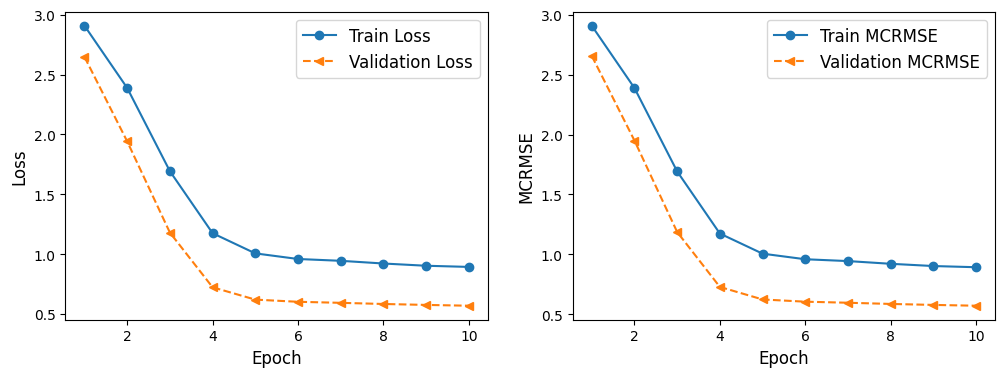

13/13 [==============================] - 15s 1s/step - loss: 0.5885 - MCRMSE: 0.5859

Evaluate Test Metrics:

Test loss: 0.5885

Test MCRMSE score: 0.5859 

13/13 [==============================] - 18s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 12
******************************************************

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
              

None

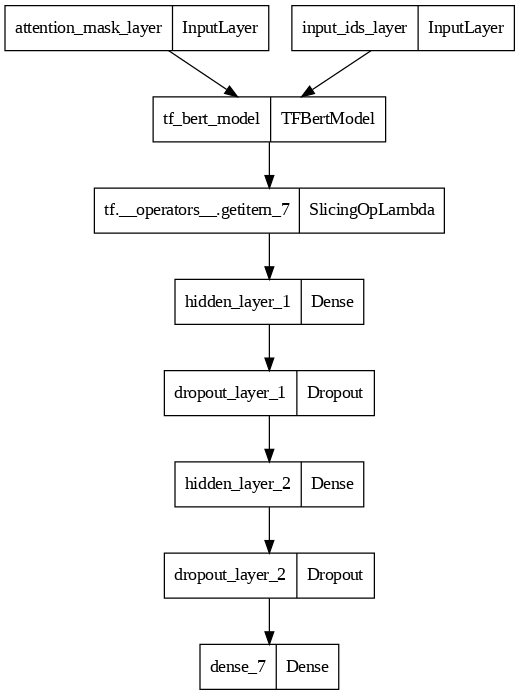

Training Regression with BERT.....
Epoch 1/10


196/196 [==============================] - 217s 1s/step - loss: 1.1983 - MCRMSE: 1.1971 - val_loss: 0.4925 - val_MCRMSE: 0.4929
Epoch 2/10
196/196 [==============================] - 200s 1s/step - loss: 0.8163 - MCRMSE: 0.8160 - val_loss: 0.4655 - val_MCRMSE: 0.4647
Epoch 3/10
196/196 [==============================] - 200s 1s/step - loss: 0.7859 - MCRMSE: 0.7861 - val_loss: 0.4487 - val_MCRMSE: 0.4484
Epoch 4/10
196/196 [==============================] - 195s 995ms/step - loss: 0.7710 - MCRMSE: 0.7704 - val_loss: 0.4467 - val_MCRMSE: 0.4472
Epoch 5/10
196/196 [==============================] - 193s 985ms/step - loss: 0.7464 - MCRMSE: 0.7460 - val_loss: 0.4505 - val_MCRMSE: 0.4511
Epoch 6/10
196/196 [==============================] - 200s 1s/step - loss: 0.7355 - MCRMSE: 0.7356 - val_loss: 0.4437 - val_MCRMSE: 0.4443
Epoch 7/10
196/196 [==============================] - 200s 1s/step - loss: 0.7347 - MCRMSE: 0.7351 - val_loss: 0.4409 - val_MCRMSE: 0.4419
Epoch 8/10
196/196 [============

0         1         2         3         4         5         6         7         8         9
loss        1.198300  0.816349  0.785898  0.770988  0.746373  0.735467  0.734730  0.720499  0.709747  0.702606
MCRMSE      1.197116  0.815974  0.786078  0.770407  0.745978  0.735588  0.735079  0.720228  0.709871  0.702148
val_loss    0.492500  0.465507  0.448665  0.446659  0.450518  0.443652  0.440872  0.443815  0.437998  0.447828
val_MCRMSE  0.492901  0.464749  0.448389  0.447173  0.451111  0.444319  0.441891  0.444568  0.438392  0.449270


Plotting loss and MCRMSE...


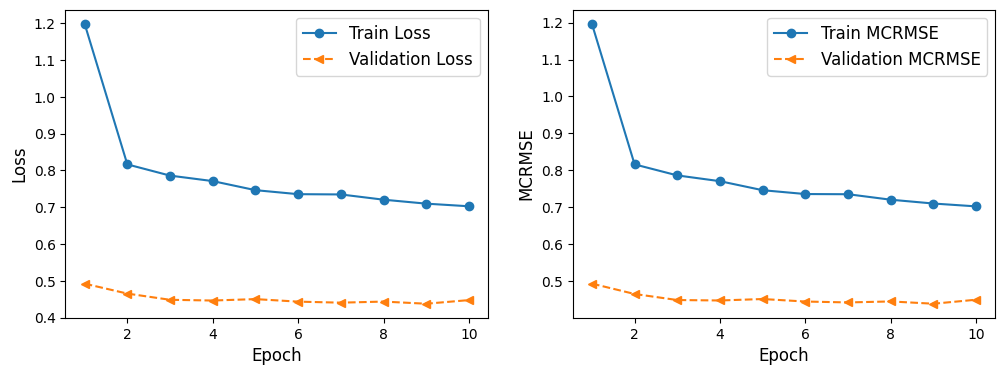

13/13 [==============================] - 15s 1s/step - loss: 0.4717 - MCRMSE: 0.4646

Evaluate Test Metrics:

Test loss: 0.4717

Test MCRMSE score: 0.4646 

13/13 [==============================] - 18s 1s/step


NLP Model  Num_Trainable_layers Trainable_Params Non-Trainable_Params  Epochs  Test_MCRMSE  Test_Loss  Train_MCRMSE  Train_Loss  Val_MCRMSE  Val_Loss  Learning_Rate  \
0  bert-base-cased                     0           53,766          108,310,272      10       0.6000     0.6026        0.8959      0.8963      0.5910    0.5883        0.00001   
1  bert-base-cased                     2           53,766          108,310,272      10       0.5958     0.5977        0.8983      0.8988      0.5841    0.5817        0.00001   
2  bert-base-cased                     4           53,766          108,310,272      10       0.6012     0.6057        0.8940      0.8940      0.5848    0.5827        0.00001   
3  bert-base-cased                     6           53,766          108,310,272      10       0.5700     0.5733        0.8044      0.8044      0.5571    0.5555        0.00001   
4  bert-base-cased                     8           53,766          108,310,272      10       0.6248     0.6307        0.9816      0.9818      0.6170    0.6134        0.00001   
5  bert-base-cased                    10           53,766          108,310,272      10       0.5859     0.5885        0.8931      0.8934      0.5720    0.5691        0.00001   
6  bert-base-cased                    12      108,364,038                    0      10       0.4646     0.4717        0.7021      0.7026      0.4493    0.4478        0.00001   

   Num_Hidden_Layers  Num_hidden_Units  Dropout  Batch_Size  
0                  2                64      0.1          16  
1                  2                64      0.1          16  
2                  2                64      0.1          16  
3                  2                64      0.1          16  
4                  2                64      0.1          16  
5                  2                64      0.1          16  
6                  2                64      0.1          16

In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,13,2),
                          num_hidden_layer=2,
                          num_hidden_units=64,
                          dropout=0.1,
                          learning_rate=0.00001,
                          batch_size=16,
                          csv_filename='perf_summary_regression_w_BERT_2.csv',
                          activation='relu',
                          optimizer='adam',
                          epochs=10)


******************************************************
Regression with BERT: Number of Unfrozen Layers = 0
******************************************************

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                             

None

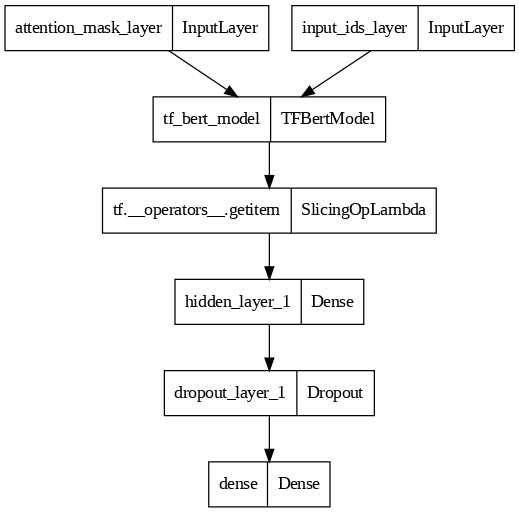

Training Regression with BERT.....
Epoch 1/10
391/391 [==============================] - 176s 429ms/step - loss: 1.0572 - MCRMSE: 1.0572 - val_loss: 0.5610 - val_MCRMSE: 0.5610
Epoch 2/10
391/391 [==============================] - 173s 443ms/step - loss: 0.7268 - MCRMSE: 0.7268 - val_loss: 0.5054 - val_MCRMSE: 0.5054
Epoch 3/10
391/391 [==============================] - 173s 442ms/step - loss: 0.6791 - MCRMSE: 0.6791 - val_loss: 0.4894 - val_MCRMSE: 0.4894
Epoch 4/10
391/391 [==============================] - 173s 441ms/step - loss: 0.6433 - MCRMSE: 0.6433 - val_loss: 0.4735 - val_MCRMSE: 0.4734
Epoch 5/10
391/391 [==============================] - 173s 442ms/step - loss: 0.6267 - MCRMSE: 0.6267 - val_loss: 0.4707 - val_MCRMSE: 0.4707
Epoch 6/10
391/391 [==============================] - 171s 436ms/step - loss: 0.6172 - MCRMSE: 0.6172 - val_loss: 0.4749 - val_MCRMSE: 0.4749
Epoch 7/10
391/391 [==============================] - 172s 440ms/step - loss: 0.5954 - MCRMSE: 0.5954 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        1.057224  0.726774  0.679065  0.643321  0.626676  0.617245  0.595443  0.592912  0.583259  0.574371
MCRMSE      1.057224  0.726774  0.679065  0.643321  0.626676  0.617245  0.595443  0.592912  0.583259  0.574371
val_loss    0.560978  0.505397  0.489437  0.473456  0.470717  0.474942  0.465315  0.466019  0.467815  0.459067
val_MCRMSE  0.560953  0.505402  0.489356  0.473395  0.470660  0.474873  0.465271  0.465984  0.467771  0.459049


Plotting loss and MCRMSE...


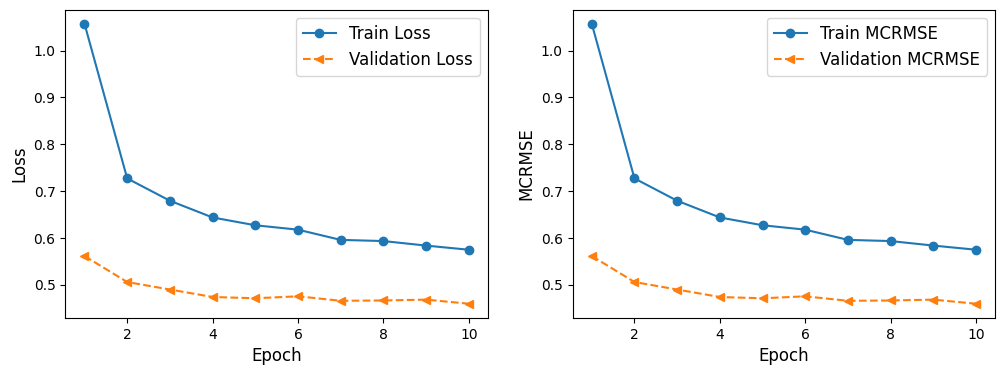

13/13 [==============================] - 18s 1s/step - loss: 0.4809 - MCRMSE: 0.4759

Evaluate Test Metrics:

Test loss: 0.4809

Test MCRMSE score: 0.4759 

13/13 [==============================] - 21s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 2
******************************************************

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

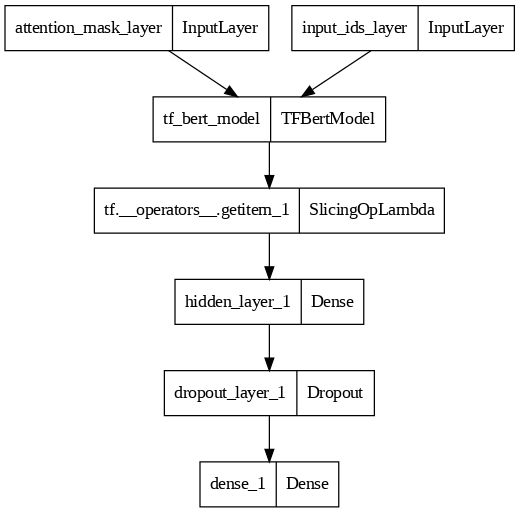

Training Regression with BERT.....
Epoch 1/10
391/391 [==============================] - 179s 443ms/step - loss: 1.1506 - MCRMSE: 1.1506 - val_loss: 0.5689 - val_MCRMSE: 0.5689
Epoch 2/10
391/391 [==============================] - 169s 432ms/step - loss: 0.7350 - MCRMSE: 0.7350 - val_loss: 0.5162 - val_MCRMSE: 0.5162
Epoch 3/10
391/391 [==============================] - 173s 441ms/step - loss: 0.6789 - MCRMSE: 0.6789 - val_loss: 0.4989 - val_MCRMSE: 0.4987
Epoch 4/10
391/391 [==============================] - 173s 443ms/step - loss: 0.6435 - MCRMSE: 0.6435 - val_loss: 0.4717 - val_MCRMSE: 0.4715
Epoch 5/10
391/391 [==============================] - 169s 433ms/step - loss: 0.6231 - MCRMSE: 0.6231 - val_loss: 0.4696 - val_MCRMSE: 0.4695
Epoch 6/10
391/391 [==============================] - 171s 436ms/step - loss: 0.6155 - MCRMSE: 0.6155 - val_loss: 0.4732 - val_MCRMSE: 0.4731
Epoch 7/10
391/391 [==============================] - 171s 436ms/step - loss: 0.6090 - MCRMSE: 0.6090 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        1.150605  0.734954  0.678879  0.643462  0.623052  0.615536  0.608992  0.596436  0.591157  0.582026
MCRMSE      1.150605  0.734954  0.678879  0.643462  0.623052  0.615536  0.608992  0.596436  0.591157  0.582026
val_loss    0.568890  0.516221  0.498886  0.471662  0.469618  0.473233  0.470650  0.469731  0.468982  0.459260
val_MCRMSE  0.568923  0.516188  0.498706  0.471511  0.469492  0.473091  0.470524  0.469641  0.468883  0.459182


Plotting loss and MCRMSE...


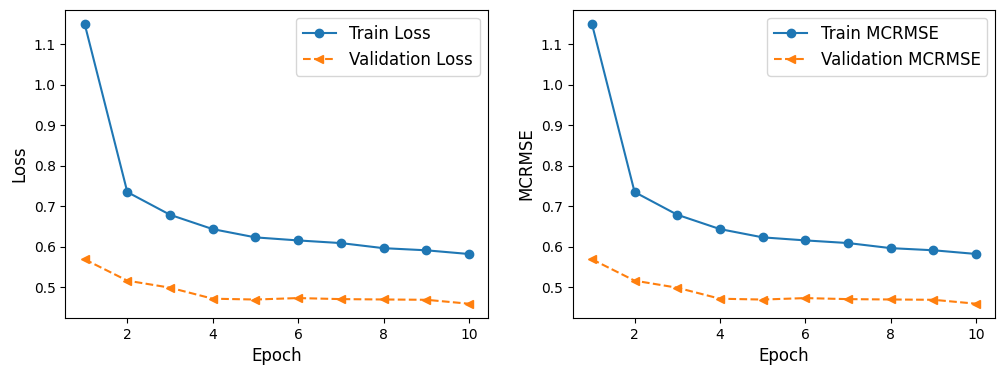

13/13 [==============================] - 17s 1s/step - loss: 0.4887 - MCRMSE: 0.4840

Evaluate Test Metrics:

Test loss: 0.4887

Test MCRMSE score: 0.4840 

13/13 [==============================] - 22s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 4
******************************************************

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

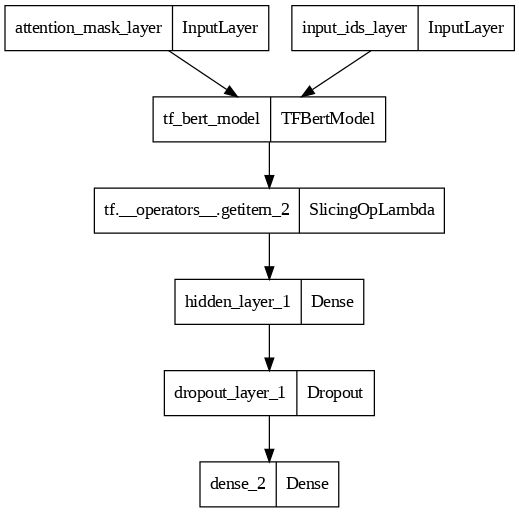

Training Regression with BERT.....
Epoch 1/10
391/391 [==============================] - 181s 452ms/step - loss: 1.0166 - MCRMSE: 1.0166 - val_loss: 0.5581 - val_MCRMSE: 0.5580
Epoch 2/10
391/391 [==============================] - 173s 443ms/step - loss: 0.7108 - MCRMSE: 0.7108 - val_loss: 0.5014 - val_MCRMSE: 0.5014
Epoch 3/10
391/391 [==============================] - 172s 441ms/step - loss: 0.6531 - MCRMSE: 0.6531 - val_loss: 0.4960 - val_MCRMSE: 0.4959
Epoch 4/10
391/391 [==============================] - 169s 433ms/step - loss: 0.6282 - MCRMSE: 0.6282 - val_loss: 0.4749 - val_MCRMSE: 0.4748
Epoch 5/10
391/391 [==============================] - 173s 441ms/step - loss: 0.6146 - MCRMSE: 0.6146 - val_loss: 0.4715 - val_MCRMSE: 0.4715
Epoch 6/10
391/391 [==============================] - 171s 437ms/step - loss: 0.6121 - MCRMSE: 0.6121 - val_loss: 0.4787 - val_MCRMSE: 0.4786
Epoch 7/10
391/391 [==============================] - 172s 441ms/step - loss: 0.5945 - MCRMSE: 0.5945 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        1.016626  0.710811  0.653068  0.628153  0.614561  0.612078  0.594466  0.583707  0.585549  0.572005
MCRMSE      1.016626  0.710811  0.653068  0.628153  0.614561  0.612078  0.594466  0.583707  0.585549  0.572005
val_loss    0.558109  0.501439  0.495995  0.474919  0.471487  0.478680  0.466912  0.476321  0.482624  0.466511
val_MCRMSE  0.558040  0.501381  0.495859  0.474844  0.471469  0.478634  0.466915  0.476295  0.482584  0.466478


Plotting loss and MCRMSE...


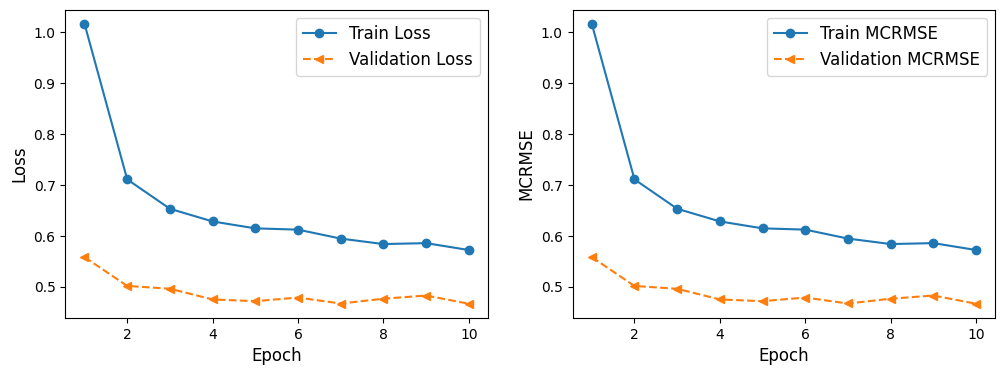

13/13 [==============================] - 17s 1s/step - loss: 0.4892 - MCRMSE: 0.4845

Evaluate Test Metrics:

Test loss: 0.4892

Test MCRMSE score: 0.4845 

13/13 [==============================] - 21s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 6
******************************************************

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

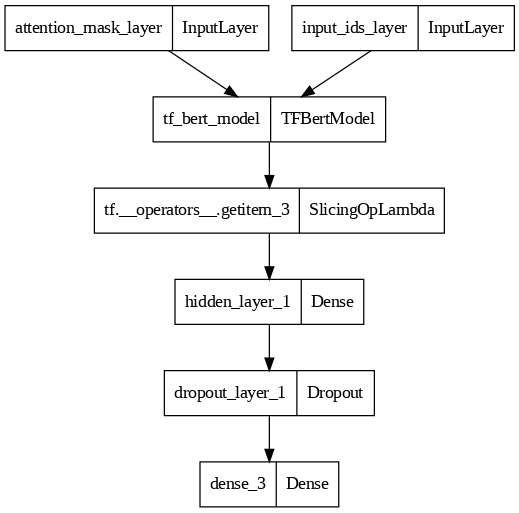

Training Regression with BERT.....
Epoch 1/10
391/391 [==============================] - 181s 448ms/step - loss: 1.0518 - MCRMSE: 1.0518 - val_loss: 0.5622 - val_MCRMSE: 0.5623
Epoch 2/10
391/391 [==============================] - 173s 442ms/step - loss: 0.7269 - MCRMSE: 0.7269 - val_loss: 0.5124 - val_MCRMSE: 0.5124
Epoch 3/10
391/391 [==============================] - 170s 434ms/step - loss: 0.6690 - MCRMSE: 0.6690 - val_loss: 0.4987 - val_MCRMSE: 0.4986
Epoch 4/10
391/391 [==============================] - 169s 433ms/step - loss: 0.6381 - MCRMSE: 0.6381 - val_loss: 0.4750 - val_MCRMSE: 0.4750
Epoch 5/10
391/391 [==============================] - 173s 441ms/step - loss: 0.6205 - MCRMSE: 0.6205 - val_loss: 0.4736 - val_MCRMSE: 0.4736
Epoch 6/10
391/391 [==============================] - 171s 436ms/step - loss: 0.6109 - MCRMSE: 0.6109 - val_loss: 0.4755 - val_MCRMSE: 0.4755
Epoch 7/10
391/391 [==============================] - 169s 432ms/step - loss: 0.5952 - MCRMSE: 0.5952 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        1.051783  0.726945  0.668982  0.638124  0.620527  0.610932  0.595205  0.588692  0.583954  0.569291
MCRMSE      1.051783  0.726945  0.668982  0.638124  0.620527  0.610932  0.595205  0.588692  0.583954  0.569291
val_loss    0.562186  0.512408  0.498709  0.475004  0.473609  0.475545  0.467700  0.463109  0.465702  0.466068
val_MCRMSE  0.562271  0.512441  0.498625  0.474958  0.473585  0.475517  0.467677  0.463111  0.465682  0.466039


Plotting loss and MCRMSE...


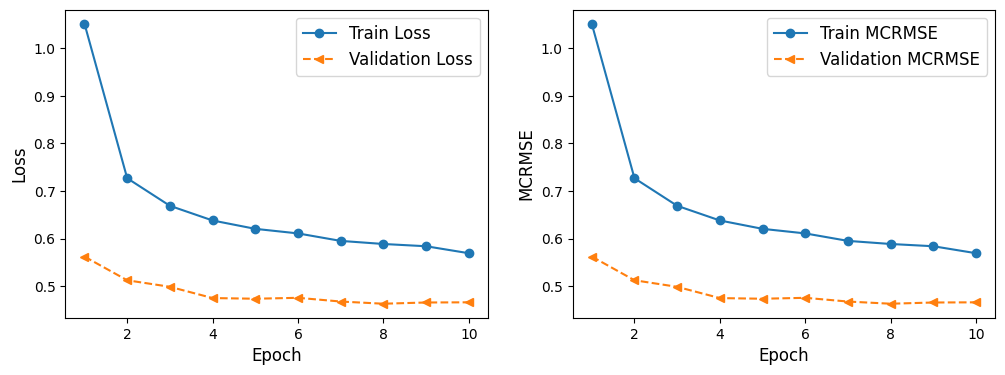

13/13 [==============================] - 17s 1s/step - loss: 0.4872 - MCRMSE: 0.4826

Evaluate Test Metrics:

Test loss: 0.4872

Test MCRMSE score: 0.4826 

13/13 [==============================] - 21s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 8
******************************************************

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

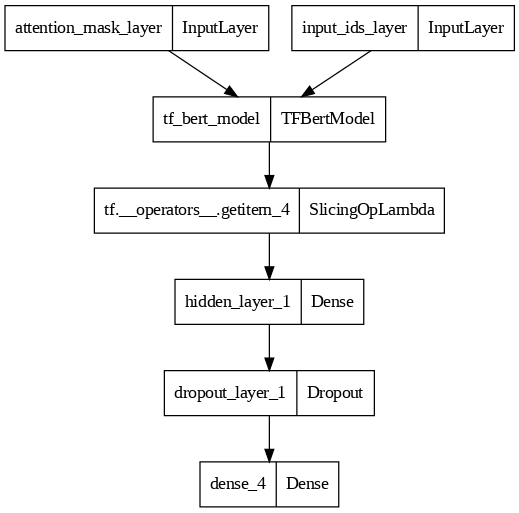

Training Regression with BERT.....
Epoch 1/10
391/391 [==============================] - 178s 440ms/step - loss: 1.0206 - MCRMSE: 1.0206 - val_loss: 0.5591 - val_MCRMSE: 0.5590
Epoch 2/10
391/391 [==============================] - 172s 441ms/step - loss: 0.7080 - MCRMSE: 0.7080 - val_loss: 0.4979 - val_MCRMSE: 0.4978
Epoch 3/10
391/391 [==============================] - 171s 436ms/step - loss: 0.6549 - MCRMSE: 0.6549 - val_loss: 0.5068 - val_MCRMSE: 0.5067
Epoch 4/10
391/391 [==============================] - 172s 441ms/step - loss: 0.6275 - MCRMSE: 0.6275 - val_loss: 0.4728 - val_MCRMSE: 0.4728
Epoch 5/10
391/391 [==============================] - 169s 432ms/step - loss: 0.6156 - MCRMSE: 0.6156 - val_loss: 0.4684 - val_MCRMSE: 0.4684
Epoch 6/10
391/391 [==============================] - 171s 437ms/step - loss: 0.6062 - MCRMSE: 0.6062 - val_loss: 0.4800 - val_MCRMSE: 0.4800
Epoch 7/10
391/391 [==============================] - 171s 436ms/step - loss: 0.5946 - MCRMSE: 0.5946 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        1.020629  0.707984  0.654945  0.627548  0.615556  0.606242  0.594594  0.591003  0.579664  0.578493
MCRMSE      1.020629  0.707984  0.654945  0.627548  0.615556  0.606242  0.594594  0.591003  0.579664  0.578493
val_loss    0.559134  0.497864  0.506829  0.472839  0.468379  0.479984  0.472278  0.466815  0.464788  0.459642
val_MCRMSE  0.559021  0.497842  0.506671  0.472815  0.468398  0.479951  0.472269  0.466830  0.464798  0.459684


Plotting loss and MCRMSE...


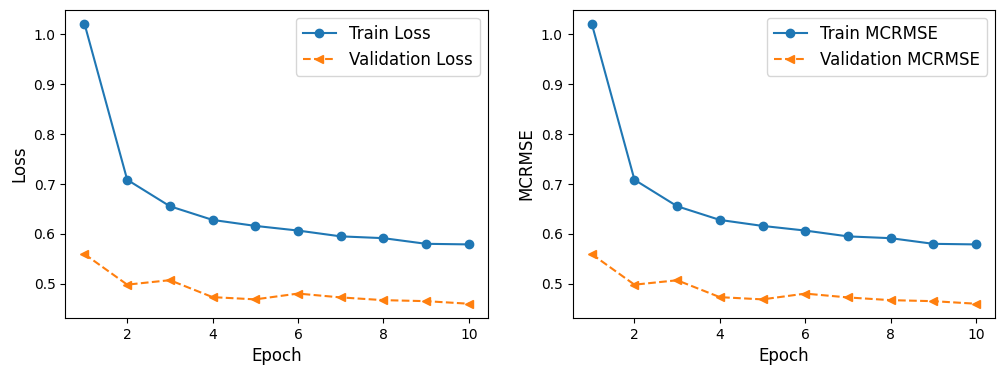

13/13 [==============================] - 17s 1s/step - loss: 0.4820 - MCRMSE: 0.4766

Evaluate Test Metrics:

Test loss: 0.4820

Test MCRMSE score: 0.4766 

13/13 [==============================] - 20s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 10
******************************************************

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
              

None

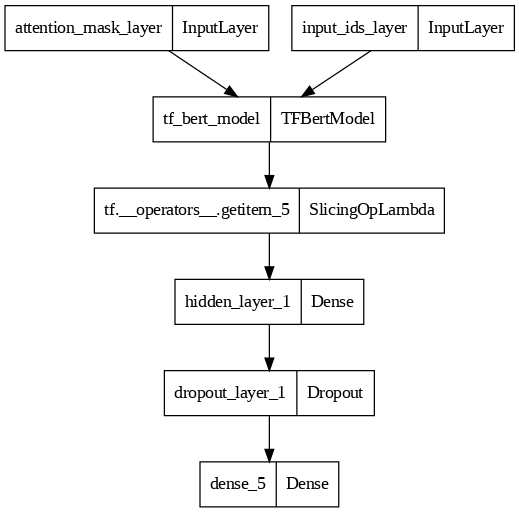

Training Regression with BERT.....
Epoch 1/10
391/391 [==============================] - 180s 444ms/step - loss: 0.9529 - MCRMSE: 0.9529 - val_loss: 0.5528 - val_MCRMSE: 0.5528
Epoch 2/10
391/391 [==============================] - 173s 443ms/step - loss: 0.6974 - MCRMSE: 0.6974 - val_loss: 0.4980 - val_MCRMSE: 0.4980
Epoch 3/10
391/391 [==============================] - 169s 433ms/step - loss: 0.6543 - MCRMSE: 0.6543 - val_loss: 0.4933 - val_MCRMSE: 0.4932
Epoch 4/10
391/391 [==============================] - 173s 443ms/step - loss: 0.6220 - MCRMSE: 0.6220 - val_loss: 0.4743 - val_MCRMSE: 0.4742
Epoch 5/10
391/391 [==============================] - 173s 442ms/step - loss: 0.6143 - MCRMSE: 0.6143 - val_loss: 0.4653 - val_MCRMSE: 0.4654
Epoch 6/10
391/391 [==============================] - 171s 436ms/step - loss: 0.6035 - MCRMSE: 0.6035 - val_loss: 0.4814 - val_MCRMSE: 0.4813
Epoch 7/10
391/391 [==============================] - 172s 441ms/step - loss: 0.5923 - MCRMSE: 0.5923 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        0.952873  0.697384  0.654255  0.621950  0.614316  0.603480  0.592286  0.587319  0.583173  0.577734
MCRMSE      0.952873  0.697384  0.654255  0.621950  0.614316  0.603480  0.592286  0.587319  0.583173  0.577734
val_loss    0.552838  0.498010  0.493332  0.474270  0.465338  0.481371  0.460171  0.465180  0.469337  0.458866
val_MCRMSE  0.552753  0.497970  0.493216  0.474228  0.465354  0.481321  0.460186  0.465185  0.469309  0.458889


Plotting loss and MCRMSE...


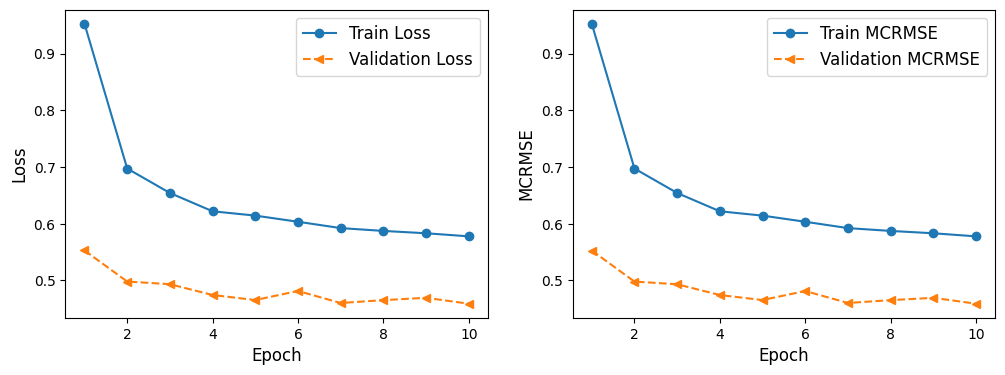

13/13 [==============================] - 17s 1s/step - loss: 0.4856 - MCRMSE: 0.4798

Evaluate Test Metrics:

Test loss: 0.4856

Test MCRMSE score: 0.4798 

13/13 [==============================] - 21s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 12
******************************************************

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
              

None

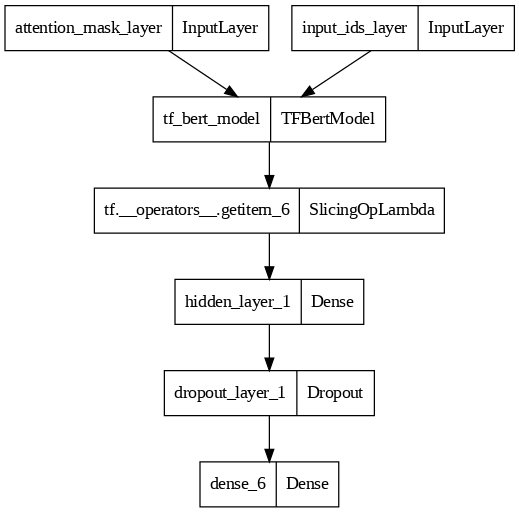

Training Regression with BERT.....
Epoch 1/10


391/391 [==============================] - 228s 555ms/step - loss: 0.7389 - MCRMSE: 0.7389 - val_loss: 0.4643 - val_MCRMSE: 0.4642
Epoch 2/10
391/391 [==============================] - 211s 540ms/step - loss: 0.6464 - MCRMSE: 0.6464 - val_loss: 0.4614 - val_MCRMSE: 0.4614
Epoch 3/10
391/391 [==============================] - 215s 549ms/step - loss: 0.6176 - MCRMSE: 0.6176 - val_loss: 0.4494 - val_MCRMSE: 0.4494
Epoch 4/10
391/391 [==============================] - 208s 531ms/step - loss: 0.6051 - MCRMSE: 0.6051 - val_loss: 0.4499 - val_MCRMSE: 0.4499
Epoch 5/10
391/391 [==============================] - 204s 522ms/step - loss: 0.5904 - MCRMSE: 0.5904 - val_loss: 0.4529 - val_MCRMSE: 0.4530
Epoch 6/10
391/391 [==============================] - 214s 547ms/step - loss: 0.5779 - MCRMSE: 0.5779 - val_loss: 0.4408 - val_MCRMSE: 0.4409
Epoch 7/10
391/391 [==============================] - 208s 531ms/step - loss: 0.5626 - MCRMSE: 0.5626 - val_loss: 0.4457 - val_MCRMSE: 0.4459
Epoch 8/10
391/39

0         1         2         3         4         5         6         7         8         9
loss        0.738904  0.646425  0.617643  0.605098  0.590422  0.577922  0.562631  0.552224  0.538682  0.523107
MCRMSE      0.738904  0.646425  0.617643  0.605098  0.590422  0.577922  0.562631  0.552224  0.538682  0.523107
val_loss    0.464275  0.461372  0.449441  0.449889  0.452915  0.440771  0.445737  0.448443  0.450247  0.514751
val_MCRMSE  0.464231  0.461412  0.449433  0.449903  0.452956  0.440863  0.445899  0.448676  0.450293  0.514734


Plotting loss and MCRMSE...


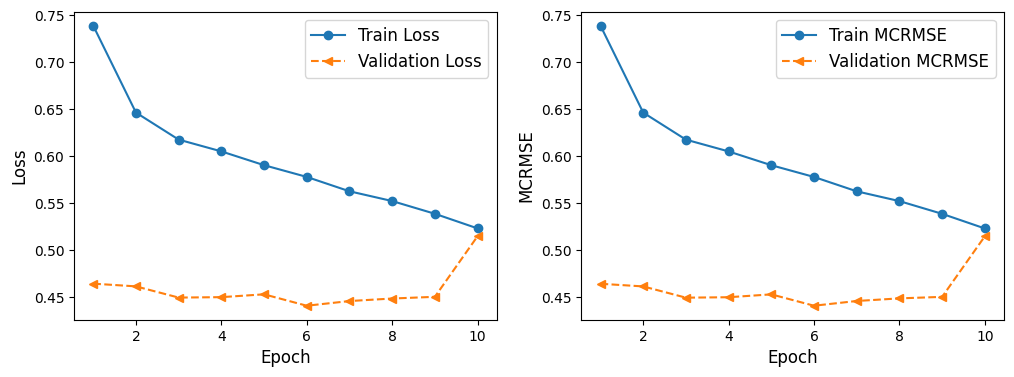

13/13 [==============================] - 17s 1s/step - loss: 0.5200 - MCRMSE: 0.5192

Evaluate Test Metrics:

Test loss: 0.5200

Test MCRMSE score: 0.5192 

13/13 [==============================] - 21s 1s/step


NLP Model  Num_Trainable_layers Trainable_Params Non-Trainable_Params  Epochs  Test_MCRMSE  Test_Loss  Train_MCRMSE  Train_Loss  Val_MCRMSE  Val_Loss  Learning_Rate  \
0  bert-base-cased                     0          198,406          108,310,272      10       0.4759     0.4809        0.5744      0.5744      0.4590    0.4591        0.00005   
1  bert-base-cased                     2          198,406          108,310,272      10       0.4840     0.4887        0.5820      0.5820      0.4592    0.4593        0.00005   
2  bert-base-cased                     4          198,406          108,310,272      10       0.4845     0.4892        0.5720      0.5720      0.4665    0.4665        0.00005   
3  bert-base-cased                     6          198,406          108,310,272      10       0.4826     0.4872        0.5693      0.5693      0.4660    0.4661        0.00005   
4  bert-base-cased                     8          198,406          108,310,272      10       0.4766     0.4820        0.5785      0.5785      0.4597    0.4596        0.00005   
5  bert-base-cased                    10          198,406          108,310,272      10       0.4798     0.4856        0.5777      0.5777      0.4589    0.4589        0.00005   
6  bert-base-cased                    12      108,508,678                    0      10       0.5192     0.5200        0.5231      0.5231      0.5147    0.5148        0.00005   

   Num_Hidden_Layers  Num_hidden_Units  Dropout  Batch_Size  
0                  1               256      0.3           8  
1                  1               256      0.3           8  
2                  1               256      0.3           8  
3                  1               256      0.3           8  
4                  1               256      0.3           8  
5                  1               256      0.3           8  
6                  1               256      0.3           8

In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,13,2),
                          csv_filename='perf_summary_regression_w_BERT_5.csv')


******************************************************
Regression with BERT: Number of Unfrozen Layers = 0
******************************************************

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                           

None

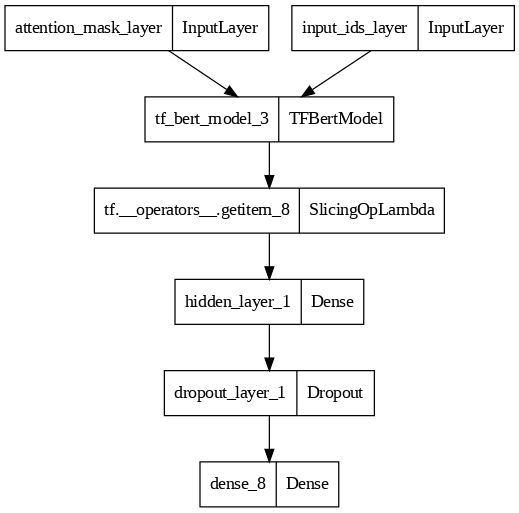

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 178s 838ms/step - loss: 1.3027 - MCRMSE: 1.3010 - val_loss: 0.5881 - val_MCRMSE: 0.5869
Epoch 2/10
196/196 [==============================] - 165s 842ms/step - loss: 0.7769 - MCRMSE: 0.7767 - val_loss: 0.5483 - val_MCRMSE: 0.5475
Epoch 3/10
196/196 [==============================] - 165s 843ms/step - loss: 0.7206 - MCRMSE: 0.7207 - val_loss: 0.5197 - val_MCRMSE: 0.5190
Epoch 4/10
196/196 [==============================] - 165s 841ms/step - loss: 0.6781 - MCRMSE: 0.6779 - val_loss: 0.5091 - val_MCRMSE: 0.5086
Epoch 5/10
196/196 [==============================] - 165s 841ms/step - loss: 0.6552 - MCRMSE: 0.6551 - val_loss: 0.4989 - val_MCRMSE: 0.4985
Epoch 6/10
196/196 [==============================] - 160s 817ms/step - loss: 0.6289 - MCRMSE: 0.6290 - val_loss: 0.4952 - val_MCRMSE: 0.4953
Epoch 7/10
196/196 [==============================] - 160s 816ms/step - loss: 0.6241 - MCRMSE: 0.6240 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        1.302655  0.776895  0.720568  0.678072  0.655221  0.628893  0.624097  0.614837  0.603122  0.595849
MCRMSE      1.301047  0.776708  0.720707  0.677938  0.655132  0.629002  0.624032  0.615142  0.603154  0.595855
val_loss    0.588121  0.548295  0.519688  0.509070  0.498890  0.495216  0.490829  0.485106  0.503884  0.481056
val_MCRMSE  0.586923  0.547479  0.519013  0.508590  0.498492  0.495262  0.490724  0.485250  0.504901  0.481367


Plotting loss and MCRMSE...


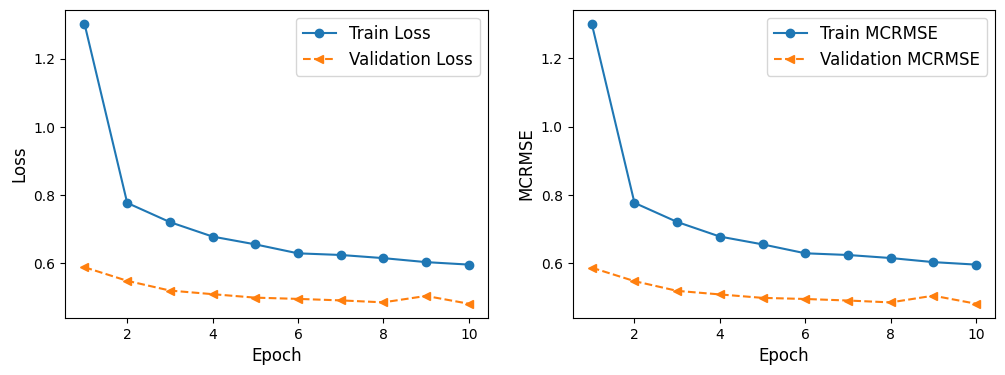

13/13 [==============================] - 16s 1s/step - loss: 0.4860 - MCRMSE: 0.4827

Evaluate Test Metrics:

Test loss: 0.4860

Test MCRMSE score: 0.4827 

13/13 [==============================] - 20s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 6
******************************************************

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

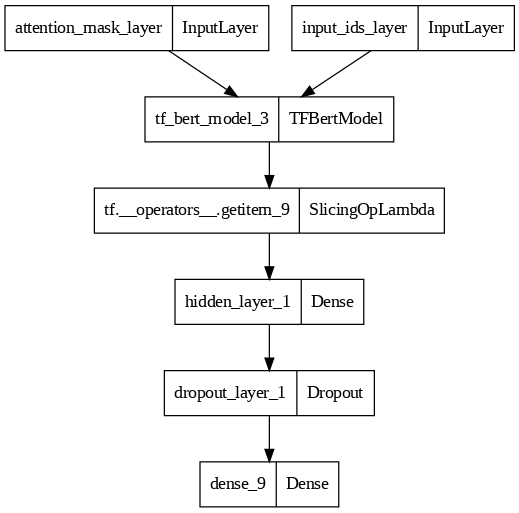

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 178s 855ms/step - loss: 1.0668 - MCRMSE: 1.0662 - val_loss: 0.5829 - val_MCRMSE: 0.5820
Epoch 2/10
196/196 [==============================] - 165s 842ms/step - loss: 0.7543 - MCRMSE: 0.7542 - val_loss: 0.5379 - val_MCRMSE: 0.5376
Epoch 3/10
196/196 [==============================] - 165s 840ms/step - loss: 0.7017 - MCRMSE: 0.7014 - val_loss: 0.5142 - val_MCRMSE: 0.5142
Epoch 4/10
196/196 [==============================] - 165s 840ms/step - loss: 0.6620 - MCRMSE: 0.6616 - val_loss: 0.4989 - val_MCRMSE: 0.4990
Epoch 5/10
196/196 [==============================] - 165s 841ms/step - loss: 0.6427 - MCRMSE: 0.6426 - val_loss: 0.4878 - val_MCRMSE: 0.4878
Epoch 6/10
196/196 [==============================] - 163s 831ms/step - loss: 0.6276 - MCRMSE: 0.6274 - val_loss: 0.4920 - val_MCRMSE: 0.4926
Epoch 7/10
196/196 [==============================] - 165s 840ms/step - loss: 0.6189 - MCRMSE: 0.6188 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        1.066849  0.754315  0.701708  0.662042  0.642722  0.627568  0.618888  0.605120  0.596188  0.595106
MCRMSE      1.066186  0.754207  0.701434  0.661619  0.642644  0.627378  0.618800  0.604987  0.595788  0.595100
val_loss    0.582896  0.537910  0.514240  0.498895  0.487782  0.492019  0.478907  0.475434  0.481514  0.473228
val_MCRMSE  0.582010  0.537616  0.514194  0.499032  0.487830  0.492568  0.479317  0.475616  0.482408  0.473574


Plotting loss and MCRMSE...


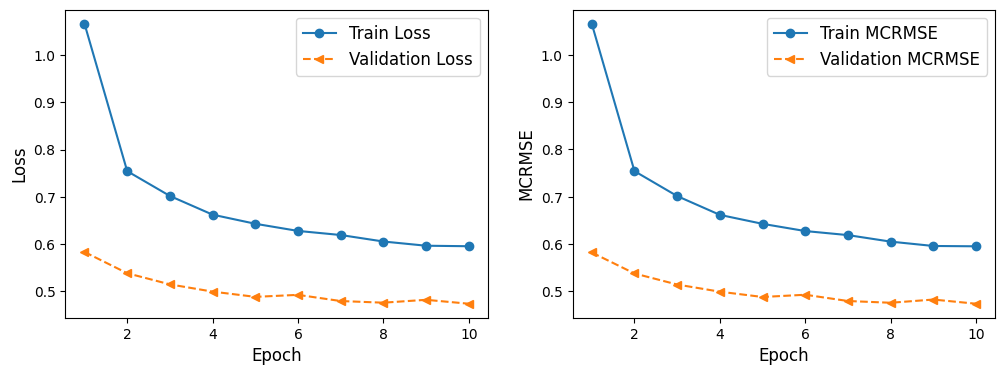

13/13 [==============================] - 16s 1s/step - loss: 0.4789 - MCRMSE: 0.4752

Evaluate Test Metrics:

Test loss: 0.4789

Test MCRMSE score: 0.4752 

13/13 [==============================] - 22s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 12
******************************************************

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
             

None

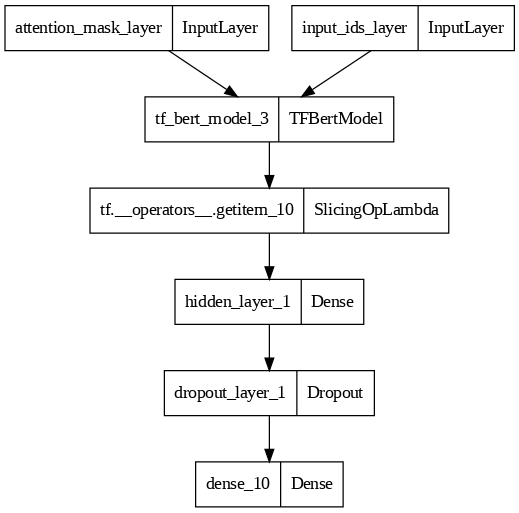

Training Regression with BERT.....
Epoch 1/10


196/196 [==============================] - 308s 1s/step - loss: 0.7579 - MCRMSE: 0.7581 - val_loss: 0.5322 - val_MCRMSE: 0.5363
Epoch 2/10
196/196 [==============================] - 279s 1s/step - loss: 0.6495 - MCRMSE: 0.6492 - val_loss: 0.4497 - val_MCRMSE: 0.4499
Epoch 3/10
196/196 [==============================] - 272s 1s/step - loss: 0.6232 - MCRMSE: 0.6231 - val_loss: 0.4634 - val_MCRMSE: 0.4661
Epoch 4/10
196/196 [==============================] - 275s 1s/step - loss: 0.6053 - MCRMSE: 0.6049 - val_loss: 0.4463 - val_MCRMSE: 0.4469
Epoch 5/10
196/196 [==============================] - 272s 1s/step - loss: 0.5938 - MCRMSE: 0.5938 - val_loss: 0.4568 - val_MCRMSE: 0.4563
Epoch 6/10
196/196 [==============================] - 272s 1s/step - loss: 0.5678 - MCRMSE: 0.5678 - val_loss: 0.4505 - val_MCRMSE: 0.4519
Epoch 7/10
196/196 [==============================] - 272s 1s/step - loss: 0.5495 - MCRMSE: 0.5496 - val_loss: 0.4794 - val_MCRMSE: 0.4817
Epoch 8/10
196/196 [==================

0         1         2         3         4         5         6         7         8         9
loss        0.757895  0.649477  0.623220  0.605276  0.593828  0.567777  0.549523  0.531401  0.521677  0.509407
MCRMSE      0.758115  0.649231  0.623134  0.604943  0.593760  0.567808  0.549608  0.531475  0.521503  0.509126
val_loss    0.532243  0.449742  0.463382  0.446280  0.456797  0.450507  0.479417  0.449861  0.470952  0.465608
val_MCRMSE  0.536269  0.449879  0.466077  0.446872  0.456273  0.451927  0.481729  0.449217  0.471308  0.468074


Plotting loss and MCRMSE...


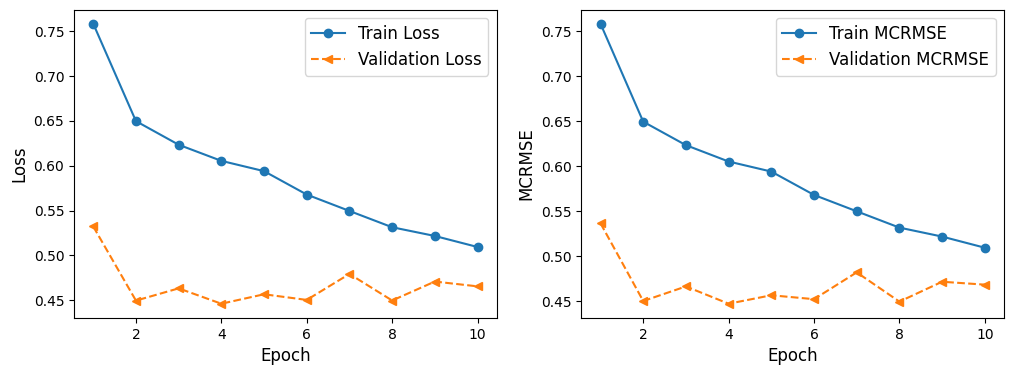

13/13 [==============================] - 16s 1s/step - loss: 0.4854 - MCRMSE: 0.4839

Evaluate Test Metrics:

Test loss: 0.4854

Test MCRMSE score: 0.4839 

13/13 [==============================] - 19s 1s/step


NLP Model  Num_Trainable_layers Trainable_Params Non-Trainable_Params  Epochs Optimizer  Test_MCRMSE  Test_Loss  Train_MCRMSE  Train_Loss  Val_MCRMSE  Val_Loss  \
0  bert-base-cased                     0          198,406          108,310,272      10      adam       0.4827     0.4860        0.5959      0.5958      0.4814    0.4811   
1  bert-base-cased                     6          198,406          108,310,272      10      adam       0.4752     0.4789        0.5951      0.5951      0.4736    0.4732   
2  bert-base-cased                    12      108,508,678                    0      10      adam       0.4839     0.4854        0.5091      0.5094      0.4681    0.4656   

   Learning_Rate  Num_Hidden_Layers  Num_hidden_Units  Dropout  Batch_Size  
0        0.00005                  1               256      0.3          16  
1        0.00005                  1               256      0.3          16  
2        0.00005                  1               256      0.3          16

In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,13,6),
                          # num_hidden_layer=1,
                          # num_hidden_units=256,
                          # dropout=0.3,
                          # learning_rate=0.00005,
                          batch_size=16,
                          activation='relu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_4.csv')


******************************************************
Regression with BERT: Number of Unfrozen Layers = 0
******************************************************

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                           

None

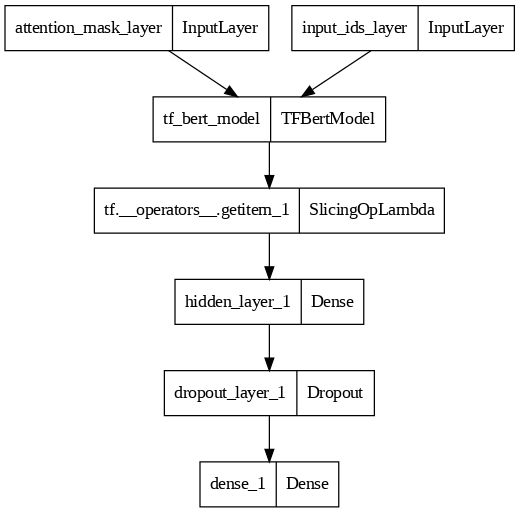

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 182s 857ms/step - loss: 1.2149 - MCRMSE: 1.2137 - val_loss: 0.5787 - val_MCRMSE: 0.5787
Epoch 2/10
196/196 [==============================] - 165s 842ms/step - loss: 0.7274 - MCRMSE: 0.7274 - val_loss: 0.5314 - val_MCRMSE: 0.5311
Epoch 3/10
196/196 [==============================] - 165s 840ms/step - loss: 0.6586 - MCRMSE: 0.6585 - val_loss: 0.5101 - val_MCRMSE: 0.5092
Epoch 4/10
196/196 [==============================] - 165s 844ms/step - loss: 0.6190 - MCRMSE: 0.6188 - val_loss: 0.4843 - val_MCRMSE: 0.4837
Epoch 5/10
196/196 [==============================] - 163s 832ms/step - loss: 0.6065 - MCRMSE: 0.6063 - val_loss: 0.4866 - val_MCRMSE: 0.4859
Epoch 6/10
196/196 [==============================] - 165s 840ms/step - loss: 0.5916 - MCRMSE: 0.5916 - val_loss: 0.4823 - val_MCRMSE: 0.4817
Epoch 7/10
196/196 [==============================] - 160s 819ms/step - loss: 0.5829 - MCRMSE: 0.5828 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        1.214936  0.727374  0.658634  0.619048  0.606490  0.591577  0.582862  0.571196  0.569065  0.560199
MCRMSE      1.213707  0.727405  0.658528  0.618849  0.606311  0.591619  0.582812  0.571121  0.569455  0.559908
val_loss    0.578723  0.531352  0.510064  0.484304  0.486630  0.482333  0.479535  0.469896  0.470328  0.461939
val_MCRMSE  0.578714  0.531056  0.509152  0.483745  0.485902  0.481711  0.478908  0.469501  0.469817  0.461698


Plotting loss and MCRMSE...


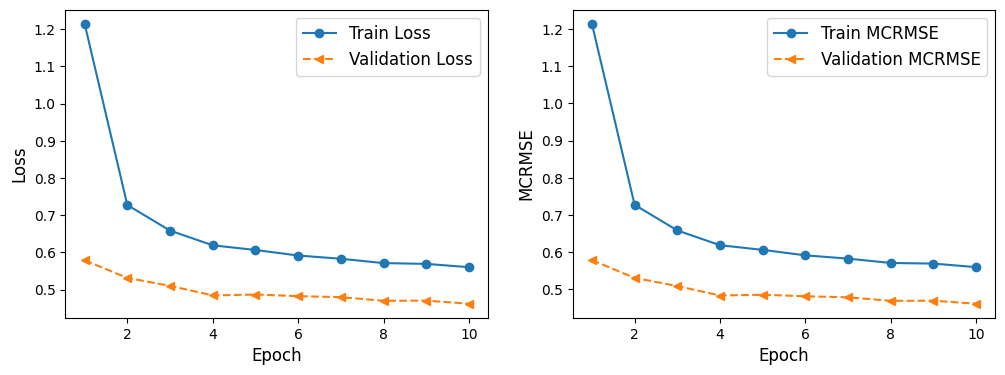

13/13 [==============================] - 16s 1s/step - loss: 0.4846 - MCRMSE: 0.4804

Evaluate Test Metrics:

Test loss: 0.4846

Test MCRMSE score: 0.4804 

13/13 [==============================] - 20s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 6
******************************************************

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

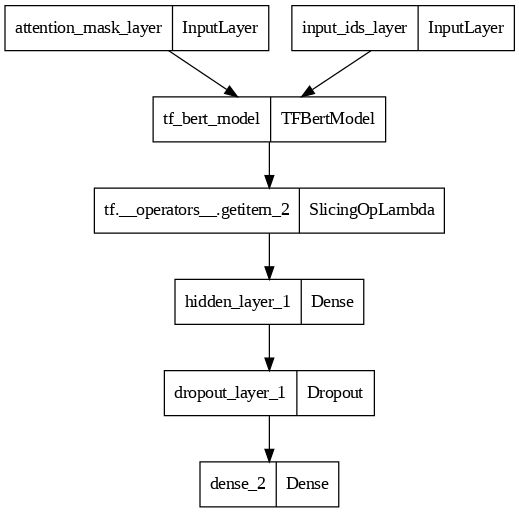

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 173s 832ms/step - loss: 1.3086 - MCRMSE: 1.3073 - val_loss: 0.5862 - val_MCRMSE: 0.5864
Epoch 2/10
196/196 [==============================] - 165s 843ms/step - loss: 0.7350 - MCRMSE: 0.7348 - val_loss: 0.5411 - val_MCRMSE: 0.5406
Epoch 3/10
196/196 [==============================] - 165s 843ms/step - loss: 0.6721 - MCRMSE: 0.6722 - val_loss: 0.5215 - val_MCRMSE: 0.5202
Epoch 4/10
196/196 [==============================] - 165s 843ms/step - loss: 0.6339 - MCRMSE: 0.6334 - val_loss: 0.4897 - val_MCRMSE: 0.4891
Epoch 5/10
196/196 [==============================] - 160s 818ms/step - loss: 0.6168 - MCRMSE: 0.6167 - val_loss: 0.4840 - val_MCRMSE: 0.4832
Epoch 6/10
196/196 [==============================] - 163s 831ms/step - loss: 0.5950 - MCRMSE: 0.5951 - val_loss: 0.4844 - val_MCRMSE: 0.4835
Epoch 7/10
196/196 [==============================] - 165s 843ms/step - loss: 0.5929 - MCRMSE: 0.5929 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        1.308598  0.734966  0.672115  0.633853  0.616755  0.595019  0.592891  0.578275  0.570130  0.566971
MCRMSE      1.307323  0.734833  0.672218  0.633413  0.616697  0.595131  0.592910  0.578308  0.570751  0.566694
val_loss    0.586228  0.541128  0.521517  0.489668  0.484047  0.484445  0.483869  0.477005  0.479745  0.465279
val_MCRMSE  0.586440  0.540602  0.520154  0.489073  0.483245  0.483504  0.483067  0.476323  0.479065  0.464957


Plotting loss and MCRMSE...


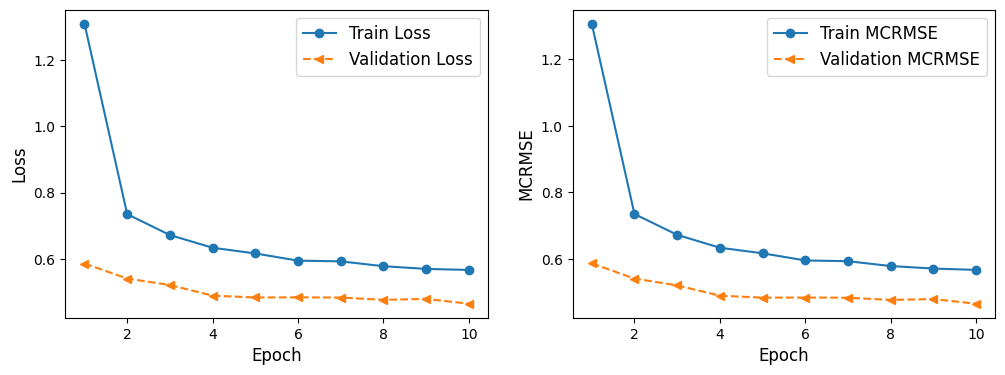

13/13 [==============================] - 16s 1s/step - loss: 0.4855 - MCRMSE: 0.4792

Evaluate Test Metrics:

Test loss: 0.4855

Test MCRMSE score: 0.4792 

13/13 [==============================] - 19s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 12
******************************************************

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
              

None

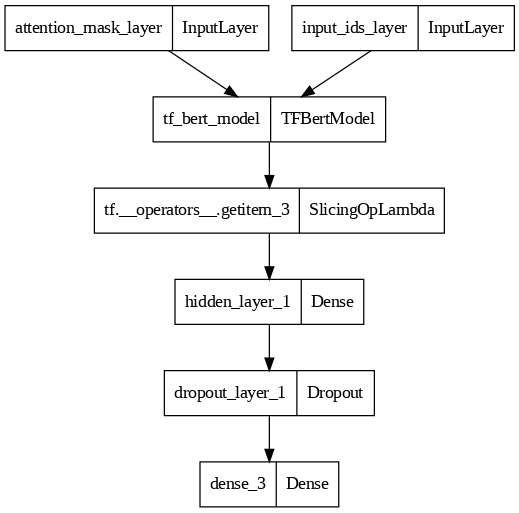

Training Regression with BERT.....
Epoch 1/10


196/196 [==============================] - 312s 1s/step - loss: 0.7350 - MCRMSE: 0.7345 - val_loss: 0.4591 - val_MCRMSE: 0.4590
Epoch 2/10
196/196 [==============================] - 273s 1s/step - loss: 0.6100 - MCRMSE: 0.6100 - val_loss: 0.4609 - val_MCRMSE: 0.4608
Epoch 3/10
196/196 [==============================] - 279s 1s/step - loss: 0.5760 - MCRMSE: 0.5758 - val_loss: 0.4415 - val_MCRMSE: 0.4415
Epoch 4/10
196/196 [==============================] - 268s 1s/step - loss: 0.5595 - MCRMSE: 0.5595 - val_loss: 0.4422 - val_MCRMSE: 0.4424
Epoch 5/10
196/196 [==============================] - 273s 1s/step - loss: 0.5326 - MCRMSE: 0.5328 - val_loss: 0.4569 - val_MCRMSE: 0.4572
Epoch 6/10
196/196 [==============================] - 273s 1s/step - loss: 0.5160 - MCRMSE: 0.5162 - val_loss: 0.4549 - val_MCRMSE: 0.4554
Epoch 7/10
196/196 [==============================] - 273s 1s/step - loss: 0.4984 - MCRMSE: 0.4984 - val_loss: 0.4597 - val_MCRMSE: 0.4605
Epoch 8/10
196/196 [==================

0         1         2         3         4         5         6         7         8         9
loss        0.735047  0.609994  0.575966  0.559488  0.532606  0.516029  0.498396  0.478874  0.460236  0.456103
MCRMSE      0.734528  0.610033  0.575849  0.559535  0.532755  0.516155  0.498446  0.478987  0.460197  0.456029
val_loss    0.459074  0.460881  0.441491  0.442167  0.456905  0.454884  0.459659  0.481966  0.494160  0.466070
val_MCRMSE  0.458980  0.460834  0.441493  0.442404  0.457188  0.455405  0.460458  0.482662  0.493665  0.465268


Plotting loss and MCRMSE...


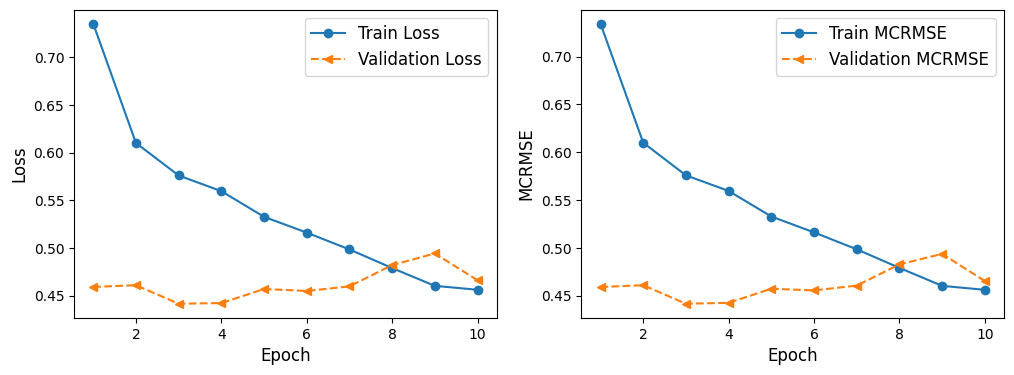

13/13 [==============================] - 16s 1s/step - loss: 0.4855 - MCRMSE: 0.4816

Evaluate Test Metrics:

Test loss: 0.4855

Test MCRMSE score: 0.4816 



In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,13,6),
                          # num_hidden_layer=1,
                          # num_hidden_units=256,
                          # dropout=0.3,
                          # learning_rate=0.00005,
                          batch_size=16,
                          activation='gelu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_batch16_gelu.csv')


******************************************************
Regression with BERT: Number of Unfrozen Layers = 0
******************************************************

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                             

None

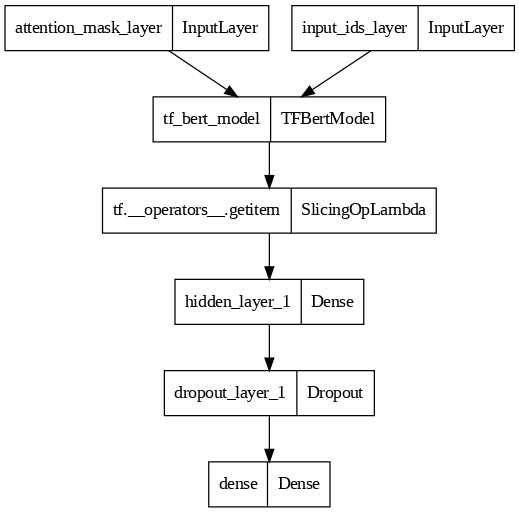

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 178s 836ms/step - loss: 1.2492 - MCRMSE: 1.2482 - val_loss: 0.5777 - val_MCRMSE: 0.5782
Epoch 2/10
196/196 [==============================] - 162s 825ms/step - loss: 0.7560 - MCRMSE: 0.7559 - val_loss: 0.5307 - val_MCRMSE: 0.5308
Epoch 3/10
196/196 [==============================] - 157s 799ms/step - loss: 0.6728 - MCRMSE: 0.6727 - val_loss: 0.5136 - val_MCRMSE: 0.5130
Epoch 4/10
196/196 [==============================] - 162s 828ms/step - loss: 0.6321 - MCRMSE: 0.6320 - val_loss: 0.4807 - val_MCRMSE: 0.4807
Epoch 5/10
196/196 [==============================] - 162s 826ms/step - loss: 0.6137 - MCRMSE: 0.6135 - val_loss: 0.4787 - val_MCRMSE: 0.4785
Epoch 6/10
196/196 [==============================] - 160s 815ms/step - loss: 0.5986 - MCRMSE: 0.5985 - val_loss: 0.4807 - val_MCRMSE: 0.4804
Epoch 7/10
196/196 [==============================] - 161s 824ms/step - loss: 0.5840 - MCRMSE: 0.5840 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        1.249227  0.755993  0.672789  0.632114  0.613663  0.598551  0.583993  0.578073  0.573448  0.562552
MCRMSE      1.248158  0.755942  0.672724  0.631997  0.613538  0.598519  0.583959  0.578038  0.573624  0.562300
val_loss    0.577718  0.530654  0.513588  0.480656  0.478708  0.480737  0.476151  0.468511  0.466885  0.462303
val_MCRMSE  0.578192  0.530823  0.512998  0.480713  0.478501  0.480427  0.476071  0.468689  0.466944  0.462578


Plotting loss and MCRMSE...


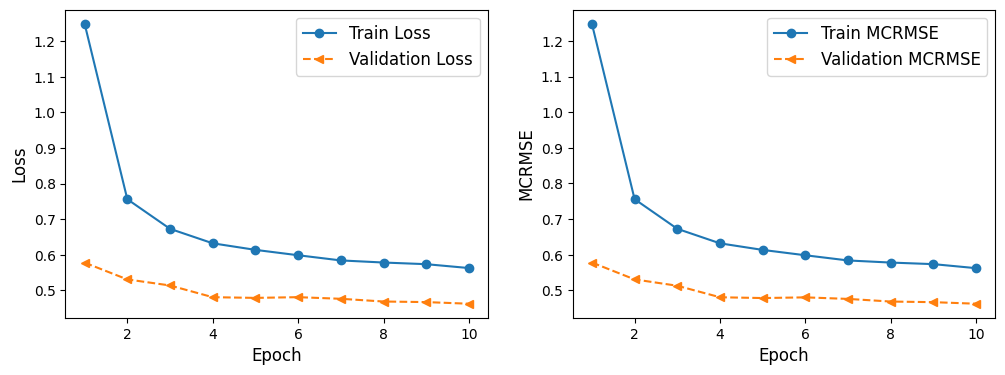

13/13 [==============================] - 15s 1s/step - loss: 0.4856 - MCRMSE: 0.4804

Evaluate Test Metrics:

Test loss: 0.4856

Test MCRMSE score: 0.4804 

13/13 [==============================] - 19s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 2
******************************************************

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

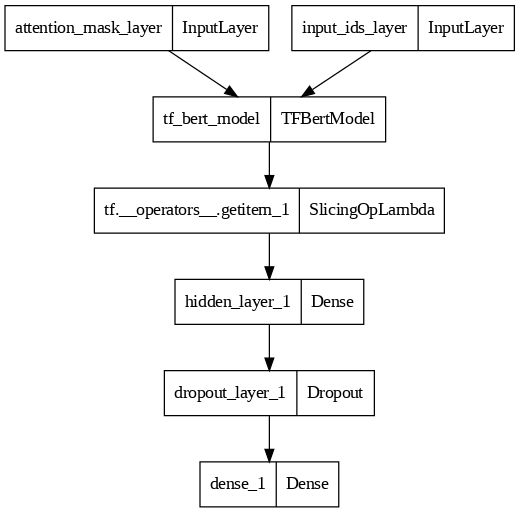

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 167s 818ms/step - loss: 1.3267 - MCRMSE: 1.3257 - val_loss: 0.5896 - val_MCRMSE: 0.5908
Epoch 2/10
196/196 [==============================] - 162s 826ms/step - loss: 0.7510 - MCRMSE: 0.7509 - val_loss: 0.5373 - val_MCRMSE: 0.5386
Epoch 3/10
196/196 [==============================] - 162s 828ms/step - loss: 0.6845 - MCRMSE: 0.6842 - val_loss: 0.5118 - val_MCRMSE: 0.5116
Epoch 4/10
196/196 [==============================] - 162s 826ms/step - loss: 0.6411 - MCRMSE: 0.6406 - val_loss: 0.4875 - val_MCRMSE: 0.4875
Epoch 5/10
196/196 [==============================] - 162s 826ms/step - loss: 0.6180 - MCRMSE: 0.6179 - val_loss: 0.4833 - val_MCRMSE: 0.4828
Epoch 6/10
196/196 [==============================] - 162s 825ms/step - loss: 0.6018 - MCRMSE: 0.6018 - val_loss: 0.4790 - val_MCRMSE: 0.4783
Epoch 7/10
196/196 [==============================] - 155s 789ms/step - loss: 0.5908 - MCRMSE: 0.5908 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        1.326679  0.750974  0.684485  0.641077  0.618007  0.601798  0.590827  0.577027  0.571431  0.563038
MCRMSE      1.325680  0.750934  0.684222  0.640641  0.617908  0.601775  0.590796  0.576906  0.571632  0.562798
val_loss    0.589590  0.537330  0.511834  0.487462  0.483308  0.479014  0.491236  0.473861  0.469226  0.461557
val_MCRMSE  0.590763  0.538642  0.511604  0.487457  0.482760  0.478271  0.490290  0.473097  0.468560  0.461150


Plotting loss and MCRMSE...


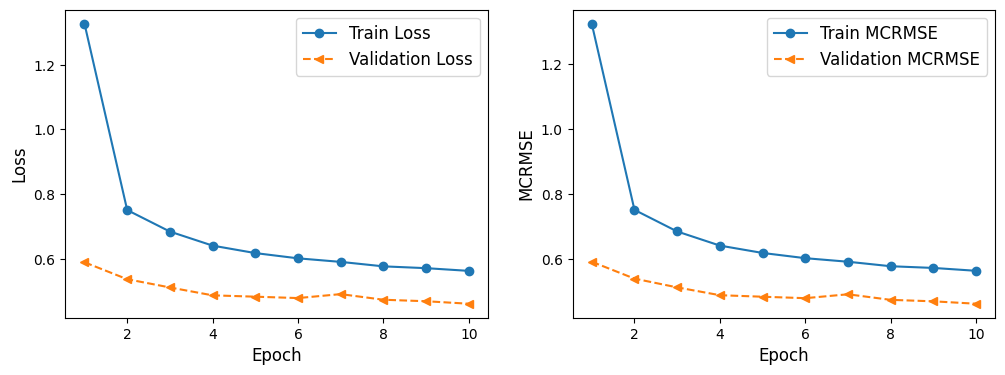

13/13 [==============================] - 15s 1s/step - loss: 0.4840 - MCRMSE: 0.4790

Evaluate Test Metrics:

Test loss: 0.4840

Test MCRMSE score: 0.4790 

13/13 [==============================] - 20s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 4
******************************************************

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

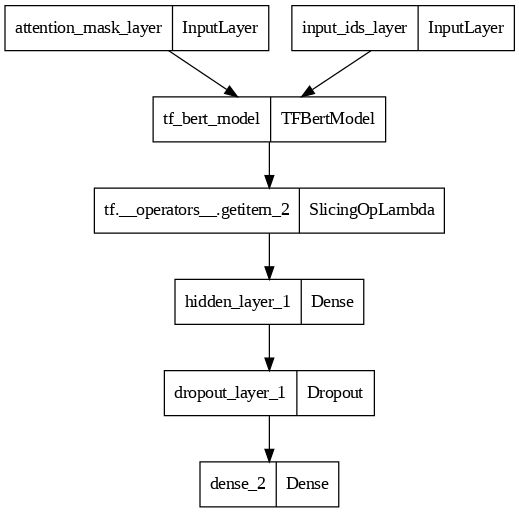

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 168s 814ms/step - loss: 1.3868 - MCRMSE: 1.3853 - val_loss: 0.5846 - val_MCRMSE: 0.5866
Epoch 2/10
196/196 [==============================] - 162s 827ms/step - loss: 0.7481 - MCRMSE: 0.7481 - val_loss: 0.5374 - val_MCRMSE: 0.5384
Epoch 3/10
196/196 [==============================] - 162s 826ms/step - loss: 0.6741 - MCRMSE: 0.6742 - val_loss: 0.5132 - val_MCRMSE: 0.5130
Epoch 4/10
196/196 [==============================] - 162s 827ms/step - loss: 0.6363 - MCRMSE: 0.6359 - val_loss: 0.4871 - val_MCRMSE: 0.4876
Epoch 5/10
196/196 [==============================] - 162s 826ms/step - loss: 0.6100 - MCRMSE: 0.6099 - val_loss: 0.4791 - val_MCRMSE: 0.4791
Epoch 6/10
196/196 [==============================] - 157s 800ms/step - loss: 0.5963 - MCRMSE: 0.5963 - val_loss: 0.4755 - val_MCRMSE: 0.4754
Epoch 7/10
196/196 [==============================] - 160s 815ms/step - loss: 0.5828 - MCRMSE: 0.5829 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        1.386774  0.748065  0.674136  0.636297  0.609998  0.596259  0.582762  0.572452  0.565565  0.563688
MCRMSE      1.385264  0.748075  0.674204  0.635910  0.609881  0.596347  0.582927  0.572563  0.565703  0.563558
val_loss    0.584610  0.537393  0.513199  0.487117  0.479121  0.475544  0.483856  0.468760  0.468834  0.460781
val_MCRMSE  0.586605  0.538436  0.513036  0.487605  0.479104  0.475423  0.483473  0.468672  0.468847  0.460966


Plotting loss and MCRMSE...


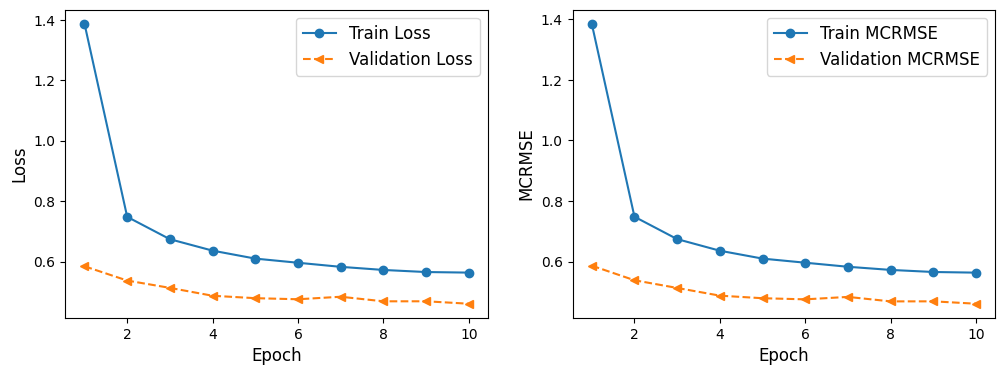

13/13 [==============================] - 15s 1s/step - loss: 0.4813 - MCRMSE: 0.4761

Evaluate Test Metrics:

Test loss: 0.4813

Test MCRMSE score: 0.4761 

13/13 [==============================] - 19s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 6
******************************************************

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

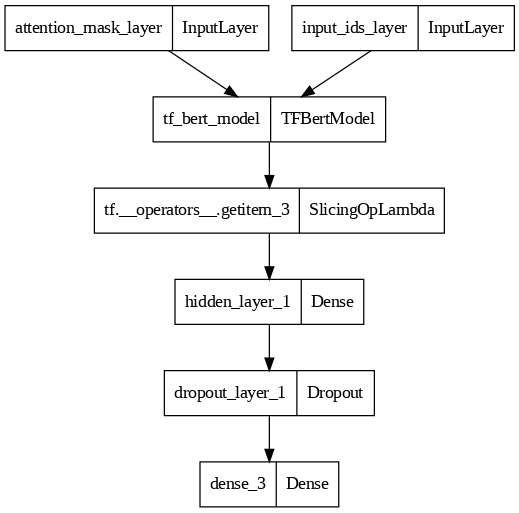

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 167s 816ms/step - loss: 1.1489 - MCRMSE: 1.1479 - val_loss: 0.5848 - val_MCRMSE: 0.5845
Epoch 2/10
196/196 [==============================] - 162s 826ms/step - loss: 0.7348 - MCRMSE: 0.7344 - val_loss: 0.5304 - val_MCRMSE: 0.5299
Epoch 3/10
196/196 [==============================] - 162s 825ms/step - loss: 0.6636 - MCRMSE: 0.6637 - val_loss: 0.5060 - val_MCRMSE: 0.5049
Epoch 4/10
196/196 [==============================] - 162s 828ms/step - loss: 0.6228 - MCRMSE: 0.6227 - val_loss: 0.4854 - val_MCRMSE: 0.4847
Epoch 5/10
196/196 [==============================] - 160s 815ms/step - loss: 0.6078 - MCRMSE: 0.6077 - val_loss: 0.4865 - val_MCRMSE: 0.4857
Epoch 6/10
196/196 [==============================] - 162s 826ms/step - loss: 0.5943 - MCRMSE: 0.5946 - val_loss: 0.4852 - val_MCRMSE: 0.4845
Epoch 7/10
196/196 [==============================] - 162s 827ms/step - loss: 0.5800 - MCRMSE: 0.5799 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        1.148882  0.734771  0.663636  0.622816  0.607800  0.594325  0.580019  0.572637  0.564864  0.557869
MCRMSE      1.147872  0.734432  0.663695  0.622747  0.607723  0.594559  0.579869  0.572765  0.565187  0.557416
val_loss    0.584849  0.530383  0.506038  0.485448  0.486503  0.485213  0.474675  0.468936  0.468374  0.464170
val_MCRMSE  0.584522  0.529901  0.504862  0.484670  0.485691  0.484524  0.474203  0.468702  0.468225  0.464005


Plotting loss and MCRMSE...


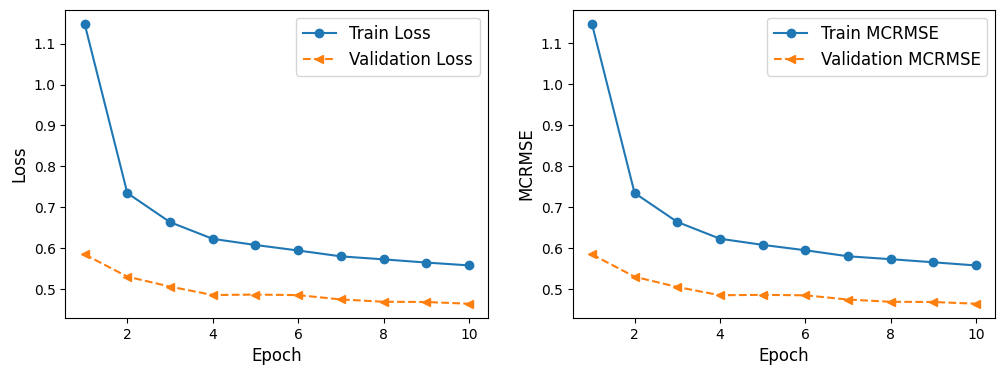

13/13 [==============================] - 15s 1s/step - loss: 0.4835 - MCRMSE: 0.4789

Evaluate Test Metrics:

Test loss: 0.4835

Test MCRMSE score: 0.4789 

13/13 [==============================] - 20s 1s/step


NLP Model  Num_Trainable_layers  Epochs  Test_MCRMSE  Test_Loss  Train_MCRMSE  Train_Loss  Val_MCRMSE  Val_Loss Optimizer  Activation  Learning_Rate  Num_Hidden_Layers  \
0  bert-base-cased                     0      10       0.4804     0.4856        0.5623      0.5626      0.4626    0.4623      adam  leaky_relu        0.00005                  1   
1  bert-base-cased                     2      10       0.4790     0.4840        0.5628      0.5630      0.4612    0.4616      adam  leaky_relu        0.00005                  1   
2  bert-base-cased                     4      10       0.4761     0.4813        0.5636      0.5637      0.4610    0.4608      adam  leaky_relu        0.00005                  1   
3  bert-base-cased                     6      10       0.4789     0.4835        0.5574      0.5579      0.4640    0.4642      adam  leaky_relu        0.00005                  1   

   Num_hidden_Units  Dropout  Batch_Size  
0               256      0.3          16  
1               256      0.3          16  
2               256      0.3          16  
3               256      0.3          16

In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,7,2),
                          # num_hidden_layer=1,
                          # num_hidden_units=256,
                          # dropout=0.3,
                          # learning_rate=0.00005,
                          batch_size=16,
                          activation='leaky_relu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_batch16_leakyRelu.csv')


******************************************************
Regression with BERT: Number of Unfrozen Layers = 2
******************************************************

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                             

None

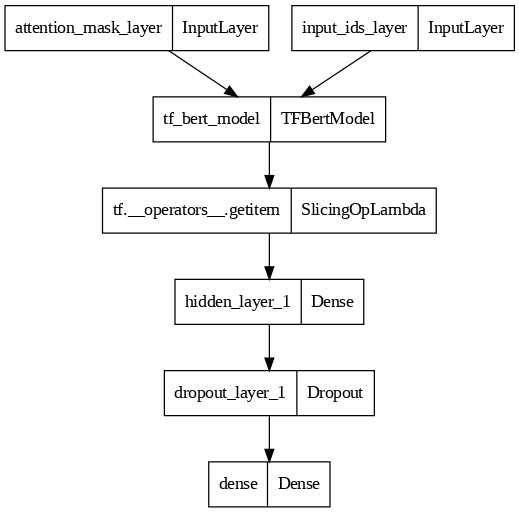

Training Regression with BERT.....
Epoch 1/10


196/196 [==============================] - 225s 1s/step - loss: 0.6489 - MCRMSE: 0.6483 - val_loss: 0.4967 - val_MCRMSE: 0.4957
Epoch 2/10
196/196 [==============================] - 209s 1s/step - loss: 0.5365 - MCRMSE: 0.5366 - val_loss: 0.4835 - val_MCRMSE: 0.4834
Epoch 3/10
196/196 [==============================] - 209s 1s/step - loss: 0.5192 - MCRMSE: 0.5193 - val_loss: 0.4581 - val_MCRMSE: 0.4580
Epoch 4/10
196/196 [==============================] - 209s 1s/step - loss: 0.5075 - MCRMSE: 0.5074 - val_loss: 0.4473 - val_MCRMSE: 0.4479
Epoch 5/10
196/196 [==============================] - 202s 1s/step - loss: 0.4942 - MCRMSE: 0.4943 - val_loss: 0.4589 - val_MCRMSE: 0.4593
Epoch 6/10
196/196 [==============================] - 204s 1s/step - loss: 0.4906 - MCRMSE: 0.4906 - val_loss: 0.4420 - val_MCRMSE: 0.4437
Epoch 7/10
196/196 [==============================] - 202s 1s/step - loss: 0.4805 - MCRMSE: 0.4803 - val_loss: 0.4967 - val_MCRMSE: 0.4968
Epoch 8/10
196/196 [==================

0         1         2         3         4         5         6         7         8         9
loss        0.648856  0.536480  0.519226  0.507470  0.494218  0.490559  0.480538  0.465443  0.460441  0.442848
MCRMSE      0.648337  0.536568  0.519307  0.507402  0.494305  0.490587  0.480339  0.465374  0.460614  0.442826
val_loss    0.496679  0.483533  0.458070  0.447292  0.458921  0.441955  0.496698  0.504249  0.454188  0.492590
val_MCRMSE  0.495666  0.483437  0.458007  0.447930  0.459328  0.443671  0.496844  0.504811  0.455684  0.493406


Plotting loss and MCRMSE...


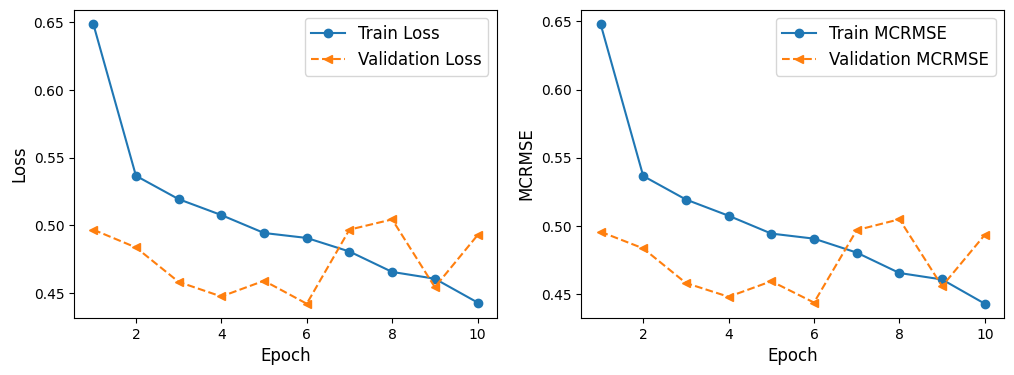

13/13 [==============================] - 17s 1s/step - loss: 0.5092 - MCRMSE: 0.5088

Evaluate Test Metrics:

Test loss: 0.5092

Test MCRMSE score: 0.5088 

13/13 [==============================] - 20s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 4
******************************************************

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

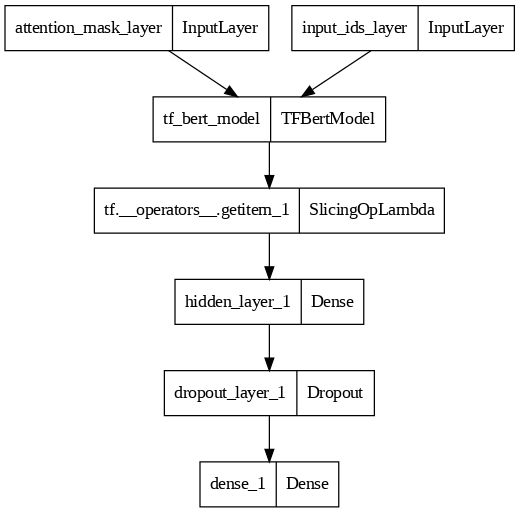

Training Regression with BERT.....
Epoch 1/10


196/196 [==============================] - 224s 1s/step - loss: 0.6621 - MCRMSE: 0.6615 - val_loss: 0.4818 - val_MCRMSE: 0.4817
Epoch 2/10
196/196 [==============================] - 202s 1s/step - loss: 0.4919 - MCRMSE: 0.4920 - val_loss: 0.5228 - val_MCRMSE: 0.5220
Epoch 3/10
196/196 [==============================] - 208s 1s/step - loss: 0.4649 - MCRMSE: 0.4647 - val_loss: 0.4749 - val_MCRMSE: 0.4748
Epoch 4/10
196/196 [==============================] - 208s 1s/step - loss: 0.4506 - MCRMSE: 0.4506 - val_loss: 0.4657 - val_MCRMSE: 0.4675
Epoch 5/10
196/196 [==============================] - 201s 1s/step - loss: 0.4394 - MCRMSE: 0.4393 - val_loss: 0.5014 - val_MCRMSE: 0.5026
Epoch 6/10
196/196 [==============================] - 202s 1s/step - loss: 0.4151 - MCRMSE: 0.4150 - val_loss: 0.5085 - val_MCRMSE: 0.5091
Epoch 8/10
196/196 [==============================] - 201s 1s/step - loss: 0.4058 - MCRMSE: 0.4056 - val_loss: 0.4971 - val_MCRMSE: 0.4976
Epoch 9/10
196/196 [==================

0         1         2         3         4         5         6         7         8         9
loss        0.662079  0.491944  0.464857  0.450637  0.439356  0.428764  0.415090  0.405788  0.395847  0.390122
MCRMSE      0.661511  0.491996  0.464692  0.450649  0.439316  0.428823  0.415043  0.405644  0.395738  0.390232
val_loss    0.481845  0.522770  0.474865  0.465706  0.501374  0.462917  0.508519  0.497137  0.477567  0.550969
val_MCRMSE  0.481660  0.522014  0.474817  0.467487  0.502568  0.463769  0.509052  0.497649  0.477999  0.551332


Plotting loss and MCRMSE...


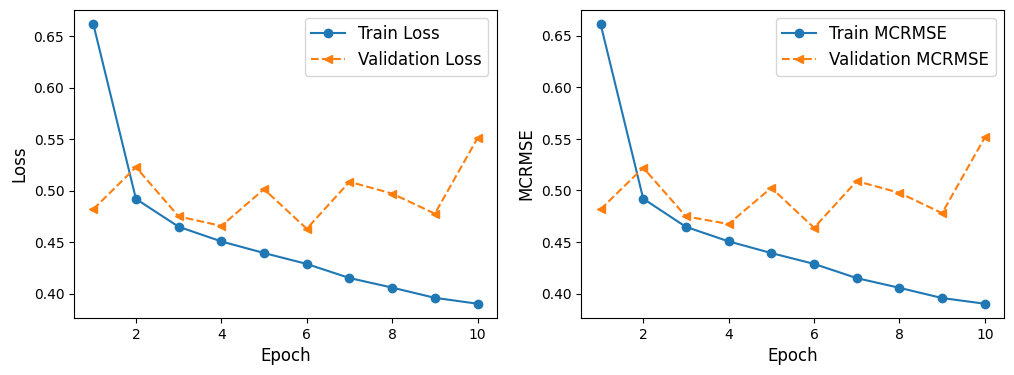

13/13 [==============================] - 17s 1s/step - loss: 0.5635 - MCRMSE: 0.5667

Evaluate Test Metrics:

Test loss: 0.5635

Test MCRMSE score: 0.5667 

13/13 [==============================] - 21s 1s/step


NLP Model  Num_Trainable_layers  Epochs  Test_MCRMSE  Test_Loss  Train_MCRMSE  Train_Loss  Val_MCRMSE  Val_Loss Optimizer Activation  Learning_Rate  Num_Hidden_Layers  \
0  bert-base-cased                     2      10       0.5088     0.5092        0.4428      0.4428      0.4934    0.4926      adam       relu        0.00005                  1   
1  bert-base-cased                     4      10       0.5667     0.5635        0.3902      0.3901      0.5513    0.5510      adam       relu        0.00005                  1   

   Num_hidden_Units  Dropout  Batch_Size  
0               256      0.1          16  
1               256      0.1          16

In [ ]:
run_regression_experiment(num_train_layers=np.arange(2,5,2),
# run_regression_experiment(num_train_layers=np.arange(0,9,2),
                          # num_hidden_layer=1,
                          # num_hidden_units=256,
                          dropout=0.1,
                          # learning_rate=0.00005,
                          batch_size=16,
                          activation='relu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_batch16_leakyRelu.csv')


******************************************************
Regression with BERT: Number of Unfrozen Layers = 0
******************************************************

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                           

None

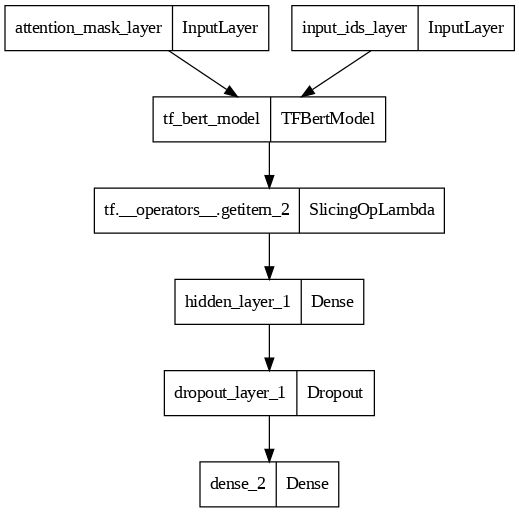

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 192s 861ms/step - loss: 1.0519 - MCRMSE: 1.0511 - val_loss: 0.5758 - val_MCRMSE: 0.5757
Epoch 2/10
196/196 [==============================] - 169s 864ms/step - loss: 0.6861 - MCRMSE: 0.6859 - val_loss: 0.5247 - val_MCRMSE: 0.5242
Epoch 3/10
196/196 [==============================] - 165s 843ms/step - loss: 0.6332 - MCRMSE: 0.6333 - val_loss: 0.5061 - val_MCRMSE: 0.5051
Epoch 4/10
196/196 [==============================] - 169s 864ms/step - loss: 0.5985 - MCRMSE: 0.5983 - val_loss: 0.4775 - val_MCRMSE: 0.4773
Epoch 5/10
196/196 [==============================] - 167s 853ms/step - loss: 0.5774 - MCRMSE: 0.5773 - val_loss: 0.4815 - val_MCRMSE: 0.4809
Epoch 6/10
196/196 [==============================] - 167s 852ms/step - loss: 0.5632 - MCRMSE: 0.5632 - val_loss: 0.4786 - val_MCRMSE: 0.4782
Epoch 7/10
196/196 [==============================] - 167s 851ms/step - loss: 0.5555 - MCRMSE: 0.5554 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        1.051931  0.686082  0.633235  0.598525  0.577416  0.563151  0.555500  0.544381  0.540067  0.537060
MCRMSE      1.051129  0.685885  0.633347  0.598313  0.577338  0.563239  0.555399  0.544377  0.540224  0.536773
val_loss    0.575808  0.524707  0.506092  0.477493  0.481479  0.478640  0.481312  0.472672  0.468747  0.464291
val_MCRMSE  0.575661  0.524225  0.505063  0.477307  0.480851  0.478195  0.480935  0.472494  0.468593  0.464288


Plotting loss and MCRMSE...


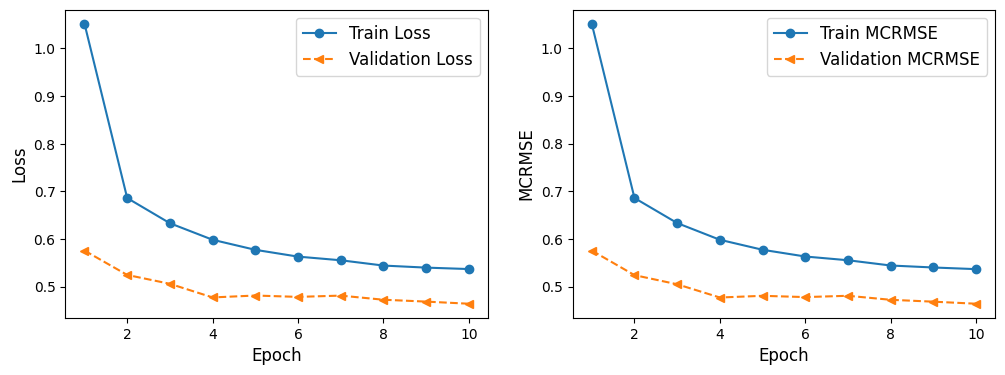

13/13 [==============================] - 17s 1s/step - loss: 0.4878 - MCRMSE: 0.4836

Evaluate Test Metrics:

Test loss: 0.4878

Test MCRMSE score: 0.4836 

13/13 [==============================] - 22s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 2
******************************************************

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

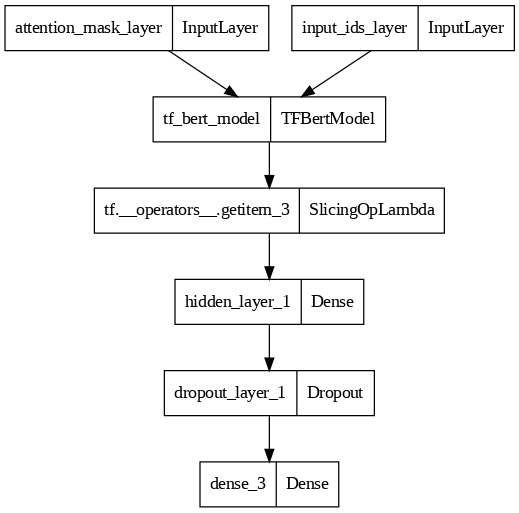

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 181s 882ms/step - loss: 1.2074 - MCRMSE: 1.2060 - val_loss: 0.5831 - val_MCRMSE: 0.5818
Epoch 2/10
196/196 [==============================] - 170s 867ms/step - loss: 0.7050 - MCRMSE: 0.7047 - val_loss: 0.5323 - val_MCRMSE: 0.5307
Epoch 3/10
196/196 [==============================] - 169s 864ms/step - loss: 0.6407 - MCRMSE: 0.6404 - val_loss: 0.5141 - val_MCRMSE: 0.5117
Epoch 4/10
196/196 [==============================] - 169s 865ms/step - loss: 0.6093 - MCRMSE: 0.6091 - val_loss: 0.4855 - val_MCRMSE: 0.4837
Epoch 5/10
196/196 [==============================] - 169s 865ms/step - loss: 0.5842 - MCRMSE: 0.5841 - val_loss: 0.4834 - val_MCRMSE: 0.4818
Epoch 6/10
196/196 [==============================] - 167s 853ms/step - loss: 0.5681 - MCRMSE: 0.5683 - val_loss: 0.4844 - val_MCRMSE: 0.4828
Epoch 7/10
196/196 [==============================] - 167s 852ms/step - loss: 0.5611 - MCRMSE: 0.5613 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        1.207413  0.705000  0.640746  0.609312  0.584201  0.568068  0.561075  0.550383  0.547642  0.539753
MCRMSE      1.205985  0.704675  0.640424  0.609113  0.584097  0.568298  0.561317  0.550584  0.547984  0.539483
val_loss    0.583057  0.532289  0.514132  0.485537  0.483386  0.484357  0.487177  0.482242  0.469572  0.460320
val_MCRMSE  0.581754  0.530739  0.511692  0.483726  0.481794  0.482751  0.485774  0.481047  0.468626  0.459724


Plotting loss and MCRMSE...


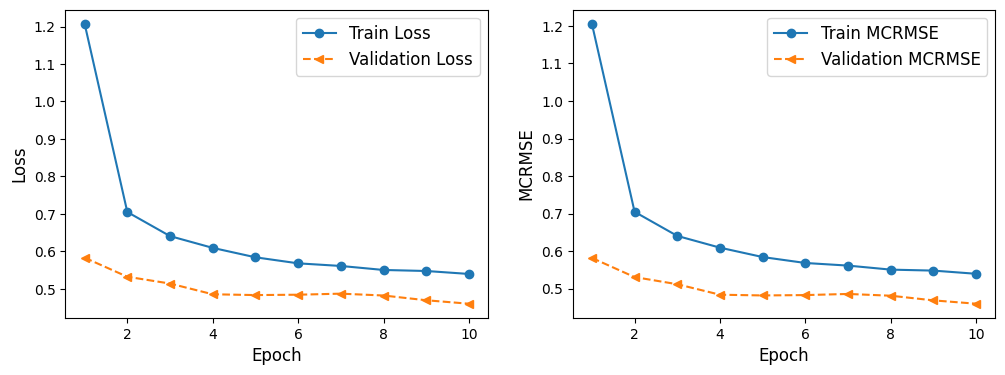

13/13 [==============================] - 17s 1s/step - loss: 0.4813 - MCRMSE: 0.4761

Evaluate Test Metrics:

Test loss: 0.4813

Test MCRMSE score: 0.4761 

13/13 [==============================] - 22s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 4
******************************************************

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

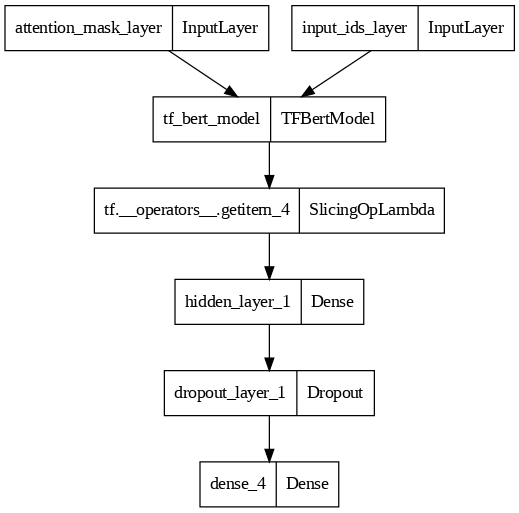

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 183s 883ms/step - loss: 1.2007 - MCRMSE: 1.1991 - val_loss: 0.5869 - val_MCRMSE: 0.5877
Epoch 2/10
196/196 [==============================] - 169s 863ms/step - loss: 0.6902 - MCRMSE: 0.6899 - val_loss: 0.5370 - val_MCRMSE: 0.5377
Epoch 3/10
196/196 [==============================] - 169s 863ms/step - loss: 0.6401 - MCRMSE: 0.6401 - val_loss: 0.5166 - val_MCRMSE: 0.5158
Epoch 4/10
196/196 [==============================] - 165s 842ms/step - loss: 0.6002 - MCRMSE: 0.5998 - val_loss: 0.4846 - val_MCRMSE: 0.4842
Epoch 5/10
196/196 [==============================] - 169s 862ms/step - loss: 0.5801 - MCRMSE: 0.5801 - val_loss: 0.4828 - val_MCRMSE: 0.4825
Epoch 6/10
196/196 [==============================] - 169s 863ms/step - loss: 0.5629 - MCRMSE: 0.5630 - val_loss: 0.4814 - val_MCRMSE: 0.4809
Epoch 7/10
196/196 [==============================] - 169s 863ms/step - loss: 0.5570 - MCRMSE: 0.5569 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        1.200660  0.690207  0.640110  0.600187  0.580127  0.562917  0.557012  0.547949  0.539495  0.539798
MCRMSE      1.199108  0.689889  0.640074  0.599778  0.580105  0.563039  0.556948  0.547964  0.539664  0.539279
val_loss    0.586897  0.536978  0.516628  0.484593  0.482806  0.481448  0.475831  0.475902  0.469972  0.462431
val_MCRMSE  0.587710  0.537666  0.515757  0.484241  0.482548  0.480934  0.475424  0.475499  0.469754  0.462249


Plotting loss and MCRMSE...


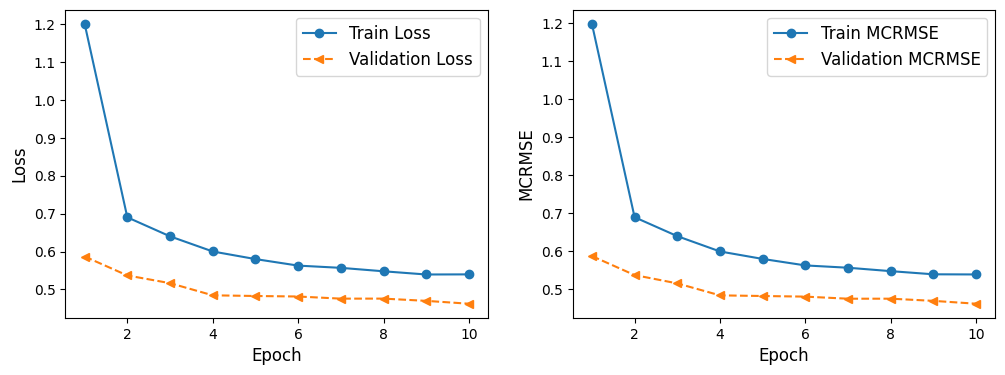

13/13 [==============================] - 17s 1s/step - loss: 0.4835 - MCRMSE: 0.4778

Evaluate Test Metrics:

Test loss: 0.4835

Test MCRMSE score: 0.4778 

13/13 [==============================] - 20s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 6
******************************************************

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

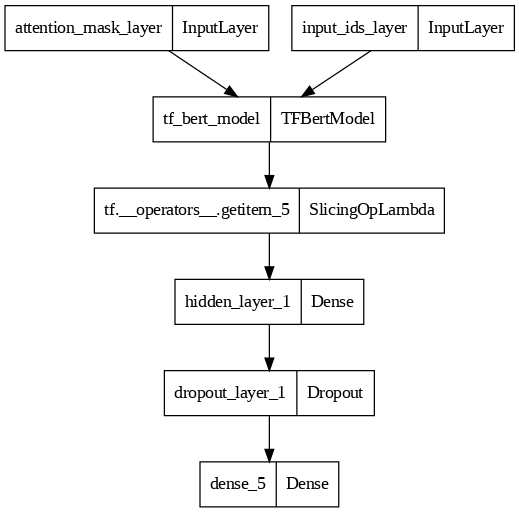

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 182s 877ms/step - loss: 1.0342 - MCRMSE: 1.0332 - val_loss: 0.5739 - val_MCRMSE: 0.5729
Epoch 2/10
196/196 [==============================] - 169s 863ms/step - loss: 0.6677 - MCRMSE: 0.6674 - val_loss: 0.5250 - val_MCRMSE: 0.5241
Epoch 3/10
196/196 [==============================] - 170s 866ms/step - loss: 0.6129 - MCRMSE: 0.6129 - val_loss: 0.5068 - val_MCRMSE: 0.5057
Epoch 4/10
196/196 [==============================] - 169s 864ms/step - loss: 0.5865 - MCRMSE: 0.5863 - val_loss: 0.4795 - val_MCRMSE: 0.4791
Epoch 5/10
196/196 [==============================] - 167s 852ms/step - loss: 0.5729 - MCRMSE: 0.5727 - val_loss: 0.4801 - val_MCRMSE: 0.4797
Epoch 6/10
196/196 [==============================] - 167s 852ms/step - loss: 0.5548 - MCRMSE: 0.5547 - val_loss: 0.4844 - val_MCRMSE: 0.4839
Epoch 7/10
196/196 [==============================] - 169s 863ms/step - loss: 0.5507 - MCRMSE: 0.5507 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        1.034210  0.667676  0.612930  0.586519  0.572869  0.554790  0.550712  0.538609  0.537392  0.530308
MCRMSE      1.033197  0.667381  0.612865  0.586270  0.572749  0.554686  0.550701  0.538624  0.537713  0.529897
val_loss    0.573881  0.525050  0.506794  0.479451  0.480109  0.484383  0.474864  0.474706  0.466909  0.460141
val_MCRMSE  0.572894  0.524081  0.505696  0.479108  0.479692  0.483850  0.474578  0.474428  0.466764  0.460174


Plotting loss and MCRMSE...


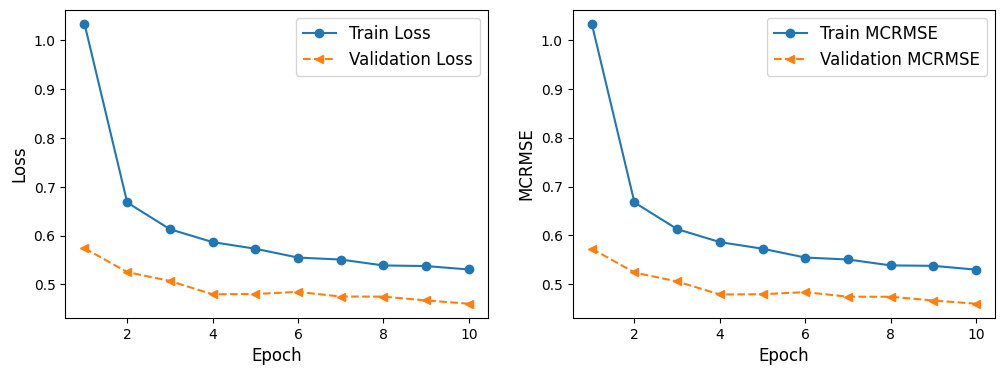

13/13 [==============================] - 17s 1s/step - loss: 0.4824 - MCRMSE: 0.4773

Evaluate Test Metrics:

Test loss: 0.4824

Test MCRMSE score: 0.4773 

13/13 [==============================] - 20s 1s/step


NLP Model  Num_Trainable_layers  Epochs  Test_MCRMSE  Test_Loss  Train_MCRMSE  Train_Loss  Val_MCRMSE  Val_Loss Optimizer  Activation  Learning_Rate  Num_Hidden_Layers  \
0  bert-base-cased                     0      10       0.4836     0.4878        0.5368      0.5371      0.4643    0.4643      adam  leaky_relu        0.00005                  1   
1  bert-base-cased                     2      10       0.4761     0.4813        0.5395      0.5398      0.4597    0.4603      adam  leaky_relu        0.00005                  1   
2  bert-base-cased                     4      10       0.4778     0.4835        0.5393      0.5398      0.4622    0.4624      adam  leaky_relu        0.00005                  1   
3  bert-base-cased                     6      10       0.4773     0.4824        0.5299      0.5303      0.4602    0.4601      adam  leaky_relu        0.00005                  1   

   Num_hidden_Units  Dropout  Batch_Size  
0               256      0.2          16  
1               256      0.2          16  
2               256      0.2          16  
3               256      0.2          16

In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,7,2),
                          # num_hidden_layer=1,
                          # num_hidden_units=256,
                          dropout=0.2,
                          # learning_rate=0.00005,
                          batch_size=16,
                          activation='leaky_relu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_batch16_leakyRelu_sgd.csv')


******************************************************
Regression with BERT: Number of Unfrozen Layers = 0
******************************************************

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                           

None

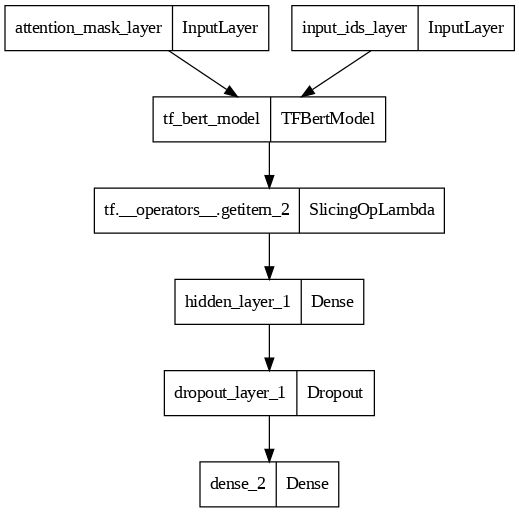

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 176s 840ms/step - loss: 0.9538 - MCRMSE: 0.9529 - val_loss: 0.5451 - val_MCRMSE: 0.5438
Epoch 2/10
196/196 [==============================] - 155s 793ms/step - loss: 0.6180 - MCRMSE: 0.6179 - val_loss: 0.4994 - val_MCRMSE: 0.4982
Epoch 3/10
196/196 [==============================] - 160s 819ms/step - loss: 0.5768 - MCRMSE: 0.5767 - val_loss: 0.4886 - val_MCRMSE: 0.4874
Epoch 4/10
196/196 [==============================] - 161s 821ms/step - loss: 0.5530 - MCRMSE: 0.5528 - val_loss: 0.4667 - val_MCRMSE: 0.4664
Epoch 5/10
196/196 [==============================] - 161s 821ms/step - loss: 0.5433 - MCRMSE: 0.5433 - val_loss: 0.4657 - val_MCRMSE: 0.4653
Epoch 6/10
196/196 [==============================] - 159s 810ms/step - loss: 0.5313 - MCRMSE: 0.5312 - val_loss: 0.4795 - val_MCRMSE: 0.4787
Epoch 7/10
196/196 [==============================] - 161s 819ms/step - loss: 0.5306 - MCRMSE: 0.5307 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        0.953767  0.618003  0.576804  0.552951  0.543324  0.531348  0.530616  0.519194  0.517624  0.513762
MCRMSE      0.952900  0.617854  0.576740  0.552764  0.543274  0.531249  0.530732  0.519214  0.517841  0.513392
val_loss    0.545077  0.499439  0.488645  0.466708  0.465654  0.479476  0.473142  0.465144  0.470483  0.451994
val_MCRMSE  0.543780  0.498157  0.487366  0.466373  0.465259  0.478741  0.472508  0.464748  0.469966  0.451965


Plotting loss and MCRMSE...


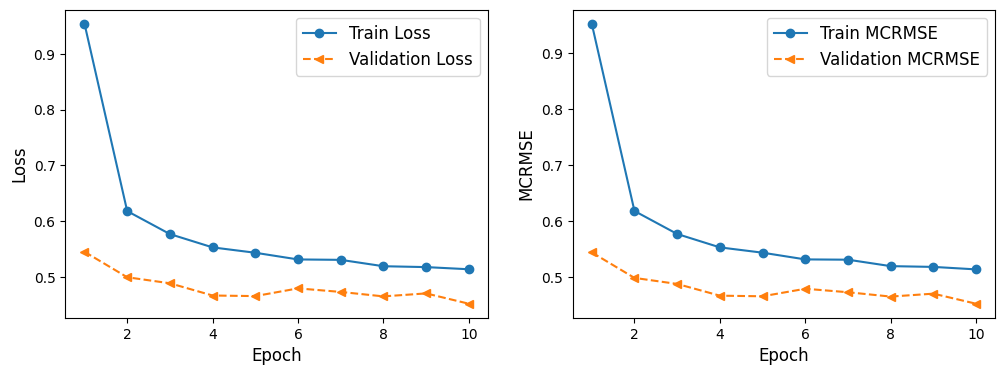

13/13 [==============================] - 15s 1s/step - loss: 0.4779 - MCRMSE: 0.4722

Evaluate Test Metrics:

Test loss: 0.4779

Test MCRMSE score: 0.4722 

13/13 [==============================] - 19s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 2
******************************************************

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

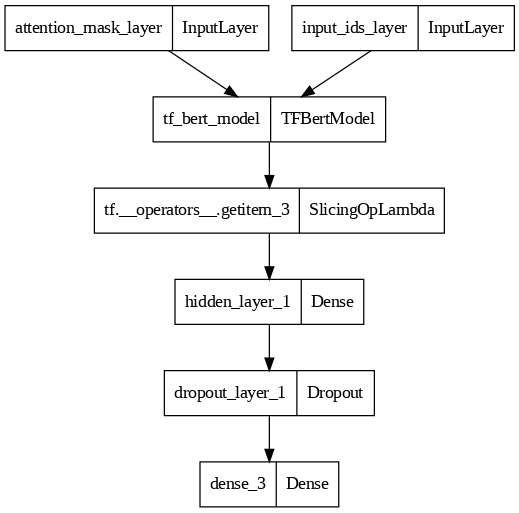

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 172s 840ms/step - loss: 0.9651 - MCRMSE: 0.9642 - val_loss: 0.5621 - val_MCRMSE: 0.5606
Epoch 2/10
196/196 [==============================] - 156s 795ms/step - loss: 0.6230 - MCRMSE: 0.6229 - val_loss: 0.5058 - val_MCRMSE: 0.5047
Epoch 3/10
196/196 [==============================] - 161s 820ms/step - loss: 0.5734 - MCRMSE: 0.5735 - val_loss: 0.4986 - val_MCRMSE: 0.4976
Epoch 4/10
196/196 [==============================] - 155s 793ms/step - loss: 0.5526 - MCRMSE: 0.5523 - val_loss: 0.4714 - val_MCRMSE: 0.4714
Epoch 5/10
196/196 [==============================] - 161s 821ms/step - loss: 0.5422 - MCRMSE: 0.5422 - val_loss: 0.4669 - val_MCRMSE: 0.4671
Epoch 6/10
196/196 [==============================] - 159s 811ms/step - loss: 0.5330 - MCRMSE: 0.5330 - val_loss: 0.4848 - val_MCRMSE: 0.4844
Epoch 7/10
196/196 [==============================] - 156s 794ms/step - loss: 0.5309 - MCRMSE: 0.5310 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        0.965095  0.622998  0.573425  0.552591  0.542185  0.532993  0.530885  0.519252  0.518469  0.513738
MCRMSE      0.964228  0.622887  0.573455  0.552330  0.542203  0.533032  0.530984  0.519186  0.518660  0.513296
val_loss    0.562072  0.505781  0.498637  0.471426  0.466857  0.484759  0.463042  0.469058  0.468955  0.455579
val_MCRMSE  0.560565  0.504663  0.497640  0.471450  0.467071  0.484394  0.463262  0.468989  0.468701  0.456271


Plotting loss and MCRMSE...


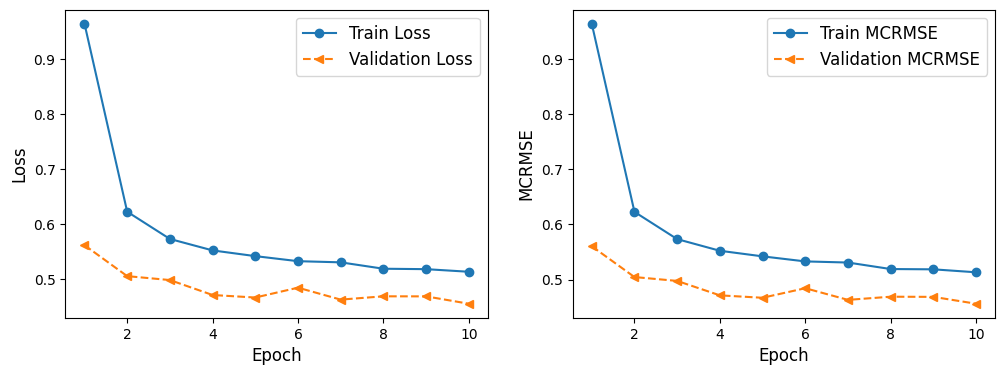

13/13 [==============================] - 15s 1s/step - loss: 0.4797 - MCRMSE: 0.4736

Evaluate Test Metrics:

Test loss: 0.4797

Test MCRMSE score: 0.4736 

13/13 [==============================] - 20s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 4
******************************************************

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

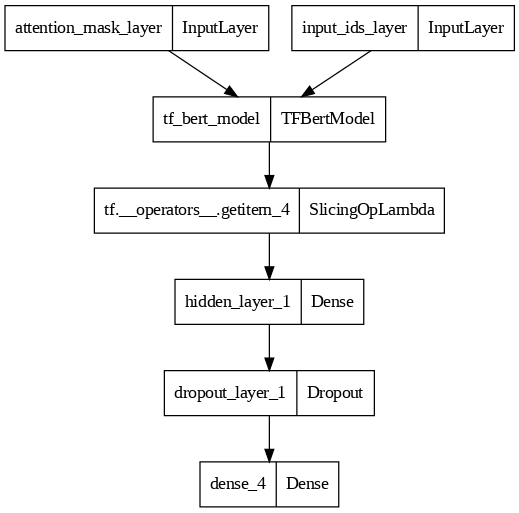

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 166s 813ms/step - loss: 0.9937 - MCRMSE: 0.9926 - val_loss: 0.5439 - val_MCRMSE: 0.5434
Epoch 2/10
196/196 [==============================] - 161s 820ms/step - loss: 0.6319 - MCRMSE: 0.6317 - val_loss: 0.4978 - val_MCRMSE: 0.4967
Epoch 3/10
196/196 [==============================] - 156s 794ms/step - loss: 0.5814 - MCRMSE: 0.5813 - val_loss: 0.4865 - val_MCRMSE: 0.4854
Epoch 4/10
196/196 [==============================] - 160s 819ms/step - loss: 0.5579 - MCRMSE: 0.5577 - val_loss: 0.4629 - val_MCRMSE: 0.4628
Epoch 5/10
196/196 [==============================] - 159s 810ms/step - loss: 0.5462 - MCRMSE: 0.5462 - val_loss: 0.4656 - val_MCRMSE: 0.4652
Epoch 6/10
196/196 [==============================] - 153s 783ms/step - loss: 0.5346 - MCRMSE: 0.5346 - val_loss: 0.4643 - val_MCRMSE: 0.4639
Epoch 7/10
196/196 [==============================] - 153s 782ms/step - loss: 0.5292 - MCRMSE: 0.5293 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        0.993658  0.631891  0.581409  0.557869  0.546223  0.534559  0.529207  0.522963  0.519010  0.514549
MCRMSE      0.992602  0.631676  0.581343  0.557730  0.546161  0.534562  0.529276  0.523086  0.519418  0.514145
val_loss    0.543853  0.497770  0.486467  0.462861  0.465629  0.464288  0.463179  0.462084  0.469177  0.450053
val_MCRMSE  0.543427  0.496672  0.485357  0.462774  0.465221  0.463915  0.462760  0.461699  0.468570  0.450419


Plotting loss and MCRMSE...


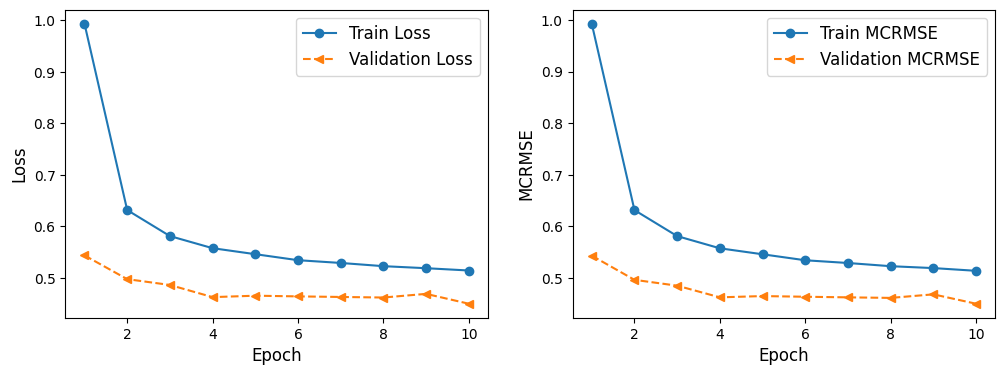

13/13 [==============================] - 15s 1s/step - loss: 0.4778 - MCRMSE: 0.4715

Evaluate Test Metrics:

Test loss: 0.4778

Test MCRMSE score: 0.4715 

13/13 [==============================] - 20s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 6
******************************************************

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

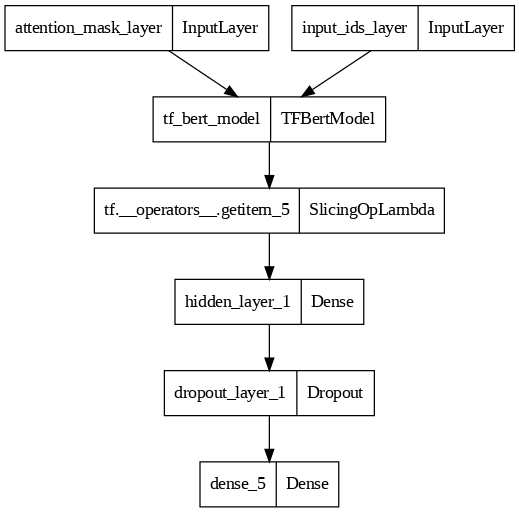

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 167s 809ms/step - loss: 0.9683 - MCRMSE: 0.9675 - val_loss: 0.5454 - val_MCRMSE: 0.5449
Epoch 2/10
196/196 [==============================] - 161s 821ms/step - loss: 0.6225 - MCRMSE: 0.6222 - val_loss: 0.4945 - val_MCRMSE: 0.4937
Epoch 3/10
196/196 [==============================] - 161s 822ms/step - loss: 0.5734 - MCRMSE: 0.5735 - val_loss: 0.4893 - val_MCRMSE: 0.4885
Epoch 4/10
196/196 [==============================] - 161s 820ms/step - loss: 0.5494 - MCRMSE: 0.5490 - val_loss: 0.4687 - val_MCRMSE: 0.4687
Epoch 5/10
196/196 [==============================] - 159s 811ms/step - loss: 0.5406 - MCRMSE: 0.5406 - val_loss: 0.4745 - val_MCRMSE: 0.4744
Epoch 6/10
196/196 [==============================] - 159s 811ms/step - loss: 0.5289 - MCRMSE: 0.5288 - val_loss: 0.4697 - val_MCRMSE: 0.4695
Epoch 7/10
196/196 [==============================] - 161s 820ms/step - loss: 0.5280 - MCRMSE: 0.5282 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        0.968346  0.622477  0.573442  0.549405  0.540595  0.528876  0.528005  0.519278  0.515767  0.510665
MCRMSE      0.967491  0.622211  0.573516  0.549045  0.540633  0.528811  0.528159  0.519202  0.516022  0.510221
val_loss    0.545358  0.494494  0.489278  0.468686  0.474547  0.469693  0.463979  0.469087  0.465493  0.451199
val_MCRMSE  0.544895  0.493659  0.488502  0.468738  0.474391  0.469471  0.463908  0.468805  0.465289  0.451447


Plotting loss and MCRMSE...


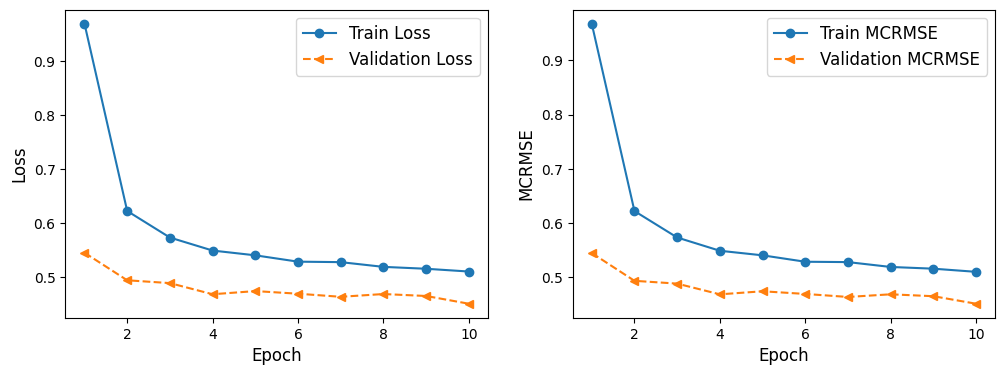

13/13 [==============================] - 15s 1s/step - loss: 0.4762 - MCRMSE: 0.4707

Evaluate Test Metrics:

Test loss: 0.4762

Test MCRMSE score: 0.4707 

13/13 [==============================] - 19s 1s/step


NLP Model  Num_Trainable_layers  Epochs  Test_MCRMSE  Test_Loss  Train_MCRMSE  Train_Loss  Val_MCRMSE  Val_Loss Optimizer  Activation  Learning_Rate  Num_Hidden_Layers  \
0  bert-base-cased                     0      10       0.4722     0.4779        0.5134      0.5138      0.4520    0.4520      adam  leaky_relu         0.0001                  1   
1  bert-base-cased                     2      10       0.4736     0.4797        0.5133      0.5137      0.4563    0.4556      adam  leaky_relu         0.0001                  1   
2  bert-base-cased                     4      10       0.4715     0.4778        0.5141      0.5145      0.4504    0.4501      adam  leaky_relu         0.0001                  1   
3  bert-base-cased                     6      10       0.4707     0.4762        0.5102      0.5107      0.4514    0.4512      adam  leaky_relu         0.0001                  1   

   Num_hidden_Units  Dropout  Batch_Size  
0               256      0.2          16  
1               256      0.2          16  
2               256      0.2          16  
3               256      0.2          16

In [ ]:
 run_regression_experiment(num_train_layers=np.arange(0,7,2),
                          # num_hidden_layer=1,
                          # num_hidden_units=256,
                          dropout=0.2,
                          learning_rate=0.0001,
                          batch_size=16,
                          activation='leaky_relu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_batch16_leakyRelu_lowerLR.csv')


******************************************************
Regression with BERT: Number of Unfrozen Layers = 0
******************************************************

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                           

None

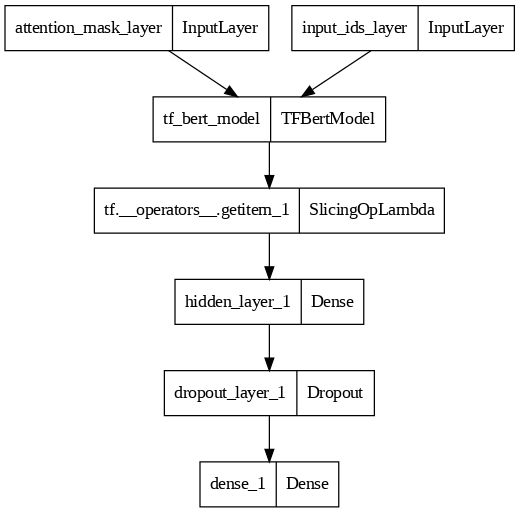

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 209s 999ms/step - loss: 0.7756 - MCRMSE: 0.7752 - val_loss: 0.4899 - val_MCRMSE: 0.4891
Epoch 2/10
196/196 [==============================] - 159s 812ms/step - loss: 0.5874 - MCRMSE: 0.5873 - val_loss: 0.4905 - val_MCRMSE: 0.4893
Epoch 3/10
196/196 [==============================] - 159s 811ms/step - loss: 0.5616 - MCRMSE: 0.5617 - val_loss: 0.4939 - val_MCRMSE: 0.4930
Epoch 4/10
196/196 [==============================] - 161s 821ms/step - loss: 0.5467 - MCRMSE: 0.5464 - val_loss: 0.4762 - val_MCRMSE: 0.4758
Epoch 5/10
196/196 [==============================] - 161s 821ms/step - loss: 0.5356 - MCRMSE: 0.5357 - val_loss: 0.4716 - val_MCRMSE: 0.4716
Epoch 6/10
196/196 [==============================] - 161s 821ms/step - loss: 0.5324 - MCRMSE: 0.5322 - val_loss: 0.4495 - val_MCRMSE: 0.4497
Epoch 7/10
196/196 [==============================] - 159s 811ms/step - loss: 0.5218 - MCRMSE: 0.5218 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        0.775637  0.587449  0.561627  0.546668  0.535639  0.532407  0.521783  0.519910  0.509960  0.503800
MCRMSE      0.775163  0.587266  0.561721  0.546441  0.535705  0.532189  0.521755  0.519689  0.510648  0.503357
val_loss    0.489872  0.490489  0.493879  0.476219  0.471604  0.449499  0.485007  0.462080  0.470739  0.489320
val_MCRMSE  0.489063  0.489293  0.492963  0.475784  0.471584  0.449689  0.484652  0.461724  0.470743  0.489185


Plotting loss and MCRMSE...


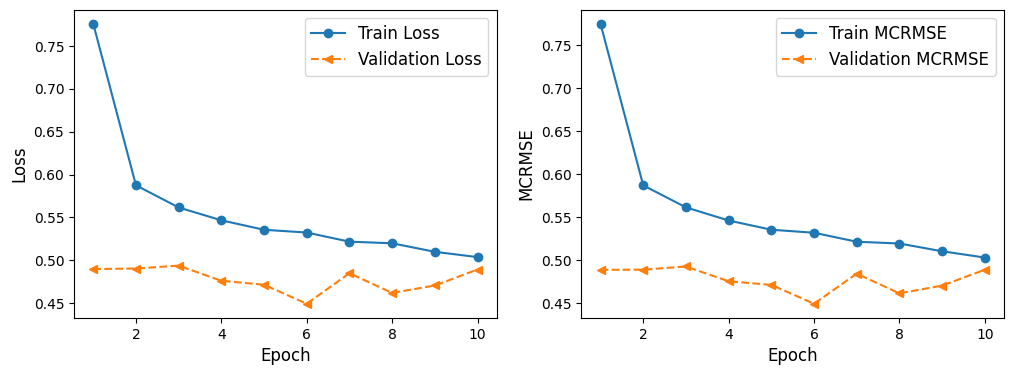

13/13 [==============================] - 15s 1s/step - loss: 0.5095 - MCRMSE: 0.5065

Evaluate Test Metrics:

Test loss: 0.5095

Test MCRMSE score: 0.5065 

13/13 [==============================] - 19s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 4
******************************************************

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

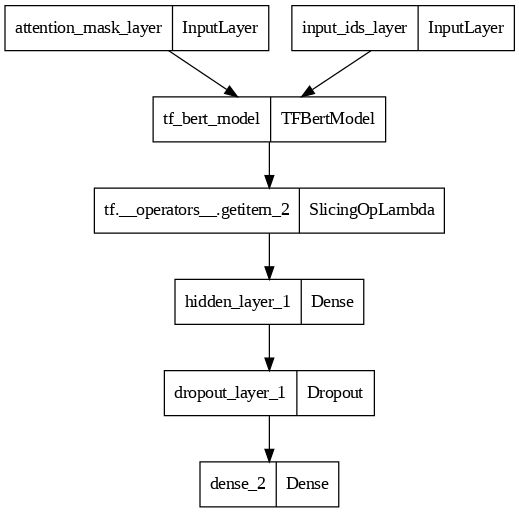

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 168s 812ms/step - loss: 0.8095 - MCRMSE: 0.8089 - val_loss: 0.4910 - val_MCRMSE: 0.4909
Epoch 2/10
196/196 [==============================] - 161s 823ms/step - loss: 0.5861 - MCRMSE: 0.5861 - val_loss: 0.4857 - val_MCRMSE: 0.4853
Epoch 3/10
196/196 [==============================] - 156s 795ms/step - loss: 0.5631 - MCRMSE: 0.5631 - val_loss: 0.4698 - val_MCRMSE: 0.4698
Epoch 4/10
196/196 [==============================] - 159s 811ms/step - loss: 0.5489 - MCRMSE: 0.5488 - val_loss: 0.4748 - val_MCRMSE: 0.4748
Epoch 5/10
196/196 [==============================] - 161s 821ms/step - loss: 0.5401 - MCRMSE: 0.5402 - val_loss: 0.4642 - val_MCRMSE: 0.4648
Epoch 6/10
196/196 [==============================] - 159s 812ms/step - loss: 0.5314 - MCRMSE: 0.5314 - val_loss: 0.4788 - val_MCRMSE: 0.4787
Epoch 7/10
196/196 [==============================] - 159s 811ms/step - loss: 0.5236 - MCRMSE: 0.5237 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        0.809497  0.586129  0.563079  0.548860  0.540074  0.531386  0.523641  0.519995  0.511272  0.506391
MCRMSE      0.808881  0.586140  0.563118  0.548797  0.540172  0.531369  0.523651  0.519844  0.511953  0.505956
val_loss    0.490994  0.485741  0.469798  0.474840  0.464227  0.478775  0.473199  0.461017  0.477862  0.488448
val_MCRMSE  0.490853  0.485323  0.469774  0.474772  0.464757  0.478688  0.473339  0.461200  0.477716  0.488322


Plotting loss and MCRMSE...


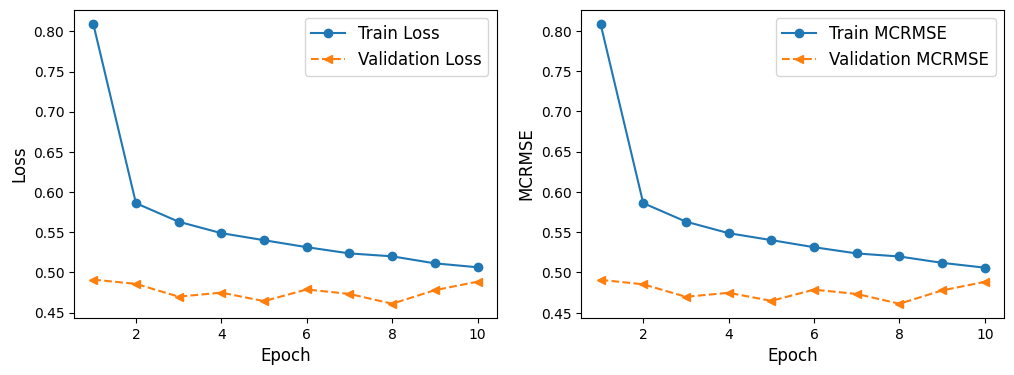

13/13 [==============================] - 15s 1s/step - loss: 0.5084 - MCRMSE: 0.5050

Evaluate Test Metrics:

Test loss: 0.5084

Test MCRMSE score: 0.5050 

13/13 [==============================] - 19s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 8
******************************************************

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

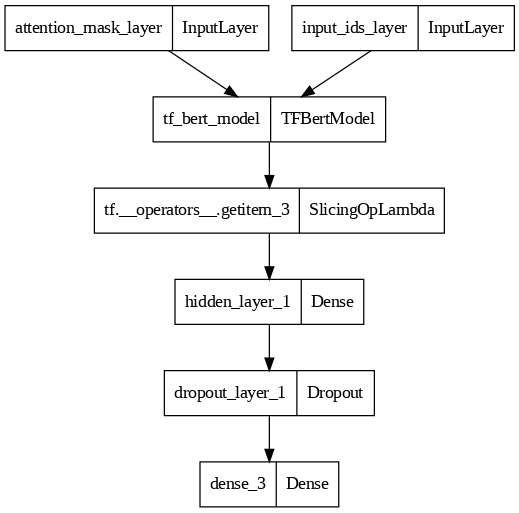

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 174s 841ms/step - loss: 0.7351 - MCRMSE: 0.7348 - val_loss: 0.5031 - val_MCRMSE: 0.5024
Epoch 2/10
196/196 [==============================] - 159s 812ms/step - loss: 0.5784 - MCRMSE: 0.5784 - val_loss: 0.5101 - val_MCRMSE: 0.5087
Epoch 3/10
196/196 [==============================] - 156s 795ms/step - loss: 0.5550 - MCRMSE: 0.5552 - val_loss: 0.4750 - val_MCRMSE: 0.4742
Epoch 4/10
196/196 [==============================] - 161s 822ms/step - loss: 0.5443 - MCRMSE: 0.5441 - val_loss: 0.4606 - val_MCRMSE: 0.4600
Epoch 5/10
196/196 [==============================] - 159s 811ms/step - loss: 0.5353 - MCRMSE: 0.5353 - val_loss: 0.4851 - val_MCRMSE: 0.4846
Epoch 6/10
196/196 [==============================] - 161s 823ms/step - loss: 0.5256 - MCRMSE: 0.5255 - val_loss: 0.4600 - val_MCRMSE: 0.4596
Epoch 7/10
196/196 [==============================] - 159s 812ms/step - loss: 0.5182 - MCRMSE: 0.5183 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        0.735131  0.578377  0.555048  0.544307  0.535336  0.525607  0.518198  0.518147  0.506947  0.503318
MCRMSE      0.734830  0.578390  0.555171  0.544135  0.535293  0.525468  0.518333  0.517824  0.507464  0.503044
val_loss    0.503115  0.510054  0.474973  0.460605  0.485102  0.459958  0.486975  0.474012  0.475367  0.474137
val_MCRMSE  0.502426  0.508679  0.474229  0.460019  0.484616  0.459634  0.486441  0.473502  0.475100  0.473767


Plotting loss and MCRMSE...


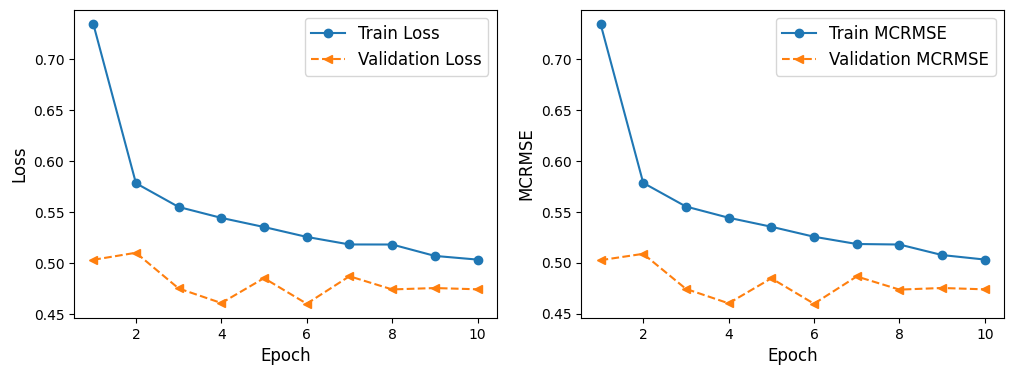

13/13 [==============================] - 15s 1s/step - loss: 0.4954 - MCRMSE: 0.4919

Evaluate Test Metrics:

Test loss: 0.4954

Test MCRMSE score: 0.4919 

13/13 [==============================] - 18s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 12
******************************************************

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
              

None

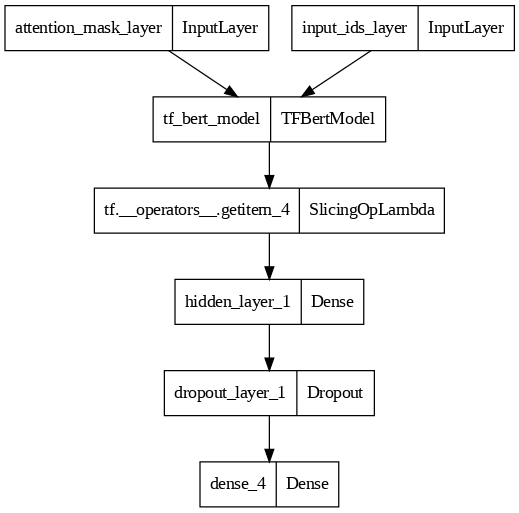

Training Regression with BERT.....
Epoch 1/10


 31/196 [===>..........................] - ETA: 2:57 - loss: 0.9754 - MCRMSE: 0.9754

KeyboardInterrupt: ignored

In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,13,4),
                          # num_hidden_layer=1,
                          num_hidden_units=128,
                          dropout=0.2,
                          learning_rate=0.0005,
                          batch_size=16,
                          activation='leaky_relu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_batch16_leakyRelu_lowerLR2.csv')


******************************************************
Regression with BERT: Number of Unfrozen Layers = 0
******************************************************

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                             

None

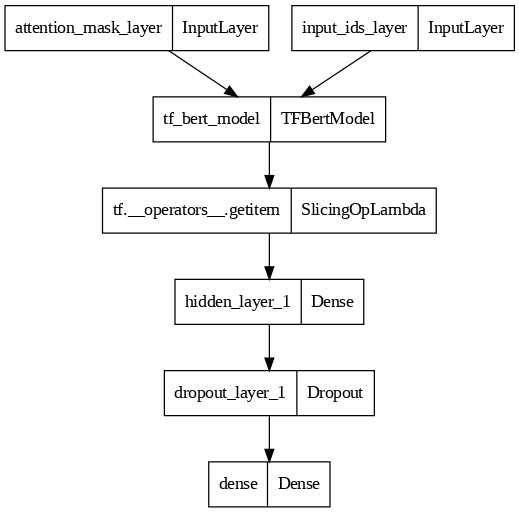

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 188s 877ms/step - loss: 0.8349 - MCRMSE: 0.8346 - val_loss: 0.4840 - val_MCRMSE: 0.4840
Epoch 2/10
196/196 [==============================] - 165s 841ms/step - loss: 0.6216 - MCRMSE: 0.6215 - val_loss: 0.5085 - val_MCRMSE: 0.5076
Epoch 3/10
196/196 [==============================] - 166s 849ms/step - loss: 0.5963 - MCRMSE: 0.5962 - val_loss: 0.4664 - val_MCRMSE: 0.4665
Epoch 4/10
196/196 [==============================] - 164s 839ms/step - loss: 0.5774 - MCRMSE: 0.5774 - val_loss: 0.4684 - val_MCRMSE: 0.4686
Epoch 5/10
196/196 [==============================] - 164s 839ms/step - loss: 0.5713 - MCRMSE: 0.5712 - val_loss: 0.5321 - val_MCRMSE: 0.5320
Epoch 6/10
196/196 [==============================] - 167s 853ms/step - loss: 0.5565 - MCRMSE: 0.5566 - val_loss: 0.4510 - val_MCRMSE: 0.4516
Epoch 7/10
196/196 [==============================] - 165s 841ms/step - loss: 0.5409 - MCRMSE: 0.5407 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        0.834920  0.621601  0.596342  0.577368  0.571282  0.556484  0.540911  0.537959  0.530718  0.529423
MCRMSE      0.834640  0.621533  0.596196  0.577399  0.571229  0.556588  0.540667  0.537800  0.530767  0.529103
val_loss    0.483970  0.508458  0.466406  0.468400  0.532079  0.450980  0.525275  0.494991  0.475355  0.479740
val_MCRMSE  0.484006  0.507587  0.466453  0.468586  0.532047  0.451555  0.524684  0.494405  0.475183  0.479639


Plotting loss and MCRMSE...


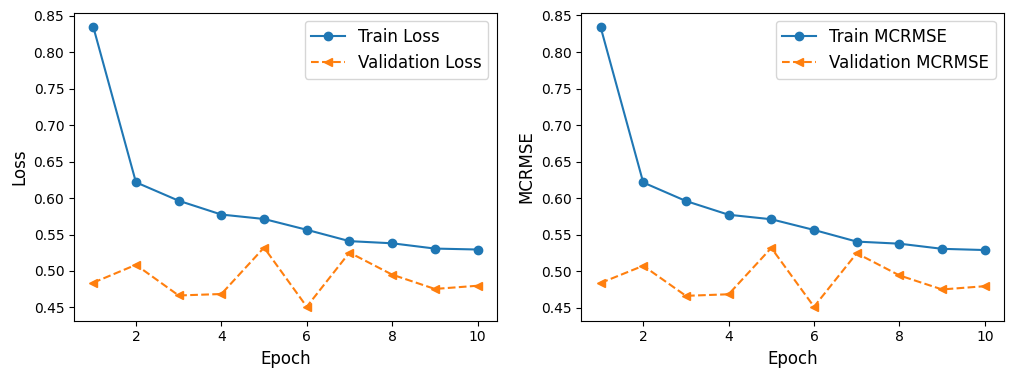

13/13 [==============================] - 16s 1s/step - loss: 0.5006 - MCRMSE: 0.4982

Evaluate Test Metrics:

Test loss: 0.5006

Test MCRMSE score: 0.4982 

13/13 [==============================] - 19s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 4
******************************************************

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

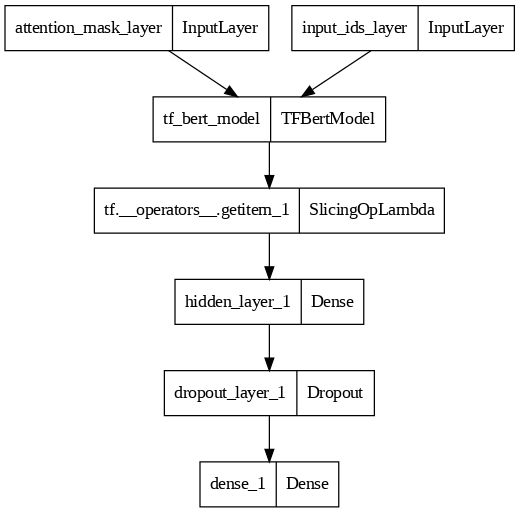

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 181s 869ms/step - loss: 0.9062 - MCRMSE: 0.9056 - val_loss: 0.4794 - val_MCRMSE: 0.4803
Epoch 2/10
196/196 [==============================] - 165s 843ms/step - loss: 0.6355 - MCRMSE: 0.6354 - val_loss: 0.5171 - val_MCRMSE: 0.5163
Epoch 3/10
196/196 [==============================] - 163s 833ms/step - loss: 0.5982 - MCRMSE: 0.5980 - val_loss: 0.4654 - val_MCRMSE: 0.4654
Epoch 4/10
196/196 [==============================] - 165s 841ms/step - loss: 0.5789 - MCRMSE: 0.5792 - val_loss: 0.5165 - val_MCRMSE: 0.5157
Epoch 5/10
196/196 [==============================] - 165s 840ms/step - loss: 0.5686 - MCRMSE: 0.5685 - val_loss: 0.5686 - val_MCRMSE: 0.5684
Epoch 6/10
196/196 [==============================] - 167s 852ms/step - loss: 0.5562 - MCRMSE: 0.5562 - val_loss: 0.4485 - val_MCRMSE: 0.4491
Epoch 7/10
196/196 [==============================] - 164s 838ms/step - loss: 0.5483 - MCRMSE: 0.5481 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        0.906173  0.635466  0.598234  0.578905  0.568588  0.556218  0.548271  0.546475  0.532561  0.533348
MCRMSE      0.905575  0.635444  0.597964  0.579167  0.568538  0.556197  0.548149  0.546313  0.532669  0.533018
val_loss    0.479359  0.517093  0.465351  0.516528  0.568599  0.448540  0.499802  0.494193  0.481091  0.456723
val_MCRMSE  0.480286  0.516262  0.465417  0.515685  0.568367  0.449144  0.499071  0.493467  0.480682  0.456673


Plotting loss and MCRMSE...


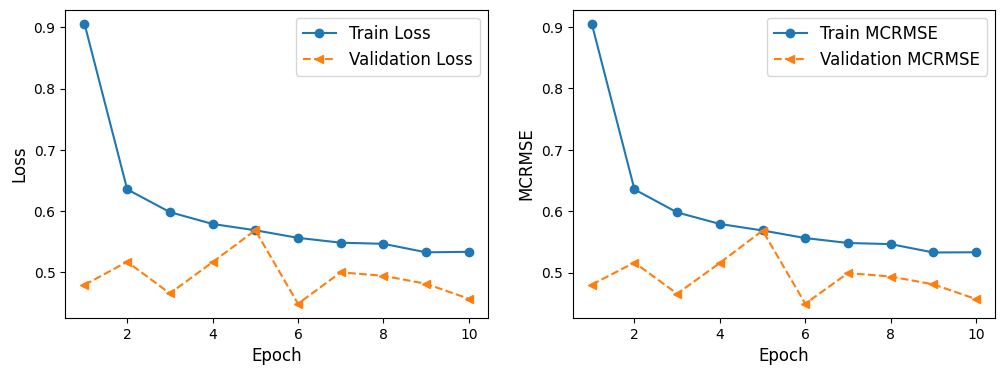

13/13 [==============================] - 16s 1s/step - loss: 0.4806 - MCRMSE: 0.4754

Evaluate Test Metrics:

Test loss: 0.4806

Test MCRMSE score: 0.4754 

13/13 [==============================] - 19s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 8
******************************************************

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

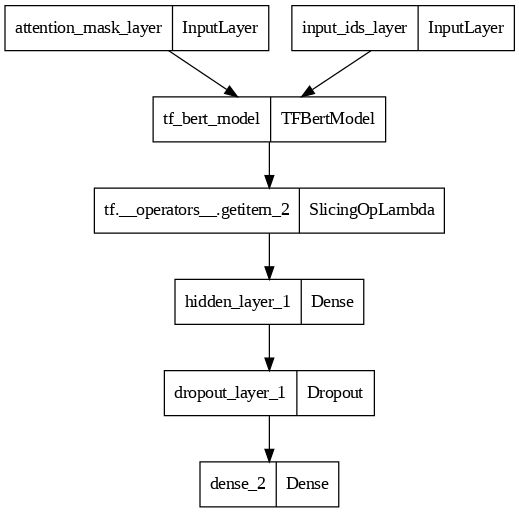

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 177s 844ms/step - loss: 0.8652 - MCRMSE: 0.8647 - val_loss: 0.4868 - val_MCRMSE: 0.4868
Epoch 2/10
196/196 [==============================] - 164s 836ms/step - loss: 0.6404 - MCRMSE: 0.6405 - val_loss: 0.5133 - val_MCRMSE: 0.5124
Epoch 3/10
196/196 [==============================] - 162s 826ms/step - loss: 0.6044 - MCRMSE: 0.6042 - val_loss: 0.4736 - val_MCRMSE: 0.4732
Epoch 4/10
196/196 [==============================] - 159s 814ms/step - loss: 0.5774 - MCRMSE: 0.5775 - val_loss: 0.5046 - val_MCRMSE: 0.5039
Epoch 5/10
196/196 [==============================] - 160s 817ms/step - loss: 0.5668 - MCRMSE: 0.5670 - val_loss: 0.5087 - val_MCRMSE: 0.5085
Epoch 6/10
196/196 [==============================] - 163s 830ms/step - loss: 0.5588 - MCRMSE: 0.5587 - val_loss: 0.4493 - val_MCRMSE: 0.4495
Epoch 7/10
196/196 [==============================] - 165s 844ms/step - loss: 0.5452 - MCRMSE: 0.5453 - val_loss:

0         1         2         3         4         5         6         7         8         9
loss        0.865214  0.640416  0.604387  0.577362  0.566802  0.558837  0.545215  0.540640  0.538038  0.529834
MCRMSE      0.864681  0.640473  0.604224  0.577527  0.566950  0.558746  0.545306  0.540556  0.538221  0.529493
val_loss    0.486826  0.513342  0.473585  0.504612  0.508707  0.449277  0.461263  0.495366  0.480400  0.464346
val_MCRMSE  0.486791  0.512389  0.473236  0.503909  0.508522  0.449512  0.461078  0.494614  0.479793  0.463954


Plotting loss and MCRMSE...


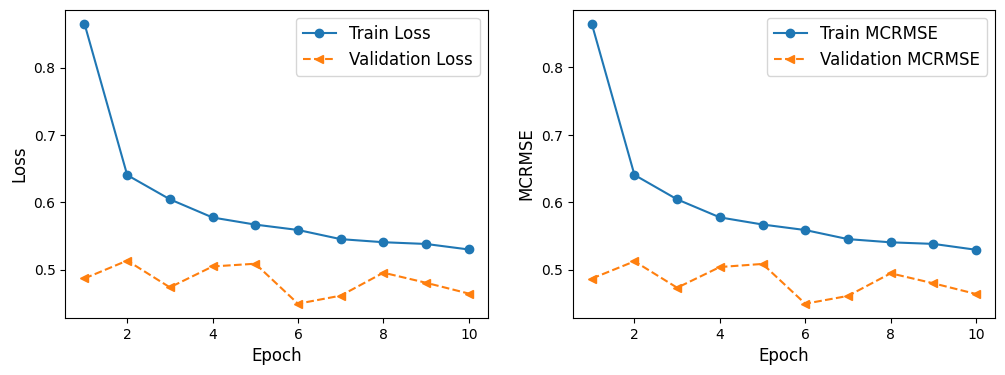

13/13 [==============================] - 16s 1s/step - loss: 0.4858 - MCRMSE: 0.4813

Evaluate Test Metrics:

Test loss: 0.4858

Test MCRMSE score: 0.4813 

13/13 [==============================] - 19s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 12
******************************************************

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
              

None

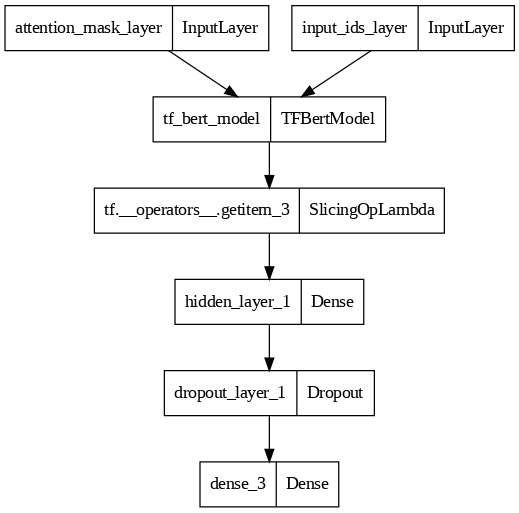

Training Regression with BERT.....
Epoch 1/10


196/196 [==============================] - 268s 1s/step - loss: 0.7546 - MCRMSE: 0.7545 - val_loss: 0.5403 - val_MCRMSE: 0.5422
Epoch 2/10
196/196 [==============================] - 244s 1s/step - loss: 0.6360 - MCRMSE: 0.6361 - val_loss: 0.4889 - val_MCRMSE: 0.4897
Epoch 3/10
196/196 [==============================] - 246s 1s/step - loss: 0.6131 - MCRMSE: 0.6131 - val_loss: 0.4704 - val_MCRMSE: 0.4704
Epoch 4/10
196/196 [==============================] - 237s 1s/step - loss: 0.5876 - MCRMSE: 0.5875 - val_loss: 0.6306 - val_MCRMSE: 0.6348
Epoch 5/10
196/196 [==============================] - 240s 1s/step - loss: 0.5839 - MCRMSE: 0.5838 - val_loss: 0.4612 - val_MCRMSE: 0.4611
Epoch 6/10
196/196 [==============================] - 244s 1s/step - loss: 0.5490 - MCRMSE: 0.5490 - val_loss: 0.4506 - val_MCRMSE: 0.4501
Epoch 7/10
196/196 [==============================] - 233s 1s/step - loss: 0.5372 - MCRMSE: 0.5373 - val_loss: 0.4715 - val_MCRMSE: 0.4720
Epoch 8/10
196/196 [==================

0         1         2         3         4         5         6         7         8         9
loss        0.754648  0.636028  0.613118  0.587567  0.583891  0.548971  0.537215  0.522189  0.509630  0.507000
MCRMSE      0.754468  0.636090  0.613131  0.587467  0.583842  0.548958  0.537332  0.521771  0.509497  0.506594
val_loss    0.540274  0.488854  0.470424  0.630632  0.461157  0.450600  0.471463  0.452710  0.478446  0.505096
val_MCRMSE  0.542208  0.489745  0.470422  0.634831  0.461065  0.450143  0.472028  0.453175  0.477444  0.503144


Plotting loss and MCRMSE...


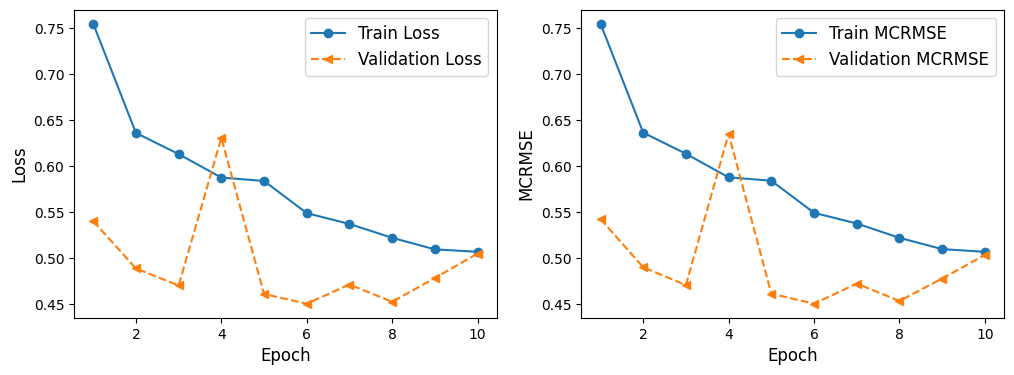

13/13 [==============================] - 16s 1s/step - loss: 0.5325 - MCRMSE: 0.5352

Evaluate Test Metrics:

Test loss: 0.5325

Test MCRMSE score: 0.5352 

13/13 [==============================] - 18s 1s/step


NLP Model  Num_Trainable_layers  Epochs  Test_MCRMSE  Test_Loss  Train_MCRMSE  Train_Loss  Val_MCRMSE  Val_Loss Optimizer  Activation  Learning_Rate  Num_Hidden_Layers  \
0  bert-base-cased                     0      10       0.4982     0.5006        0.5291      0.5294      0.4796    0.4797      adam  leaky_relu         0.0005                  1   
1  bert-base-cased                     4      10       0.4754     0.4806        0.5330      0.5333      0.4567    0.4567      adam  leaky_relu         0.0005                  1   
2  bert-base-cased                     8      10       0.4813     0.4858        0.5295      0.5298      0.4640    0.4643      adam  leaky_relu         0.0005                  1   
3  bert-base-cased                    12      10       0.5352     0.5325        0.5066      0.5070      0.5031    0.5051      adam  leaky_relu         0.0005                  1   

   Num_hidden_Units  Dropout  Batch_Size  
0                64      0.2          16  
1                64      0.2          16  
2                64      0.2          16  
3                64      0.2          16

In [ ]:
 run_regression_experiment(num_train_layers=np.arange(0,13,4),
                          # num_hidden_layer=1,
                          num_hidden_units=64,
                          dropout=0.2,
                          learning_rate=0.0005,
                          batch_size=16,
                          activation='leaky_relu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_batch16_leakyRelu_lowerLR128.csv')



******************************************************
Regression with BERT: Number of Unfrozen Layers = 12
******************************************************

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                          

None

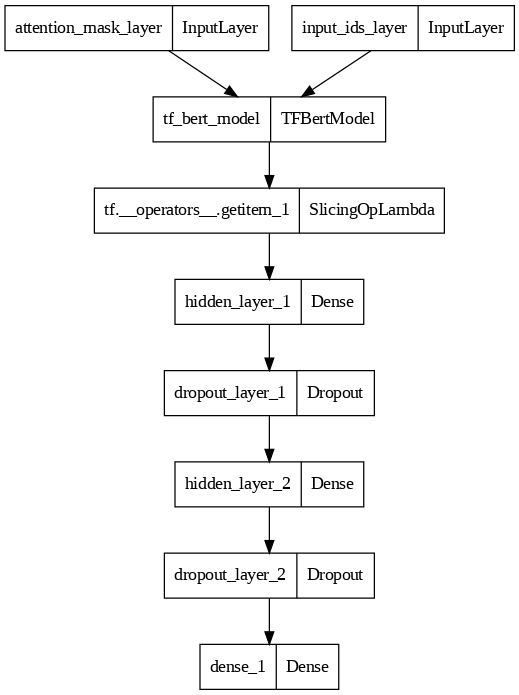

Training Regression with BERT.....
Epoch 1/10


391/391 [==============================] - 462s 1s/step - loss: 1.0052 - MCRMSE: 1.0052 - val_loss: 0.4529 - val_MCRMSE: 0.4528
Epoch 2/10
391/391 [==============================] - 403s 1s/step - loss: 0.8424 - MCRMSE: 0.8424 - val_loss: 0.4699 - val_MCRMSE: 0.4700
Epoch 3/10
391/391 [==============================] - 409s 1s/step - loss: 0.8119 - MCRMSE: 0.8119 - val_loss: 0.4409 - val_MCRMSE: 0.4409
Epoch 4/10
391/391 [==============================] - 402s 1s/step - loss: 0.7783 - MCRMSE: 0.7783 - val_loss: 0.4429 - val_MCRMSE: 0.4430
Epoch 5/10
391/391 [==============================] - 402s 1s/step - loss: 0.7657 - MCRMSE: 0.7657 - val_loss: 0.4686 - val_MCRMSE: 0.4687
Epoch 6/10
391/391 [==============================] - 398s 1s/step - loss: 0.7357 - MCRMSE: 0.7357 - val_loss: 0.4645 - val_MCRMSE: 0.4646
Epoch 7/10
391/391 [==============================] - 402s 1s/step - loss: 0.7101 - MCRMSE: 0.7101 - val_loss: 0.4481 - val_MCRMSE: 0.4481
Epoch 8/10
391/391 [==================

0         1         2         3         4         5         6         7         8         9
loss        1.005226  0.842388  0.811936  0.778345  0.765727  0.735703  0.710068  0.699799  0.677840  0.674313
MCRMSE      1.005226  0.842388  0.811936  0.778345  0.765727  0.735703  0.710068  0.699799  0.677840  0.674313
val_loss    0.452897  0.469901  0.440940  0.442872  0.468559  0.464540  0.448108  0.457696  0.444983  0.445999
val_MCRMSE  0.452835  0.469967  0.440945  0.442972  0.468708  0.464644  0.448141  0.457783  0.445062  0.446103


Plotting loss and MCRMSE...


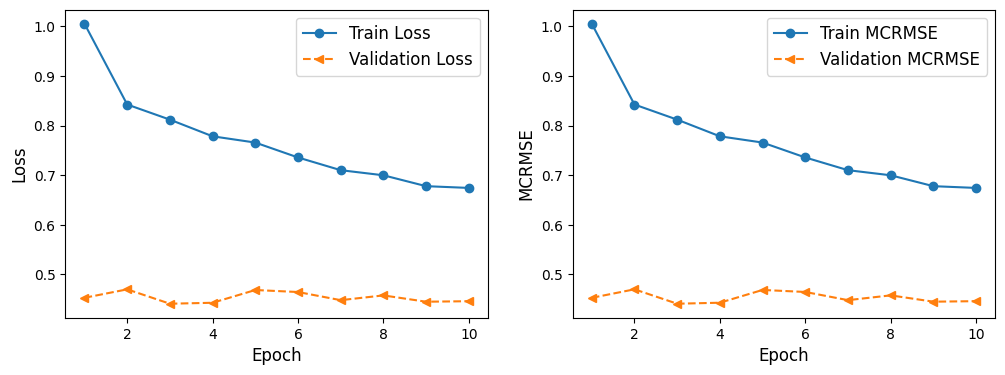

13/13 [==============================] - 17s 1s/step - loss: 0.4640 - MCRMSE: 0.4590

Evaluate Test Metrics:

Test loss: 0.4640

Test MCRMSE score: 0.4590 

13/13 [==============================] - 20s 1s/step

Final Table: y_true vs. y_pred_raw vs. y_pred_scaled


full_text  cohesion  syntax  vocabulary  phraseology  grammar  conventions  pred_cohesion  pred_syntax  pred_vocabulary  \
0    How we know the first impression is important ...       3.5     2.5         3.5          3.5      2.5          3.0       3.035890     3.012562         3.137691   
1    I agree with emerson's statement. I will grow ...       3.0     3.0         3.0          3.5      2.5          3.0       2.920642     2.786633         3.023021   
2    When are parents gave us advice we are able to...       2.5     2.0         2.5          2.0      2.0          3.0       2.924337     2.757843         3.013599   
3    The determination make us to do something and ...       3.5     3.0         3.0          2.5      2.5          3.5       2.645047     2.424623         2.779027   
4    The should be people make their own decision, ...       2.5     2.5         2.5          2.0      2.5          2.0       2.155948     2.008913         2.274725   
..                                                 ...       ...     ...         ...          ...      ...          ...            ...          ...              ...   
387  Why Collage is Important\n\nAcorting to CNN we...       2.5     3.0         3.0          3.0      2.5          2.0       2.731847     2.757791         2.859764   
388  Students chould not be required to take a musi...       3.5     3.0         3.5          3.0      3.5          4.0       3.413173     3.273975         3.243555   
389  Everyone has their personal choice or opinion ...       3.0     3.5         3.5          4.0      4.0          4.0       3.513042     3.582745         3.616240   
390  What are some decision that students take rega...       3.0     3.0         3.0          3.0      3.0          2.5       2.884946     2.778587         2.986388   
391  On my Opinion i think is a good way to the stu...       2.5     2.0         2.0          2.0      2.0          2.0       2.474205     2.327313         2.588896   

     pred_phraseology  pred_grammar  pred_conventions  pred_cohesion_scaled  pred_syntax_scaled  pred_vocabulary_scaled  pred_phraseology_scaled  pred_grammar_scaled  \
0            3.095841      3.068082          3.214729                   3.0                 3.0                     3.0                      3.0                  3.0   
1            2.739079      2.477350          2.941411                   3.0                 3.0                     3.0                      2.5                  2.5   
2            2.744196      2.662990          2.878634                   3.0                 3.0                     3.0                      2.5                  2.5   
3            2.444710      2.257034          2.562345                   2.5                 2.5                     3.0                      2.5                  2.5   
4            2.220588      2.114468          2.058691                   2.0                 2.0                     2.5                      2.0                  2.0   
..                ...           ...               ...                   ...                 ...                     ...                      ...                  ...   
387          2.950166      3.040274          2.624904                   2.5                 3.0                     3.0                      3.0                  3.0   
388          3.241729      3.406015          3.046981                   3.5                 3.5                     3.0                      3.0                  3.5   
389          3.709250      3.852306          3.745369                   3.5                 3.5                     3.5                      3.5                  4.0   
390          2.786958      2.746426          3.087802                   3.0                 3.0                     3.0                      3.0                  2.5   
391          2.454310      2.342591          2.356183                   2.5                 2.5                     2.5                      2.5                  2.5   



Final Table: y_true vs. y_pred_raw vs. y_pred_scaled


full_text  cohesion  syntax  vocabulary  phraseology  grammar  conventions  pred_cohesion  pred_syntax  pred_vocabulary  \
0    How we know the first impression is important ...       3.5     2.5         3.5          3.5      2.5          3.0       3.035890     3.012562         3.137691   
1    I agree with emerson's statement. I will grow ...       3.0     3.0         3.0          3.5      2.5          3.0       2.920642     2.786633         3.023021   
2    When are parents gave us advice we are able to...       2.5     2.0         2.5          2.0      2.0          3.0       2.924337     2.757843         3.013599   
3    The determination make us to do something and ...       3.5     3.0         3.0          2.5      2.5          3.5       2.645047     2.424623         2.779027   
4    The should be people make their own decision, ...       2.5     2.5         2.5          2.0      2.5          2.0       2.155948     2.008913         2.274725   
..                                                 ...       ...     ...         ...          ...      ...          ...            ...          ...              ...   
387  Why Collage is Important\n\nAcorting to CNN we...       2.5     3.0         3.0          3.0      2.5          2.0       2.731847     2.757791         2.859764   
388  Students chould not be required to take a musi...       3.5     3.0         3.5          3.0      3.5          4.0       3.413173     3.273975         3.243555   
389  Everyone has their personal choice or opinion ...       3.0     3.5         3.5          4.0      4.0          4.0       3.513042     3.582745         3.616240   
390  What are some decision that students take rega...       3.0     3.0         3.0          3.0      3.0          2.5       2.884946     2.778587         2.986388   
391  On my Opinion i think is a good way to the stu...       2.5     2.0         2.0          2.0      2.0          2.0       2.474205     2.327313         2.588896   

     pred_phraseology  pred_grammar  pred_conventions  pred_cohesion_scaled  pred_syntax_scaled  pred_vocabulary_scaled  pred_phraseology_scaled  pred_grammar_scaled  \
0            3.095841      3.068082          3.214729                   3.0                 3.0                     3.0                      3.0                  3.0   
1            2.739079      2.477350          2.941411                   3.0                 3.0                     3.0                      2.5                  2.5   
2            2.744196      2.662990          2.878634                   3.0                 3.0                     3.0                      2.5                  2.5   
3            2.444710      2.257034          2.562345                   2.5                 2.5                     3.0                      2.5                  2.5   
4            2.220588      2.114468          2.058691                   2.0                 2.0                     2.5                      2.0                  2.0   
..                ...           ...               ...                   ...                 ...                     ...                      ...                  ...   
387          2.950166      3.040274          2.624904                   2.5                 3.0                     3.0                      3.0                  3.0   
388          3.241729      3.406015          3.046981                   3.5                 3.5                     3.0                      3.0                  3.5   
389          3.709250      3.852306          3.745369                   3.5                 3.5                     3.5                      3.5                  4.0   
390          2.786958      2.746426          3.087802                   3.0                 3.0                     3.0                      3.0                  2.5   
391          2.454310      2.342591          2.356183                   2.5                 2.5                     2.5                      2.5                  2.5   


full_text  cohesion  syntax  vocabulary  phraseology  grammar  conventions  pred_cohesion  pred_syntax  pred_vocabulary  \
0    How we know the first impression is important ...       3.5     2.5         3.5          3.5      2.5          3.0       3.035890     3.012562         3.137691   
1    I agree with emerson's statement. I will grow ...       3.0     3.0         3.0          3.5      2.5          3.0       2.920642     2.786633         3.023021   
2    When are parents gave us advice we are able to...       2.5     2.0         2.5          2.0      2.0          3.0       2.924337     2.757843         3.013599   
3    The determination make us to do something and ...       3.5     3.0         3.0          2.5      2.5          3.5       2.645047     2.424623         2.779027   
4    The should be people make their own decision, ...       2.5     2.5         2.5          2.0      2.5          2.0       2.155948     2.008913         2.274725   
..                                                 ...       ...     ...         ...          ...      ...          ...            ...          ...              ...   
387  Why Collage is Important\n\nAcorting to CNN we...       2.5     3.0         3.0          3.0      2.5          2.0       2.731847     2.757791         2.859764   
388  Students chould not be required to take a musi...       3.5     3.0         3.5          3.0      3.5          4.0       3.413173     3.273975         3.243555   
389  Everyone has their personal choice or opinion ...       3.0     3.5         3.5          4.0      4.0          4.0       3.513042     3.582745         3.616240   
390  What are some decision that students take rega...       3.0     3.0         3.0          3.0      3.0          2.5       2.884946     2.778587         2.986388   
391  On my Opinion i think is a good way to the stu...       2.5     2.0         2.0          2.0      2.0          2.0       2.474205     2.327313         2.588896   

     pred_phraseology  pred_grammar  pred_conventions  pred_cohesion_scaled  pred_syntax_scaled  pred_vocabulary_scaled  pred_phraseology_scaled  pred_grammar_scaled  \
0            3.095841      3.068082          3.214729                   3.0                 3.0                     3.0                      3.0                  3.0   
1            2.739079      2.477350          2.941411                   3.0                 3.0                     3.0                      2.5                  2.5   
2            2.744196      2.662990          2.878634                   3.0                 3.0                     3.0                      2.5                  2.5   
3            2.444710      2.257034          2.562345                   2.5                 2.5                     3.0                      2.5                  2.5   
4            2.220588      2.114468          2.058691                   2.0                 2.0                     2.5                      2.0                  2.0   
..                ...           ...               ...                   ...                 ...                     ...                      ...                  ...   
387          2.950166      3.040274          2.624904                   2.5                 3.0                     3.0                      3.0                  3.0   
388          3.241729      3.406015          3.046981                   3.5                 3.5                     3.0                      3.0                  3.5   
389          3.709250      3.852306          3.745369                   3.5                 3.5                     3.5                      3.5                  4.0   
390          2.786958      2.746426          3.087802                   3.0                 3.0                     3.0                      3.0                  2.5   
391          2.454310      2.342591          2.356183                   2.5                 2.5                     2.5                      2.5                  2.5   


NLP Model  Num_Trainable_layers  Epochs  Test_MCRMSE  Test_Loss  Train_MCRMSE  Train_Loss  Val_MCRMSE  Val_Loss Optimizer Activation  Learning_Rate  Num_Hidden_Layers  \
0  bert-base-cased                    12      10        0.459      0.464        0.6743      0.6743      0.4461     0.446      adam       relu        0.00001                  2   

   Num_hidden_Units  Dropout  Batch_Size  
0                64      0.1           8

In [51]:
run_regression_experiment_1(num_train_layers=12,
                          num_hidden_layer=2,
                          num_hidden_units=64,
                          dropout=0.1,
                          learning_rate=0.00001,
                          batch_size=8,               # from 16 to 8: no more OOM error
                          csv_filename='perf_summary_regression_w_BERT_final1.csv',
                          activation='relu',
                          optimizer='adam',
                          epochs=10)


******************************************************
Regression with BERT: Number of Unfrozen Layers = 12
******************************************************

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                            

None

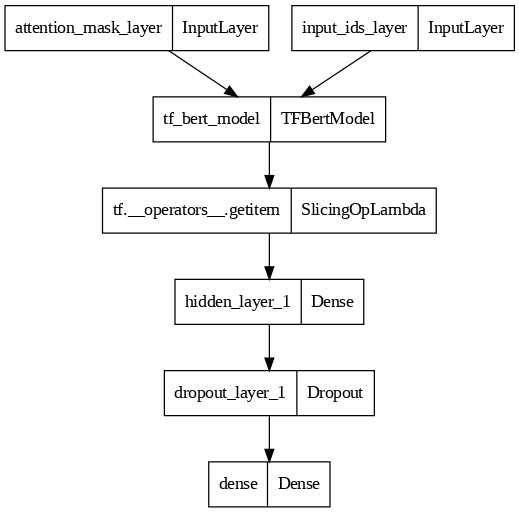

Training Regression with BERT.....
Epoch 1/10


391/391 [==============================] - 452s 1s/step - loss: 0.7881 - MCRMSE: 0.7881 - val_loss: 0.4616 - val_MCRMSE: 0.4616
Epoch 2/10
391/391 [==============================] - 409s 1s/step - loss: 0.6995 - MCRMSE: 0.6995 - val_loss: 0.4567 - val_MCRMSE: 0.4566
Epoch 3/10
391/391 [==============================] - 409s 1s/step - loss: 0.6673 - MCRMSE: 0.6673 - val_loss: 0.4426 - val_MCRMSE: 0.4426
Epoch 4/10
391/391 [==============================] - 403s 1s/step - loss: 0.6539 - MCRMSE: 0.6539 - val_loss: 0.4771 - val_MCRMSE: 0.4771
Epoch 5/10
183/391 [=============>................] - ETA: 3:22 - loss: 0.6367 - MCRMSE: 0.6367

In [ ]:
run_regression_experiment_1(num_train_layers=12,
                          num_hidden_layer=1,
                          num_hidden_units=64,
                          dropout=0.1,
                          learning_rate=0.00001,
                          batch_size=8,               # from 16 to 8: no more OOM error
                          csv_filename='perf_summary_regression_w_BERT_final1.csv',
                          activation='relu',
                          optimizer='adam',
                          epochs=10)

In [ ]:
# !jupyter nbconvert --to html /content/ELL_Regression_withBERT_4_7_2023.ipynb

In [48]:
# !jupyter nbconvert --help-all

In [47]:
# !jupyter nbconvert --ClearOutputPreprocessor.enabled=True \
# --ClearMetadataPreprocessor.enabled=True \
# --ClearMetadataPreprocessor.preserve_cell_metadata_mask='[("tags")]' \
# --to=notebook --stdin --stdout --log-level=ERROR

In [46]:
# !pip freeze
# nbformat==5.8.0 (mine)
# spring_2023_w266_final_project_heesuk_iris_srila/iris/W266_essay_evaluation_final.ipynb
#   "nbformat": 4,
  # "nbformat_minor": 0